
# Adversarial Generative Networks for number generation



Developed by Kevin Reyes - Diego Quezada.


In [ ]:
import random



# GAN for MNIST

 Probably one of the most interesting recent developments in the area of neural networks are GANs, or *Generative Adversarial Networks* . These have dazzled the world in recent years, generating unexpected results, such as the so-called *deep fakes* ( [https://www.youtube.com/watch?v=25GjijODWoI&amp;ab_channel=Borked](https://www.youtube.com/watch?v=25GjijODWoI&amp;ab_channel=Borked) ), artificially generated non-existent faces, among many other applications of which the most creative and fun are widely publicized. These results show us that these networks, when implemented correctly, have the ability to carry out very specific tasks, achieving performances that even, in some cases, deceive human observers.

 Depending on the problem one wants to solve, GANs do not require labeled data. They achieve this thanks to their adversarial structure, that is, where two networks are trained simultaneously, one specialized in generating data and another network specialized in discriminating true data from false data, in its simplest configuration at least. In this work we will generate such a network that generates digits that appear to be made by hand. For this we will use the training images of the MNIST dataset.


In [ ]:
from keras.datasets import mnist
import numpy as np

(x, _), (_, _) = mnist.load_data()
x = x.reshape((-1, 28, 28, 1)).astype(np.float32)
x = x / 255


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.models import Sequential
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.optimizers import Adam
import matplotlib.pyplot as plt



## a) GAN.

 We will use a neural network architecture in order to obtain convincing fake images.

 **Comments:**

 Initially, both the generator and the discriminator improve their performance, however, the learning of the discriminator is faster than that of the generator and this causes the learning of the generator to stall from a certain point, since the discriminator predicts all the images. generated as false not giving clues to the generator of what would be a good way to follow to generate more real images. These values do not necessarily represent that the network reaches the objective of generating realistic images, since we could have a poor discriminator that considers all the images as real, in this case, although the generator is not generating realistic images, the metric will be saying that it has good performance.

 If the generating network could not generate reasonable images, this would cause inefficient training of the discriminator, since, if the generator is generating very unrealistic images, the discriminator will not be prepared to receive artificially generated images that are realistic, and most likely consider them true.

 Analogously to the previous point, a bad discriminator would not allow a good generator to be obtained, since the generator could generate random noise and the discriminator could tell it that it is a real image, the discriminator thinks that it is doing its job well and therefore leaves of learning.

 The images are not entirely convincing, although patterns similar to real numbers are generated, there are some traces of noise that do not correspond to the shape of the numbers.


In [ ]:
noise_size = 50
discriminator_net = Sequential()
depth = 64
dropout = 0.4
# In: 28 x 28 x 1, depth = 1
# Out: 14 x 14 x 1,
depth = 64
input_shape = x.shape[1:]
discriminator_net.add(
    Conv2D(
        depth * 1,
        5,
        strides=2,
        input_shape=input_shape,
        padding="same",
        activation=LeakyReLU(alpha=0),
    )
)
discriminator_net.add(Dropout(dropout))
discriminator_net.add(
    Conv2D(depth * 2, 5, strides=2, padding="same", activation=LeakyReLU(alpha=0))
)
discriminator_net.add(Dropout(dropout))
discriminator_net.add(
    Conv2D(depth * 4, 5, strides=2, padding="same", activation=LeakyReLU(alpha=0))
)
discriminator_net.add(Dropout(dropout))
discriminator_net.add(
    Conv2D(depth * 8, 5, strides=1, padding="same", activation=LeakyReLU(alpha=0))
)
discriminator_net.add(Dropout(dropout))  # Out: 1-dim probability
discriminator_net.add(Flatten())
discriminator_net.add(Dense(1))
discriminator_net.add(layers.Activation("sigmoid"))
# discriminator_net.summary()
# compile discriminator_net
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator_net.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(lr=0.0002, decay=8e-8),
    metrics=["accuracy"],
)


generator_net = Sequential()
dropout = 0.4
depth = 64 + 64 + 64 + 64
dim = 7
# In: 100
# Out: dim x dim x depth
generator_net.add(Dense(dim * dim * depth, input_shape=[noise_size]))
generator_net.add(BatchNormalization(momentum=0.9))
generator_net.add(layers.Activation("relu"))
generator_net.add(Reshape((dim, dim, depth)))
generator_net.add(
    Dropout(dropout)
)  # In: dim x dim x depth# Out: 2*dim x 2*dim x depth/2
generator_net.add(UpSampling2D())
generator_net.add(layers.Conv2DTranspose(int(depth / 2), 5, padding="same"))
generator_net.add(BatchNormalization(momentum=0.9))
generator_net.add(layers.Activation("relu"))
generator_net.add(UpSampling2D())
generator_net.add(layers.Conv2DTranspose(int(depth / 4), 5, padding="same"))
generator_net.add(BatchNormalization(momentum=0.9))
generator_net.add(layers.Activation("relu"))
generator_net.add(layers.Conv2DTranspose(int(depth / 8), 5, padding="same"))
generator_net.add(BatchNormalization(momentum=0.9))
generator_net.add(
    layers.Activation("relu")
)  # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
generator_net.add(layers.Conv2DTranspose(1, 5, padding="same"))
generator_net.add(layers.Activation("sigmoid"))


discriminator = (
    Sequential()
)  # We compile the discriminator, however we must create the auxiliary network to discriminator_net, to be able to train it independent of the generator
discriminator.add(discriminator_net)
# Optimos lr = 0.00002
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(lr=0.00007, decay=6e-8),
    metrics=["acc"],
)  # compilamos con binary cross entropy

gan = Sequential()  # GAN will contain the generator and the discriminator in series
gan.add(generator_net)  # we initially add the generator
for layer in discriminator_net.layers:  # and then the discriminator
    layer.trainable = False  # we take care to leave this layer not trainable by the compiler, since this discriminator will be trained with the real data to identify real|fake
gan.add(discriminator_net)  # we add the layers already modified so as not to be trained
# optimo 0.001
gan.compile(
    loss="binary_crossentropy", optimizer=RMSprop(lr=0.001, decay=3e-8)
)  # compilamos


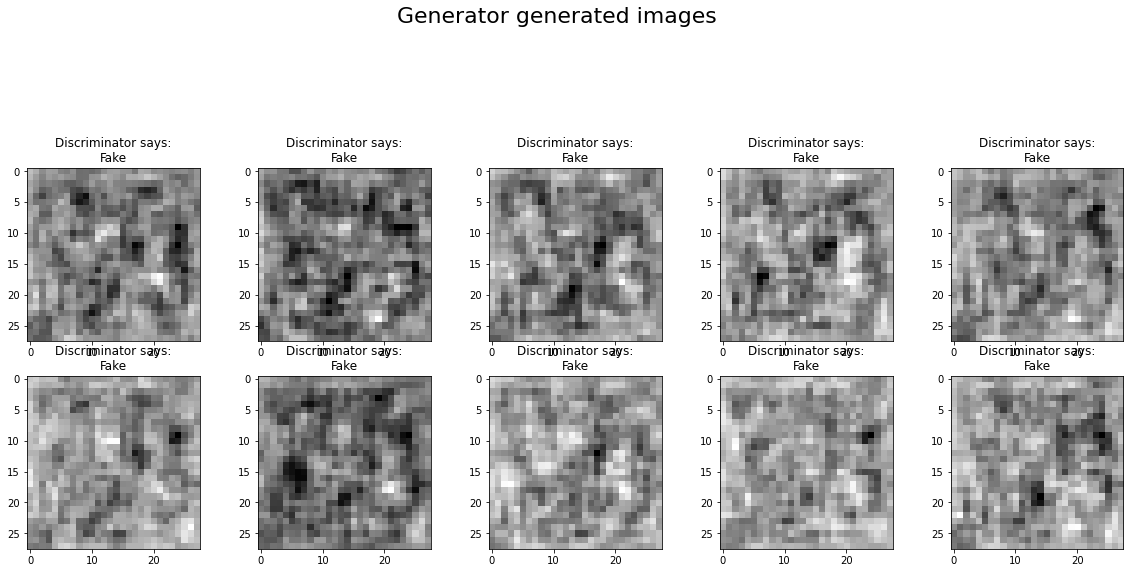

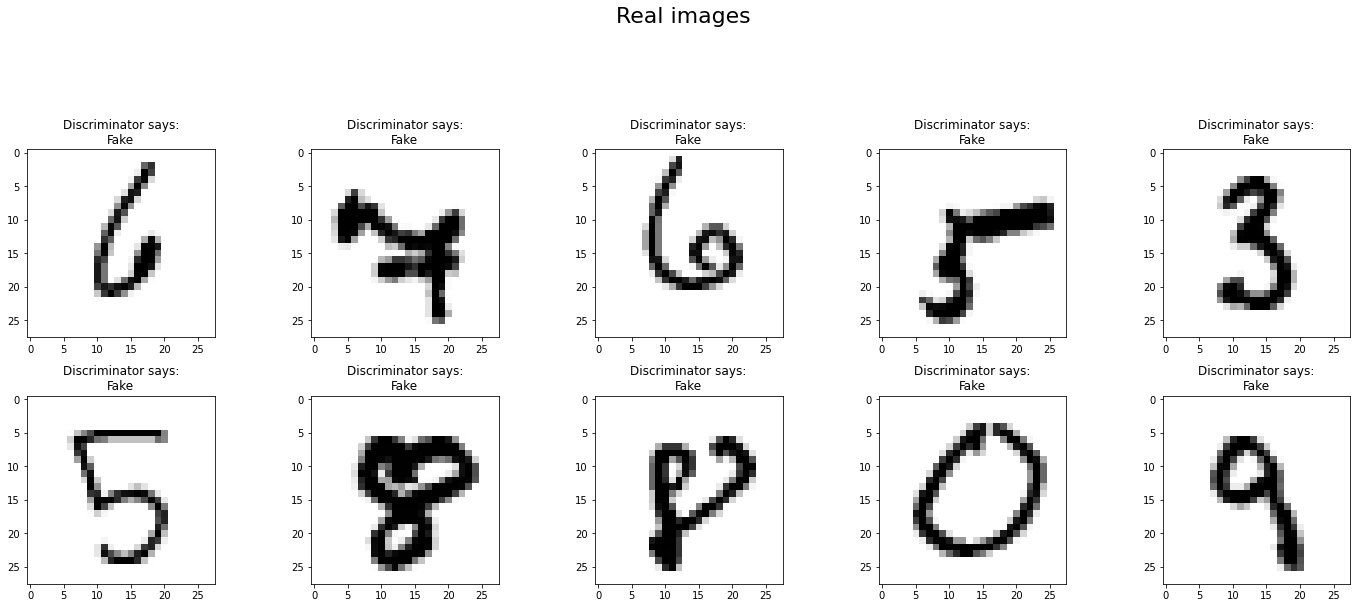

------------------------------------------------------------------------------------------------------------------------


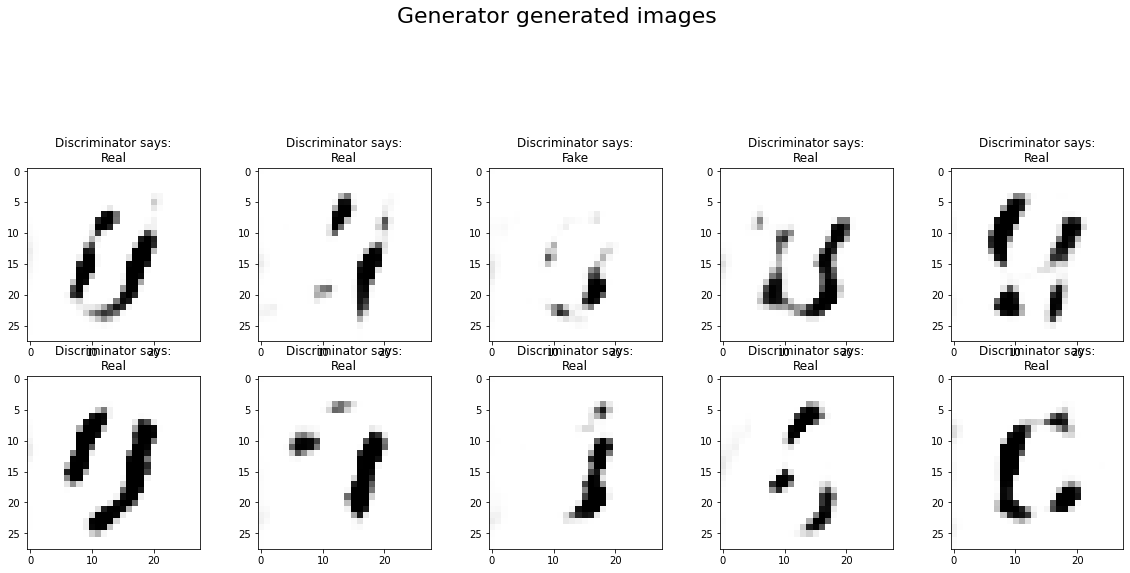

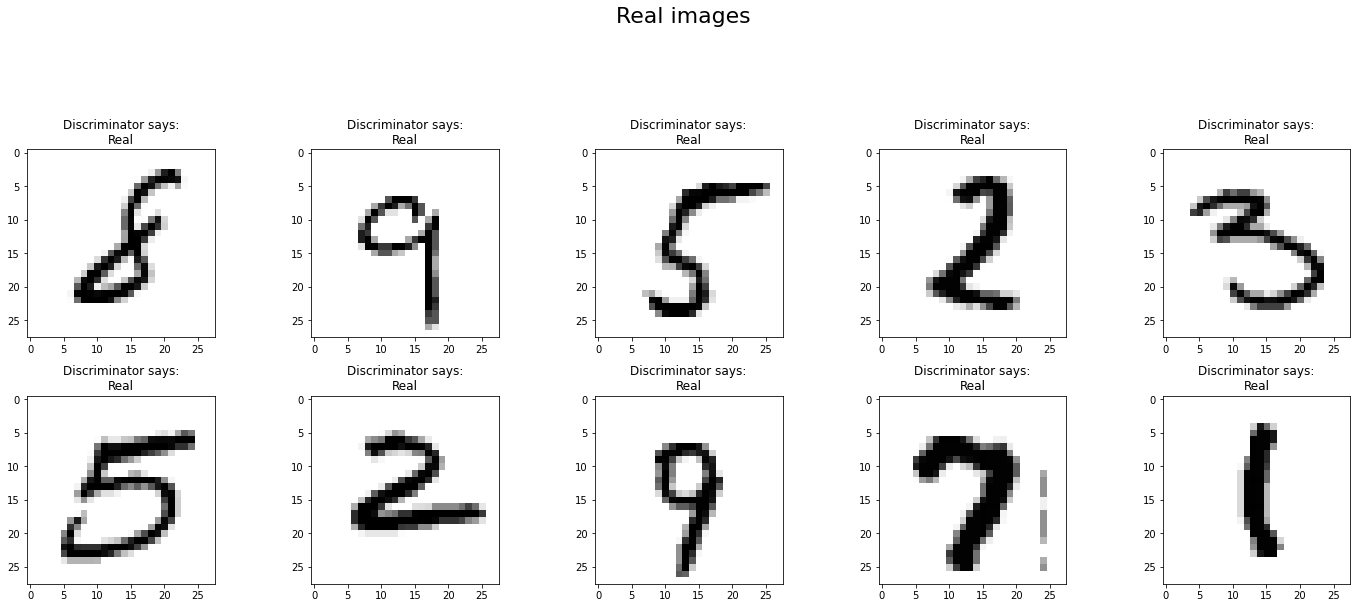

------------------------------------------------------------------------------------------------------------------------


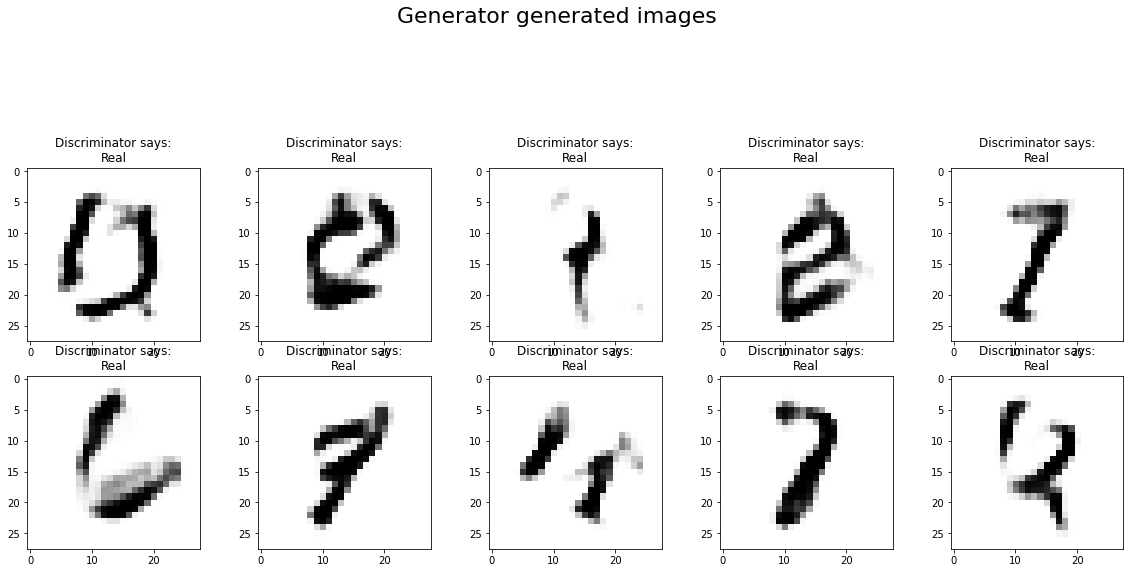

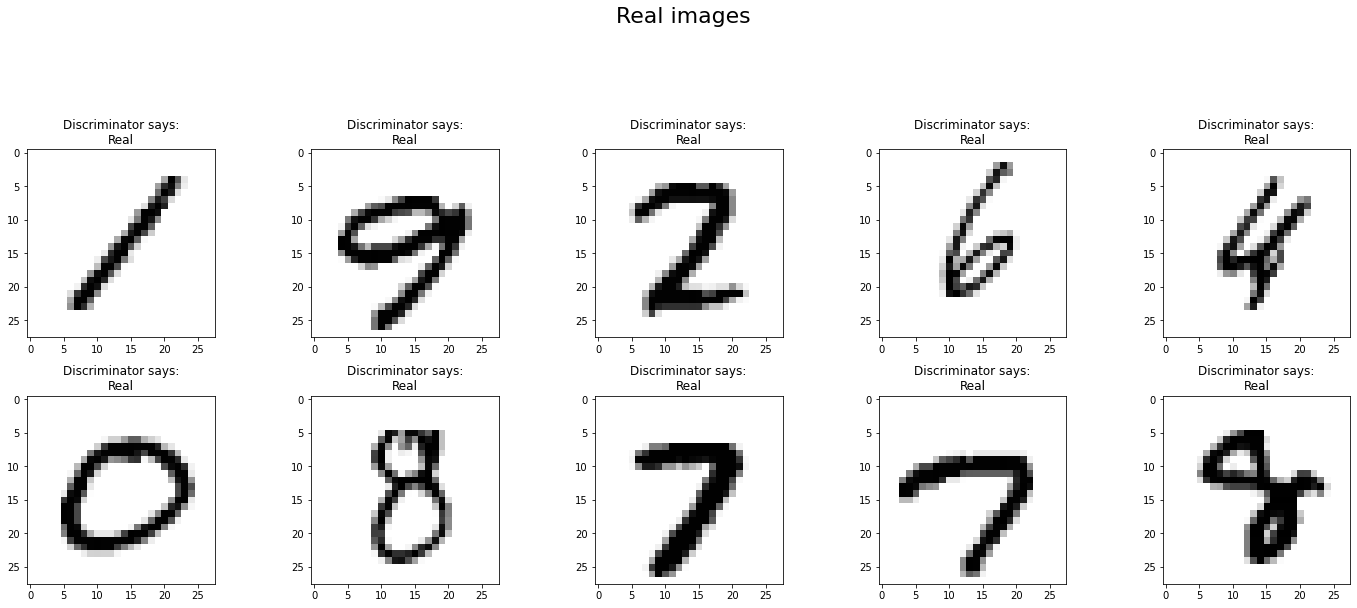

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.5166666666666667
El accuracy del generador es: 0.6333333333333333


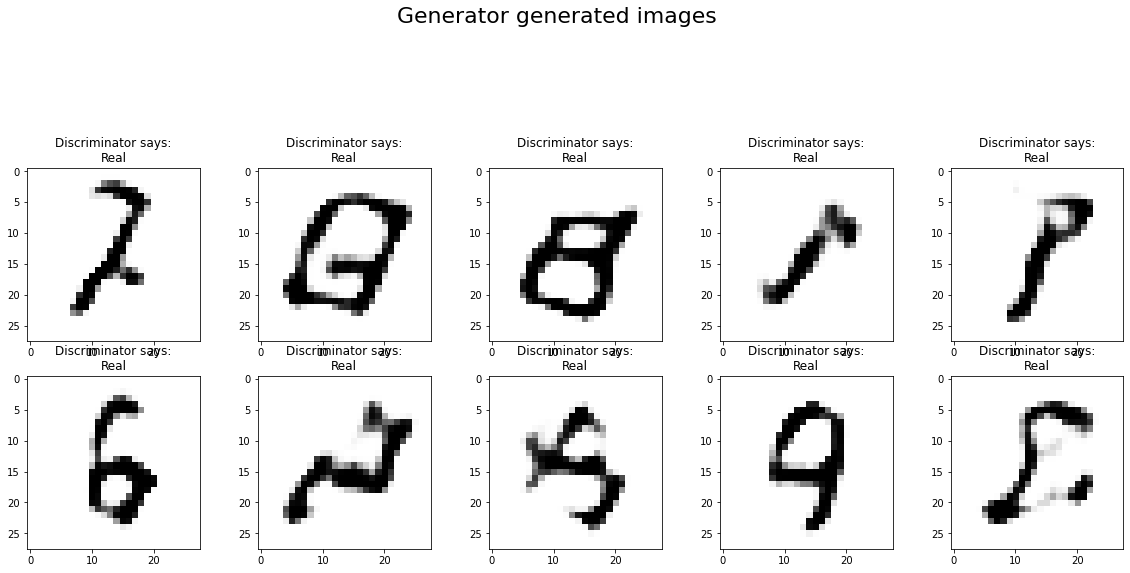

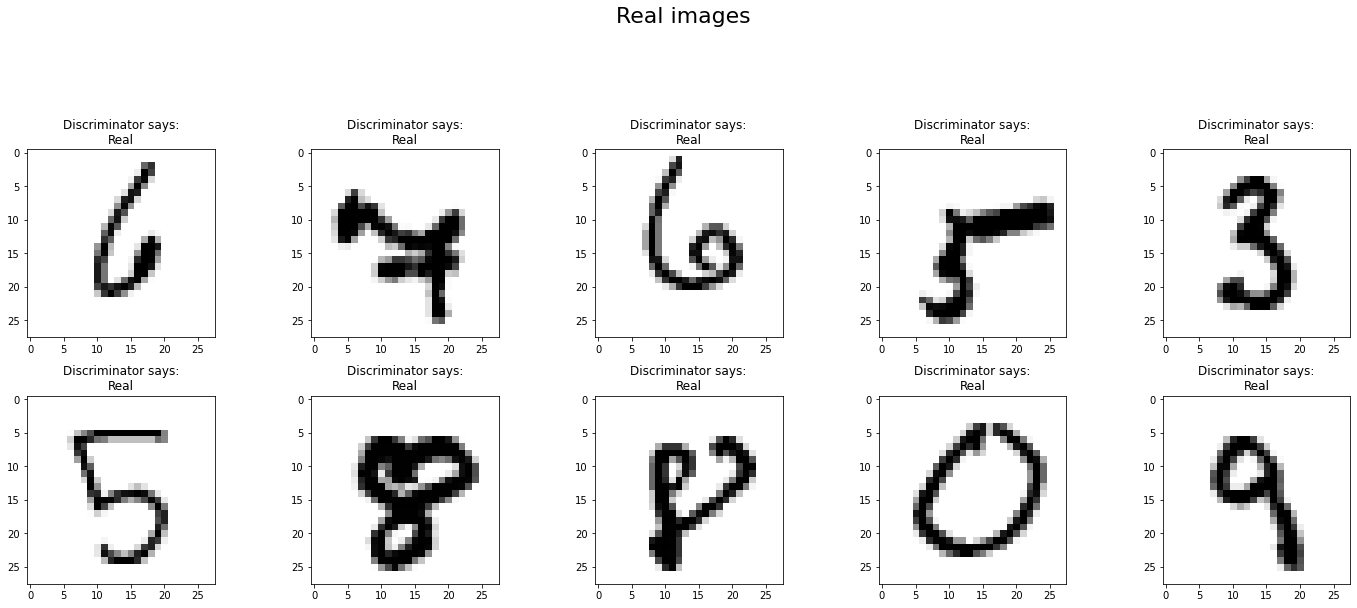

------------------------------------------------------------------------------------------------------------------------


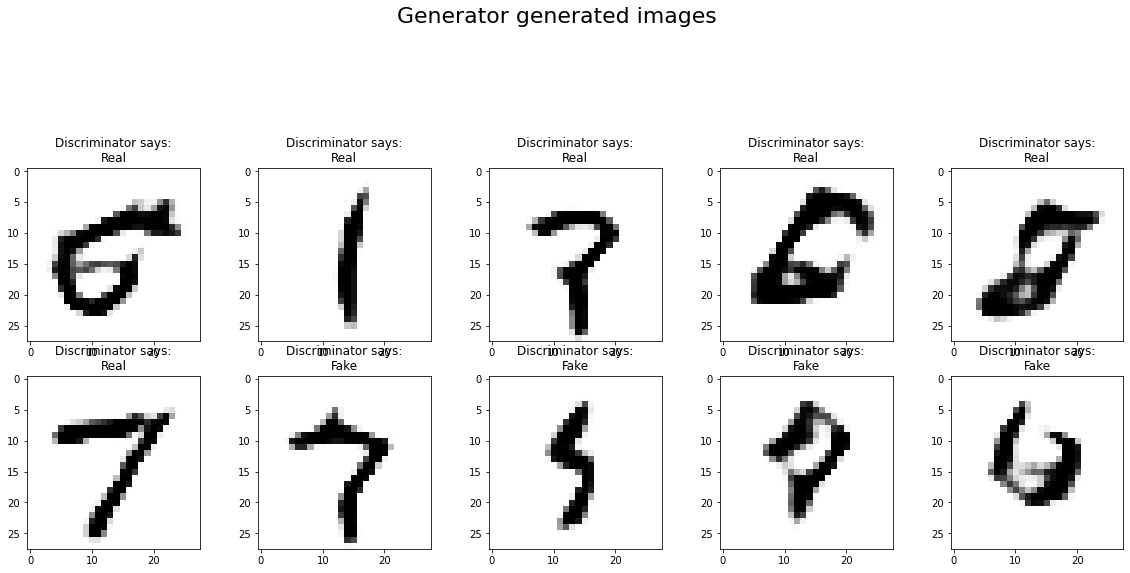

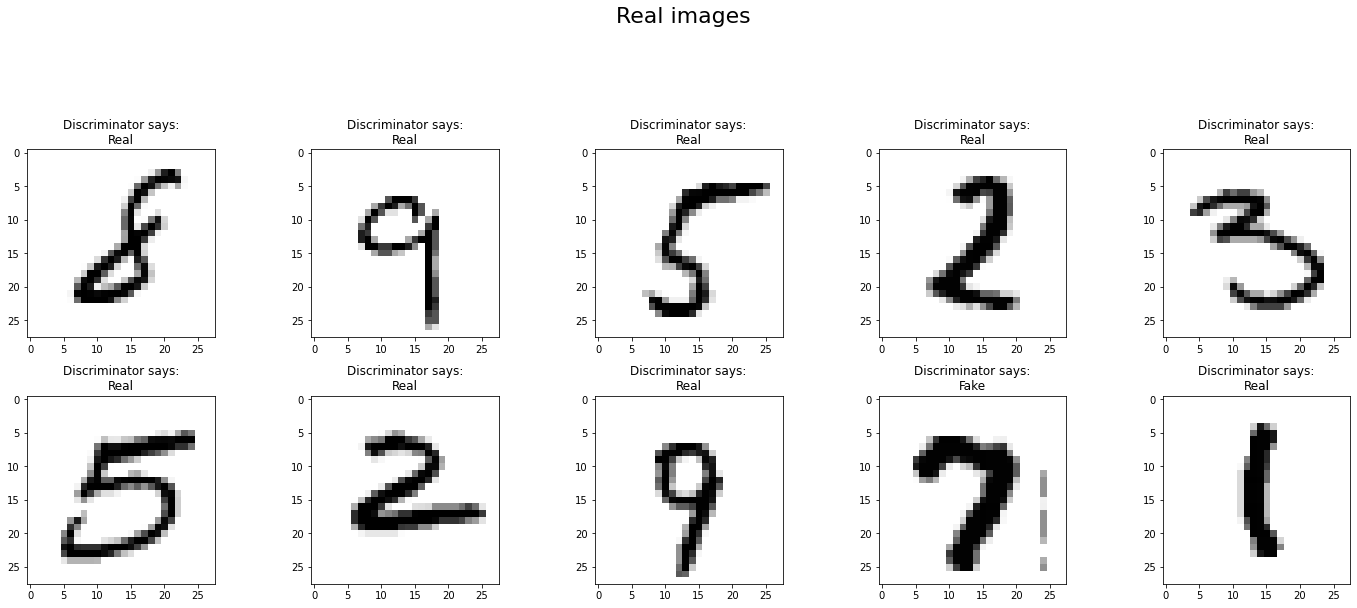

------------------------------------------------------------------------------------------------------------------------


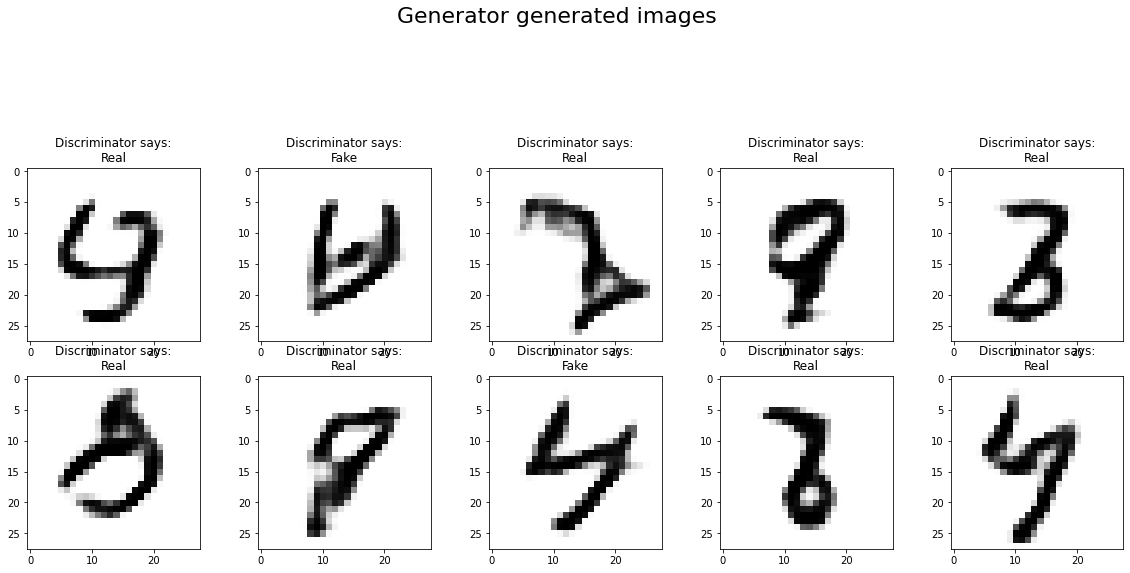

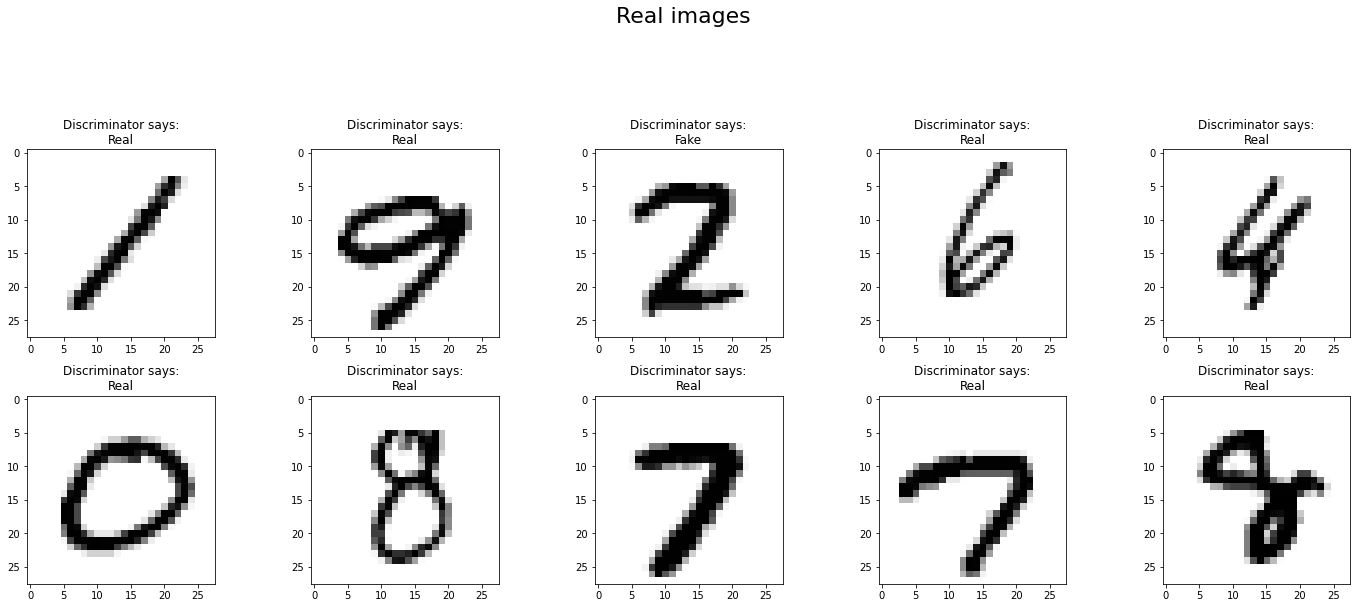

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.5666666666666667
El accuracy del generador es: 0.8


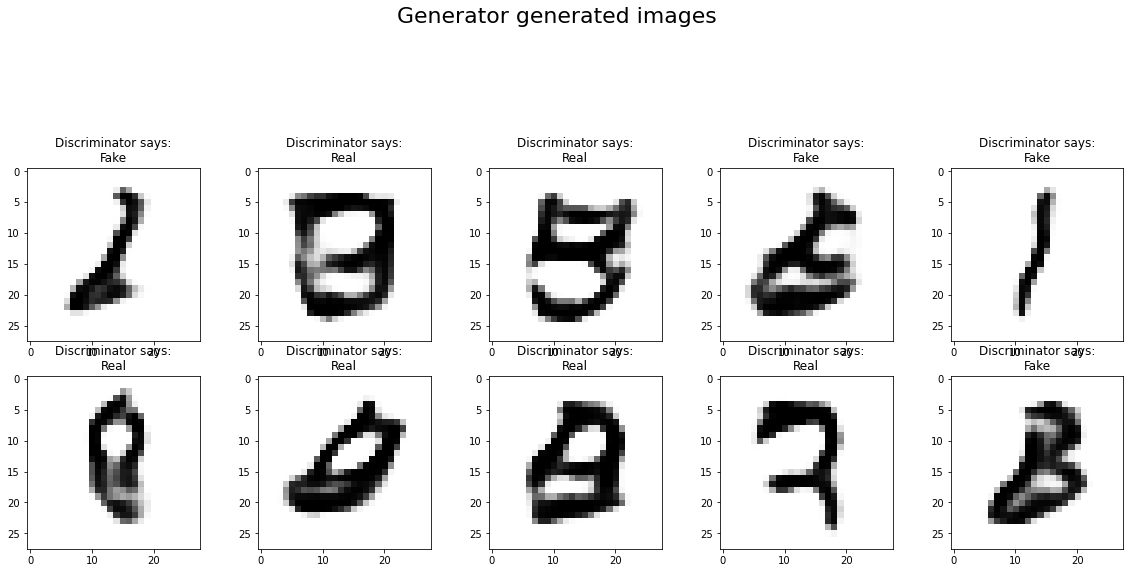

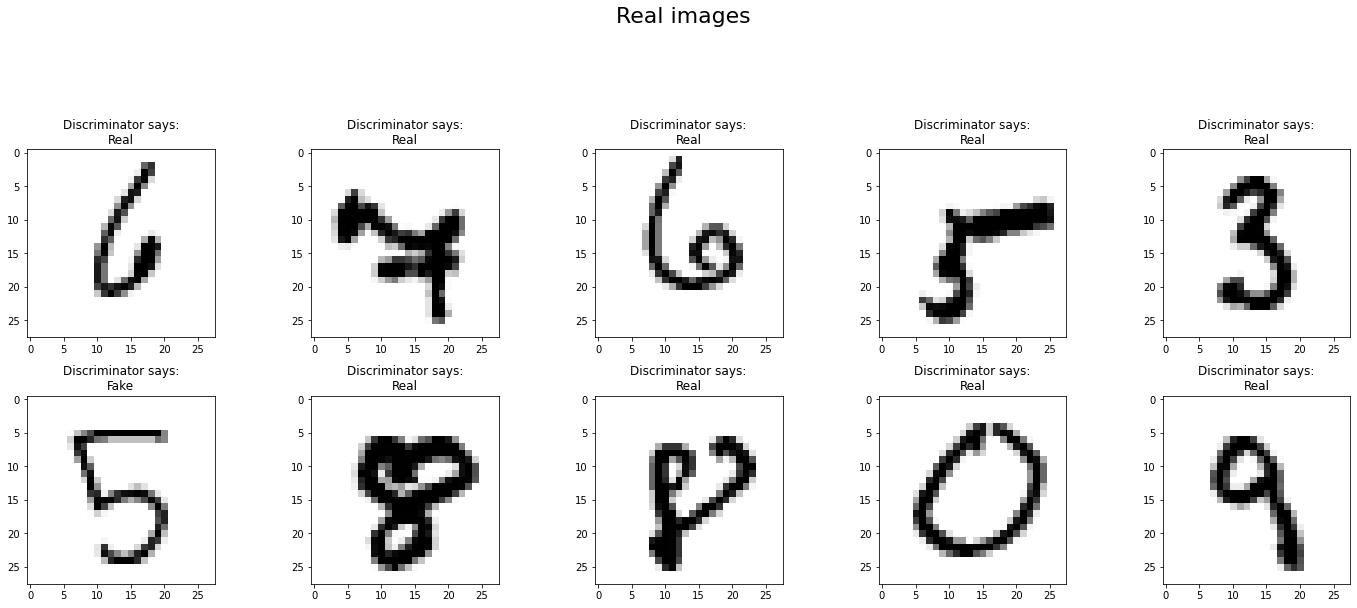

------------------------------------------------------------------------------------------------------------------------


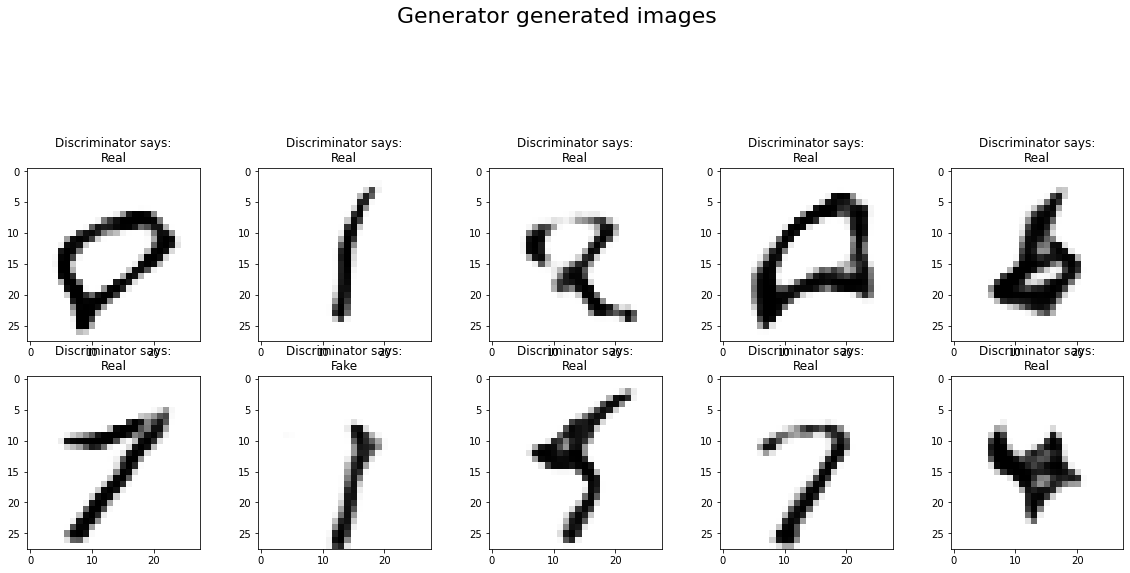

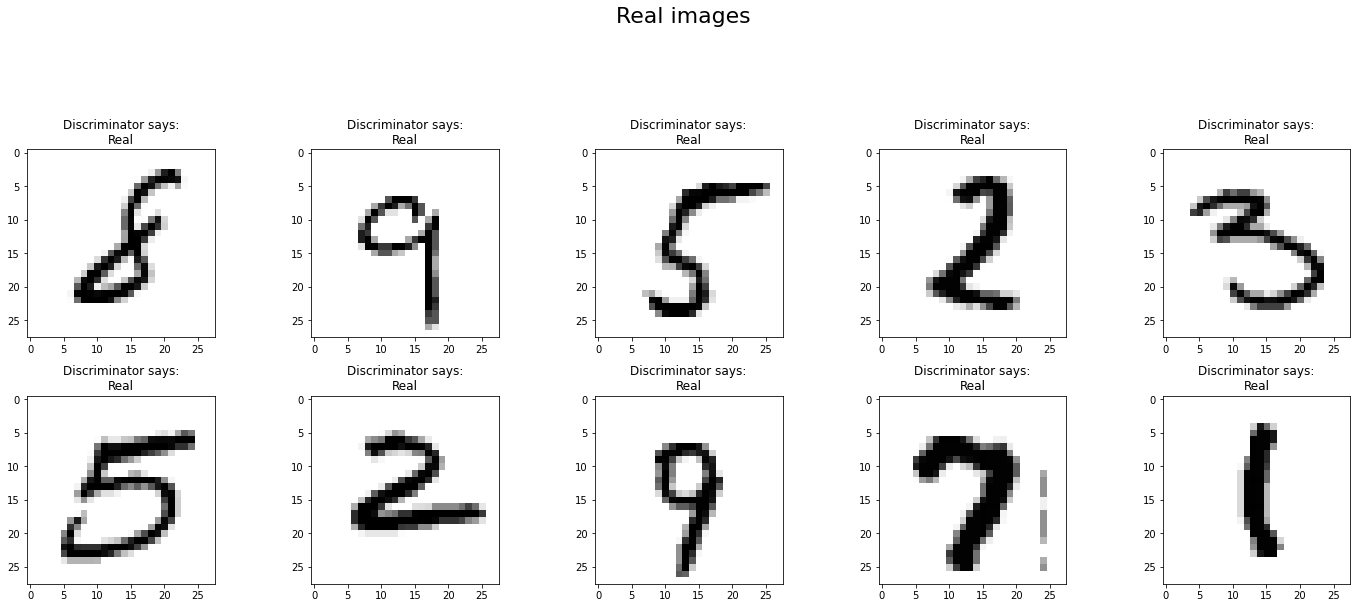

------------------------------------------------------------------------------------------------------------------------


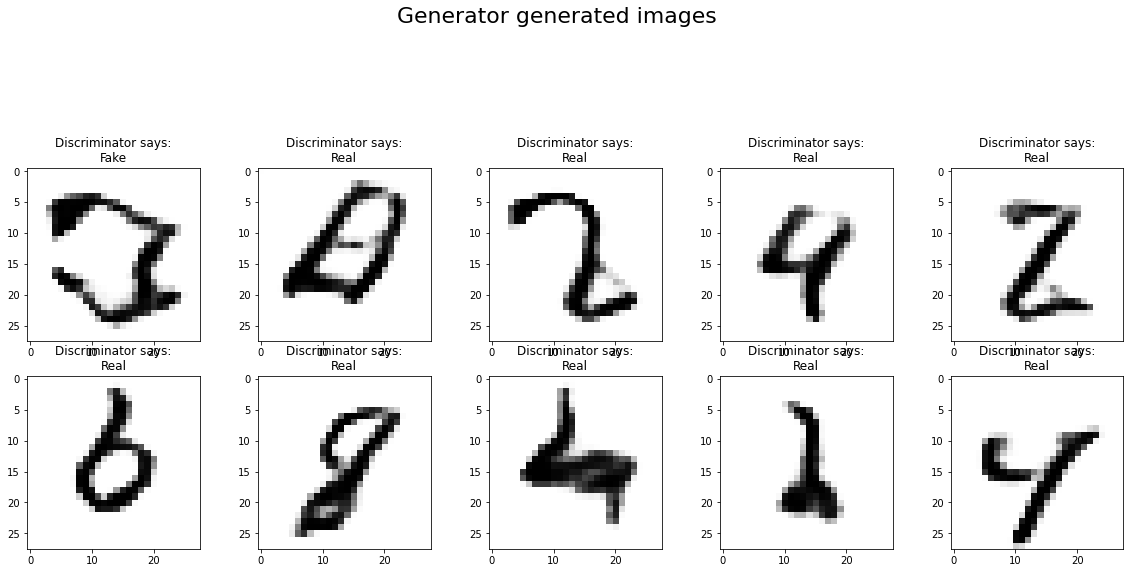

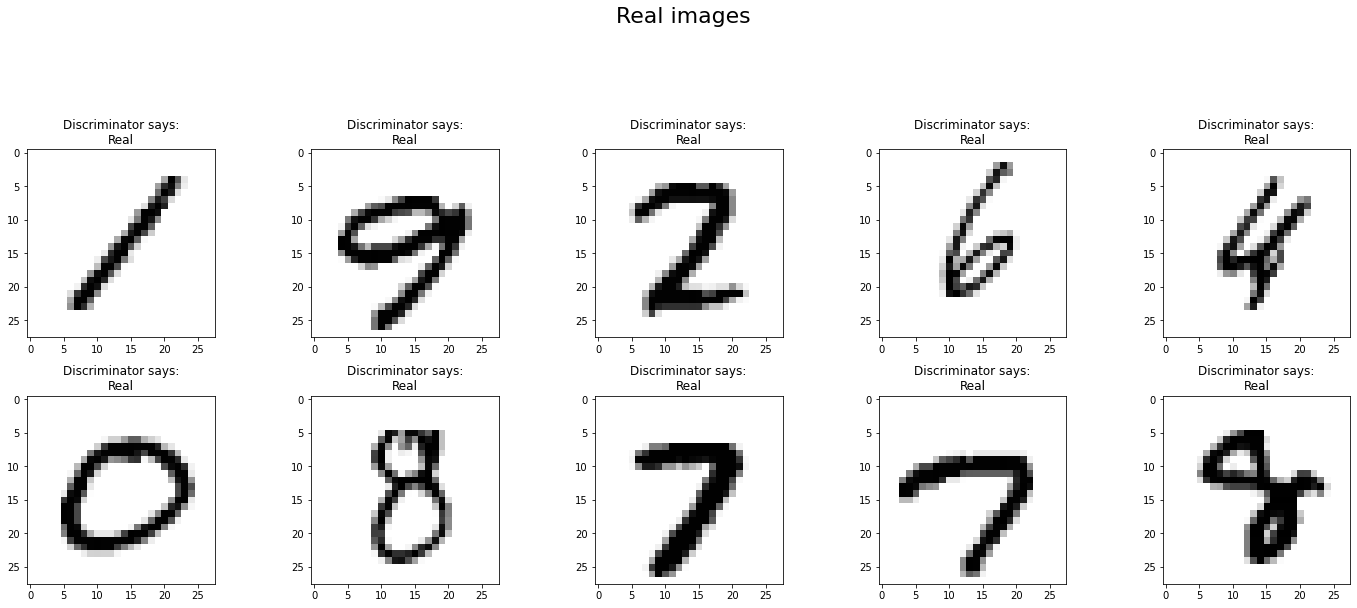

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.5833333333333334
El accuracy del generador es: 0.8


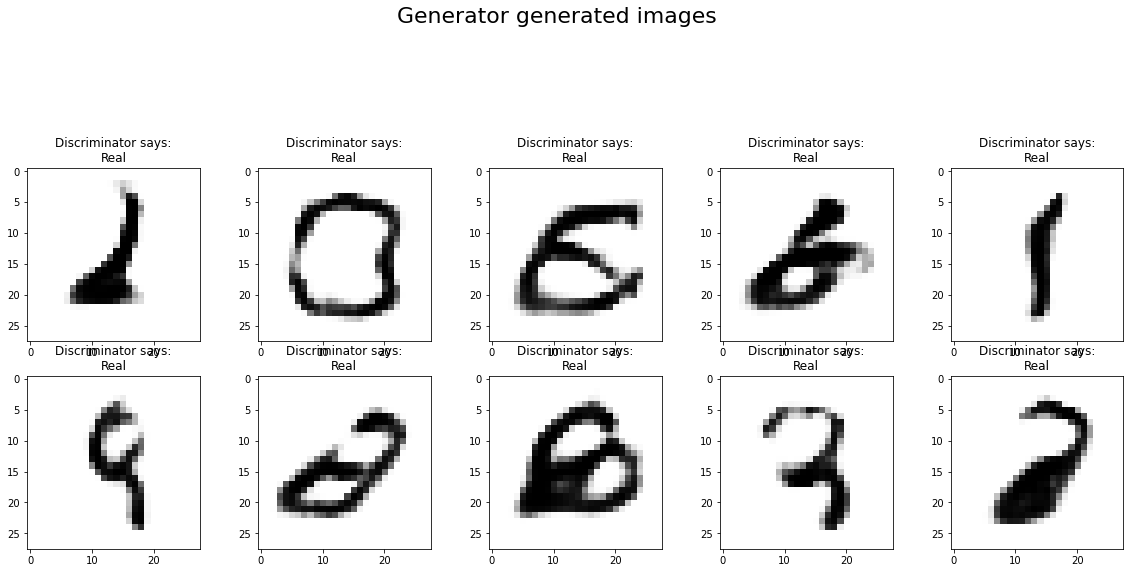

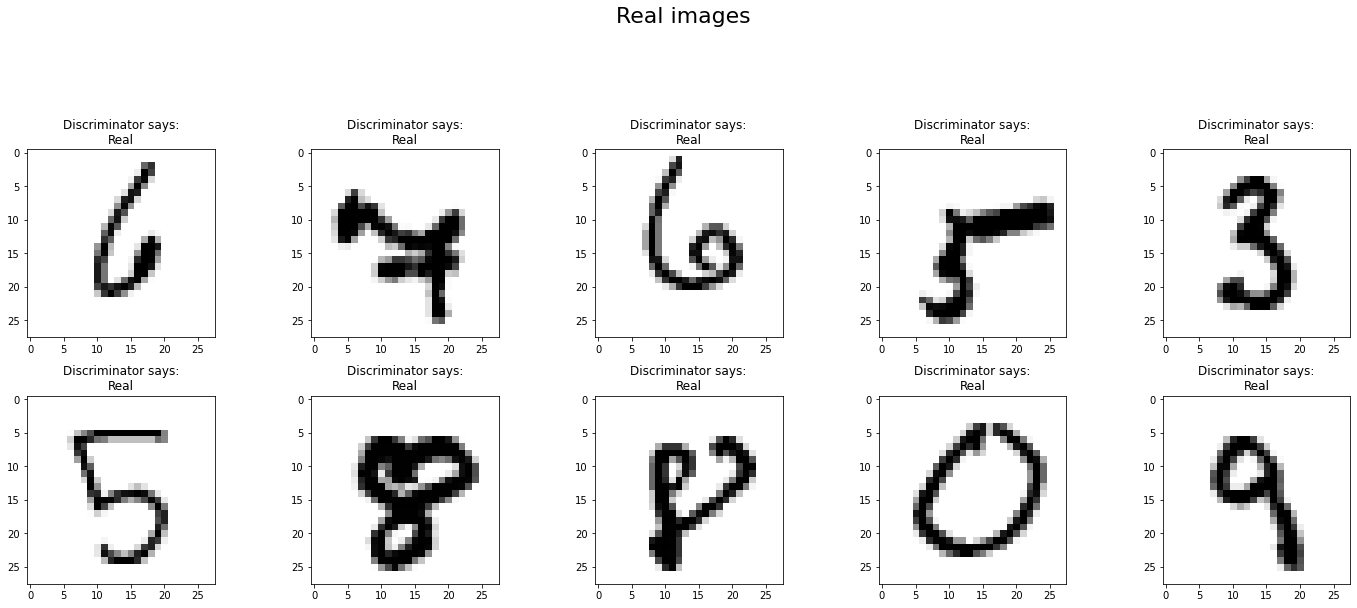

------------------------------------------------------------------------------------------------------------------------


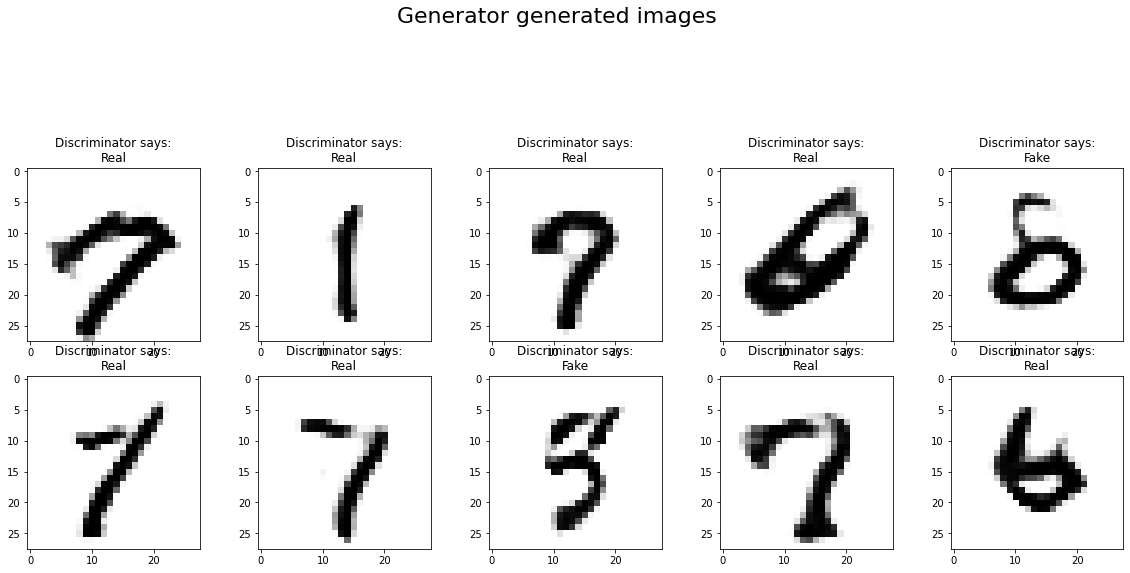

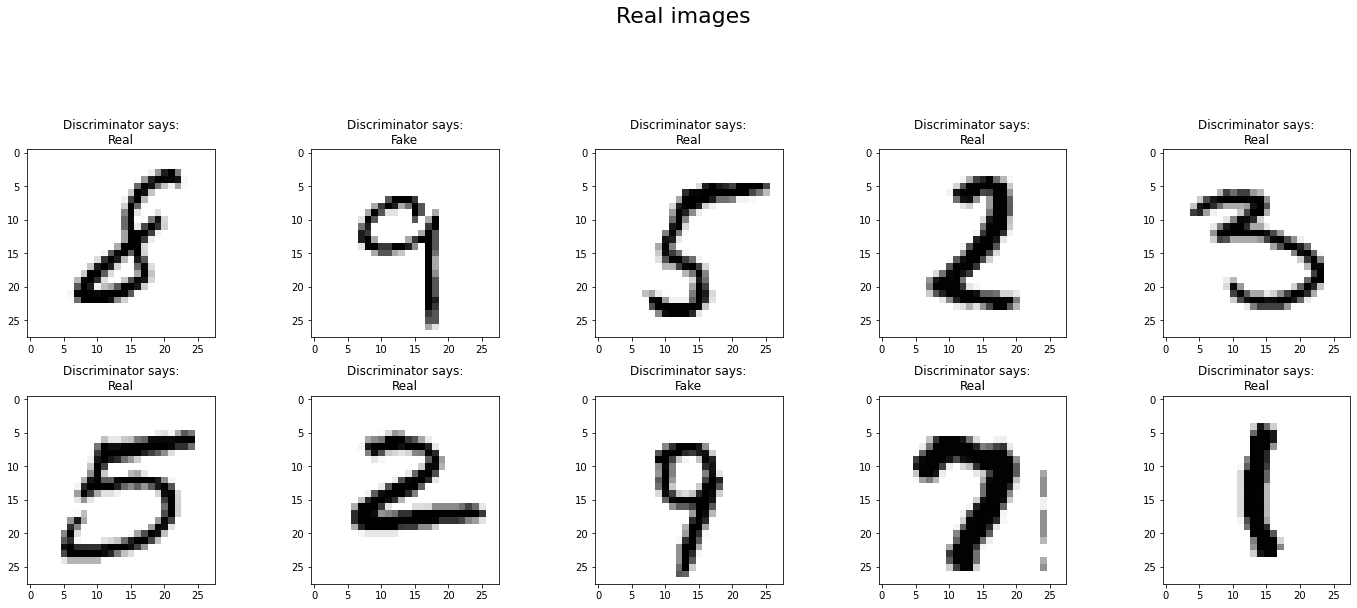

------------------------------------------------------------------------------------------------------------------------


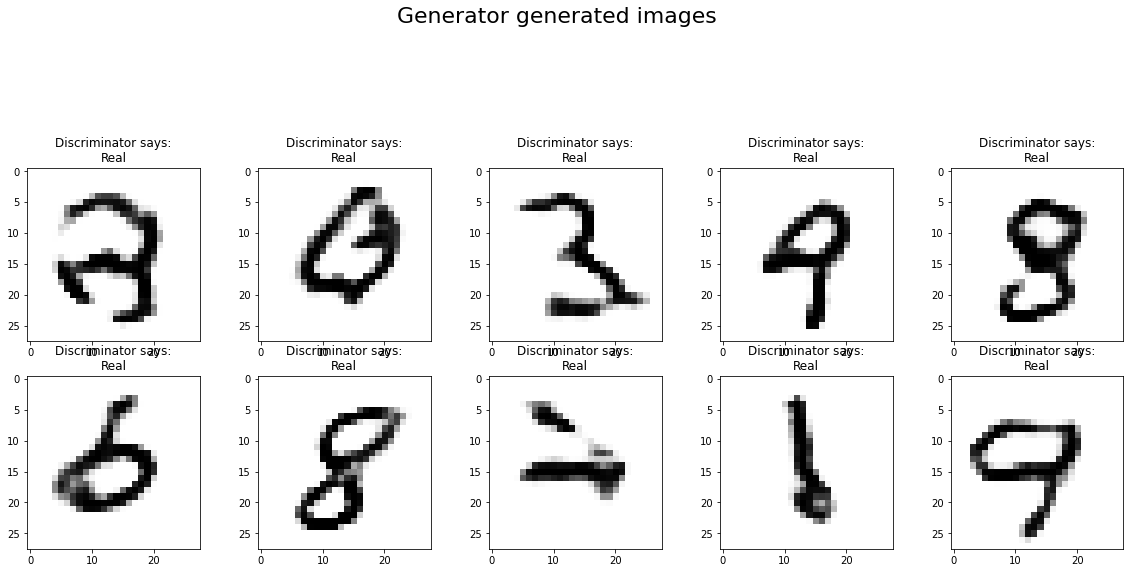

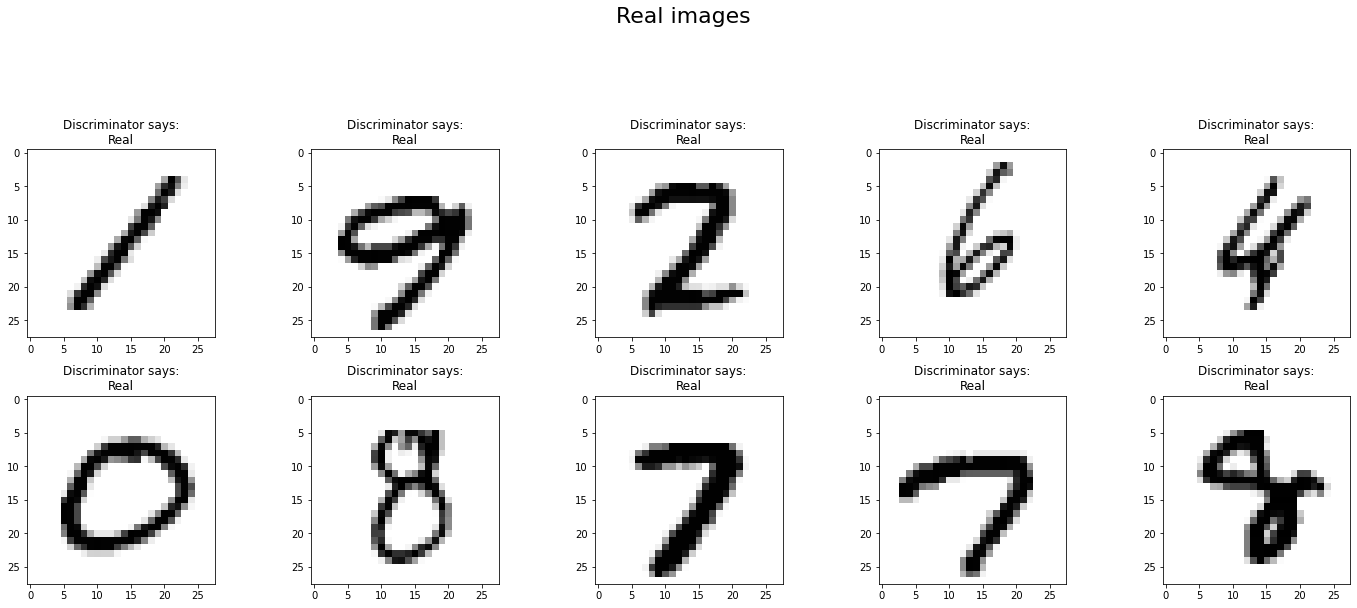

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.5
El accuracy del generador es: 0.9333333333333333


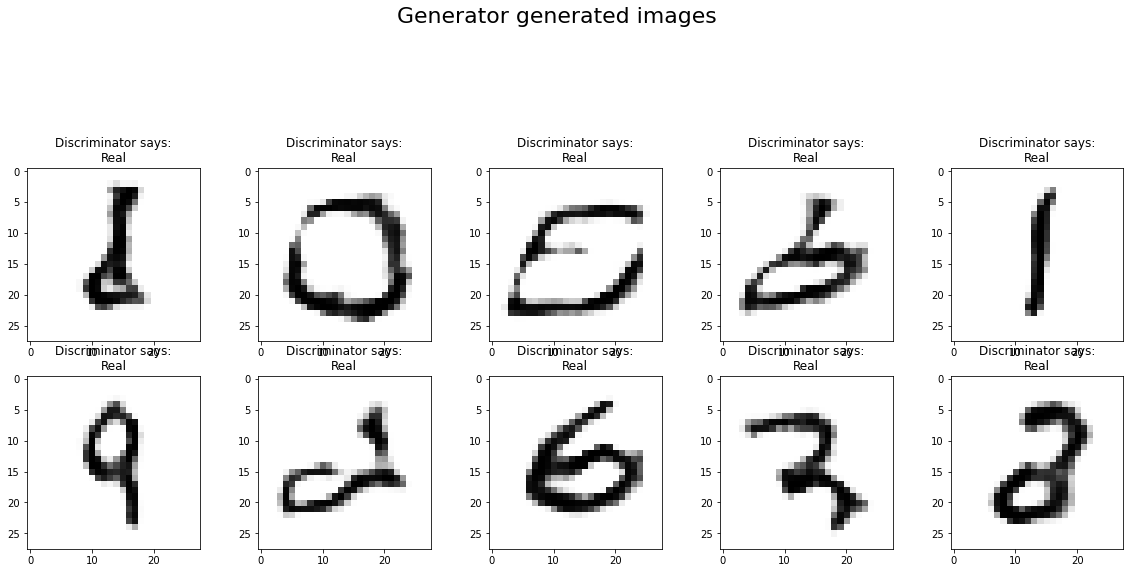

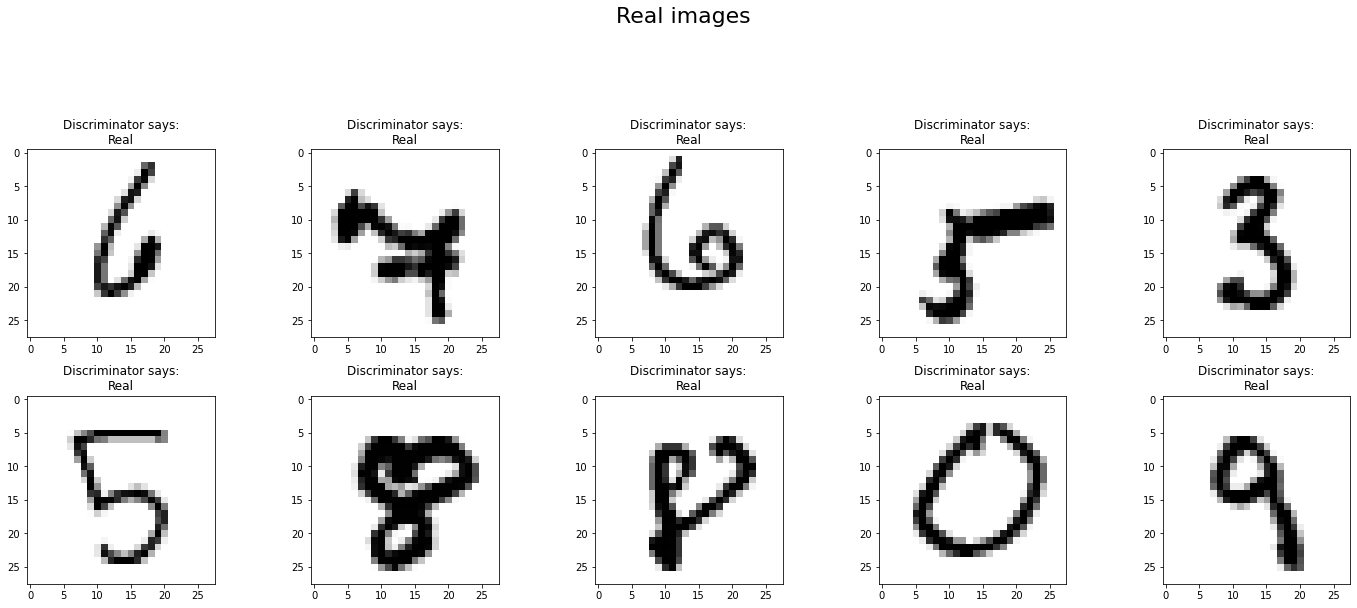

------------------------------------------------------------------------------------------------------------------------


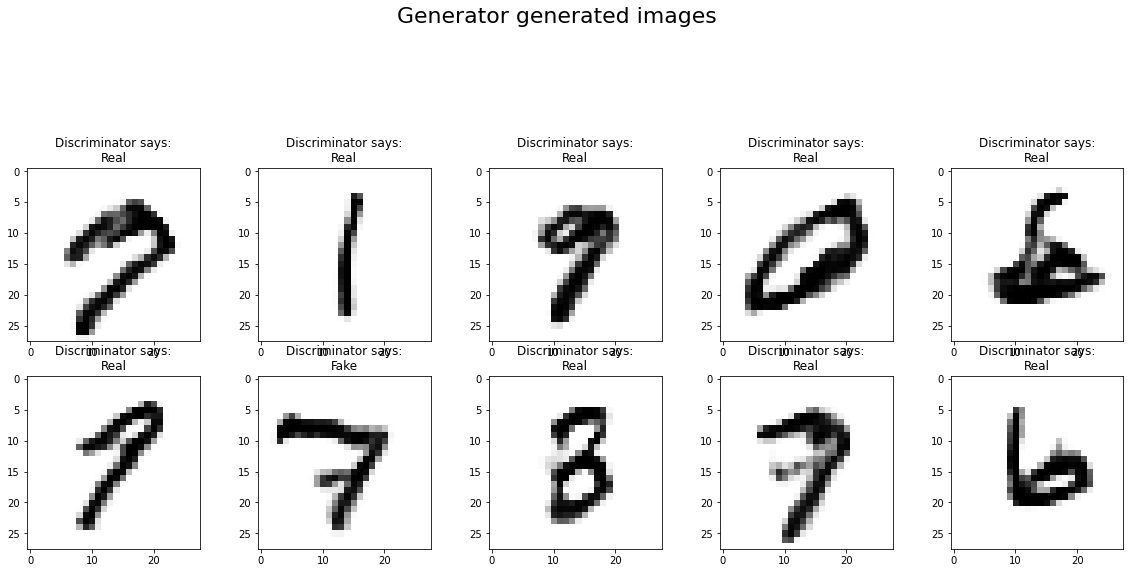

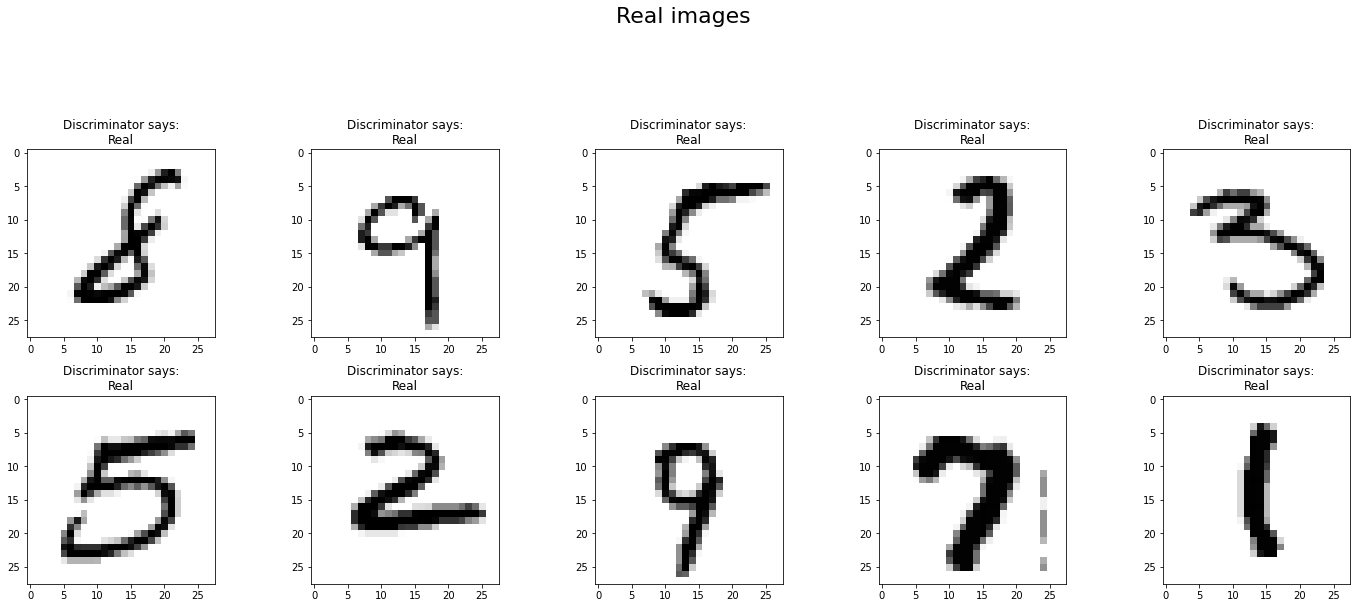

------------------------------------------------------------------------------------------------------------------------


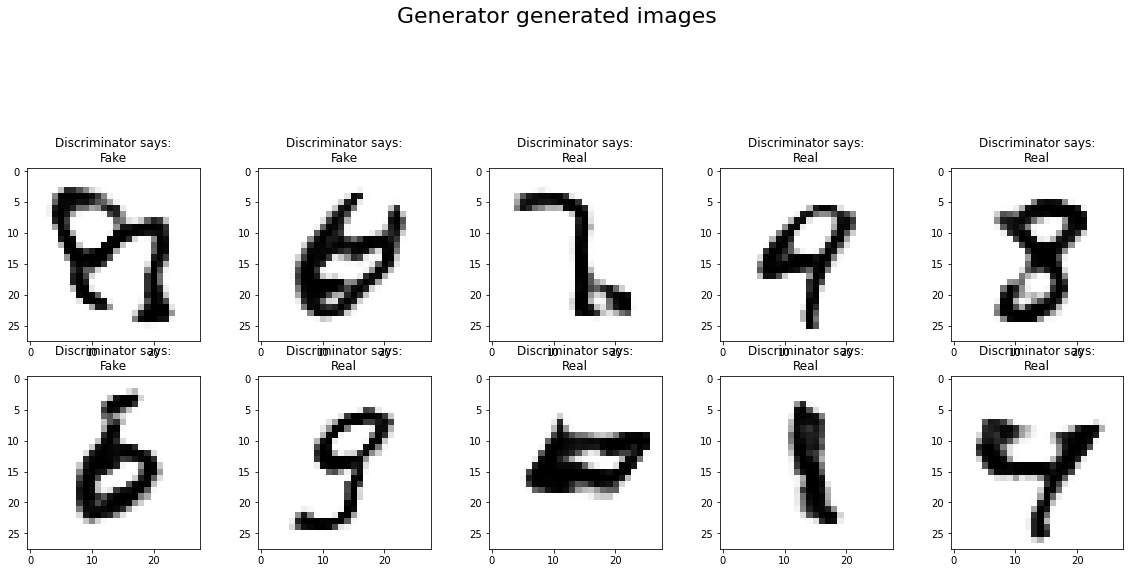

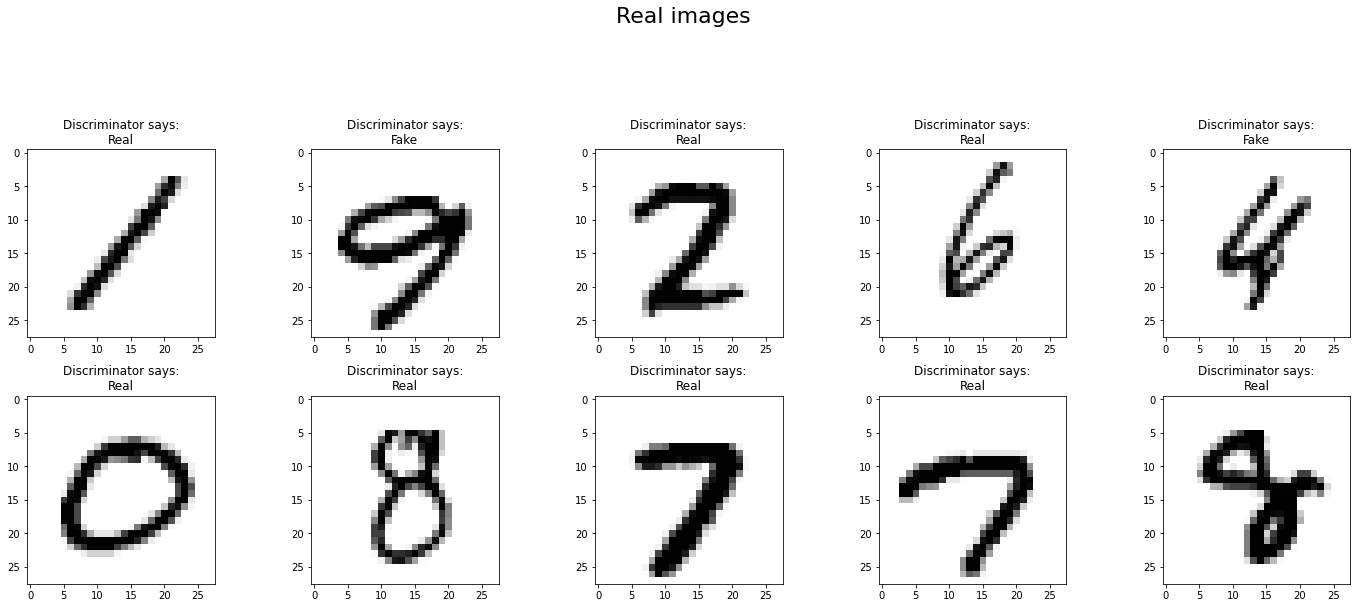

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.5333333333333333
El accuracy del generador es: 0.8666666666666667


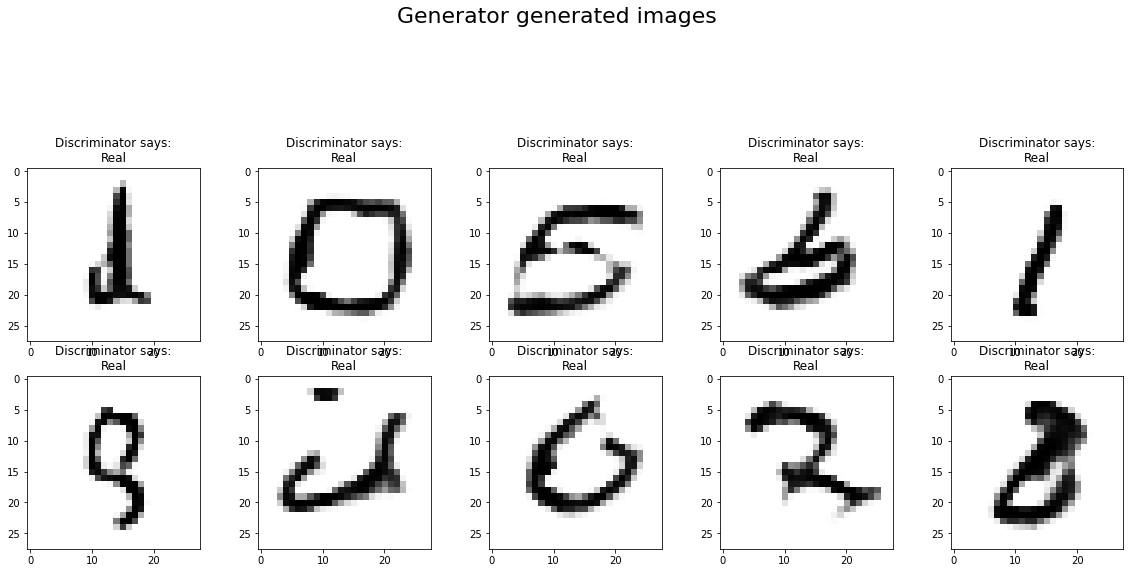

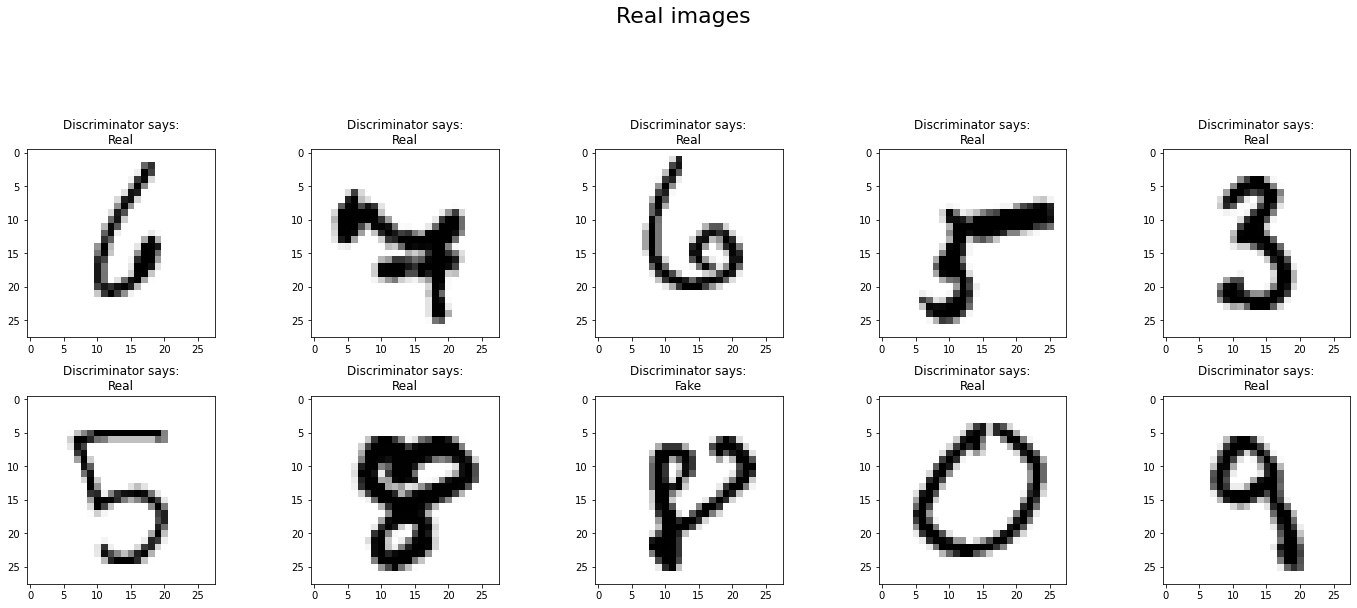

------------------------------------------------------------------------------------------------------------------------


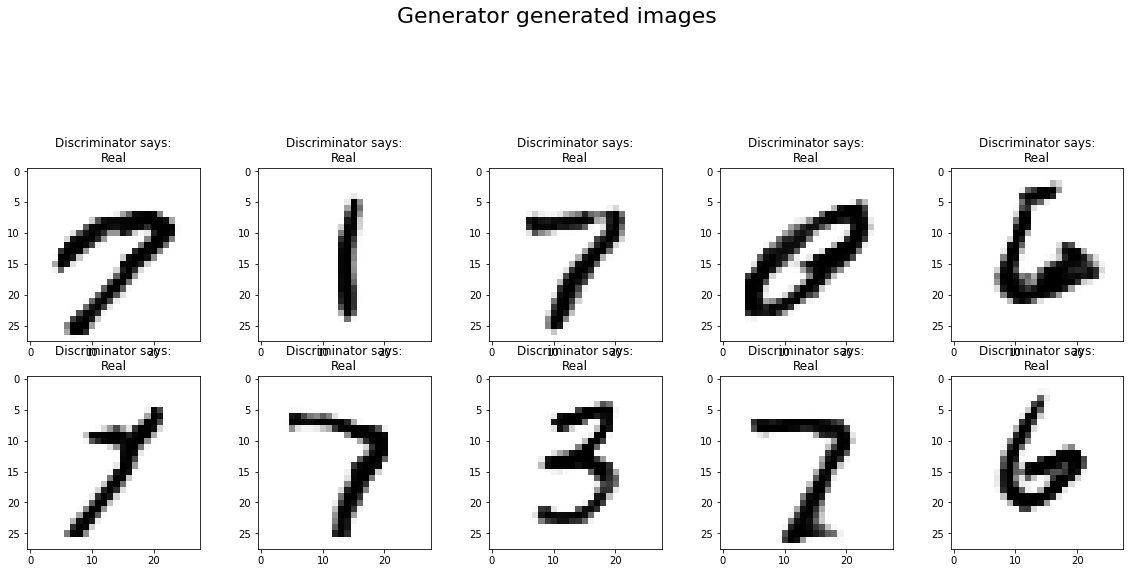

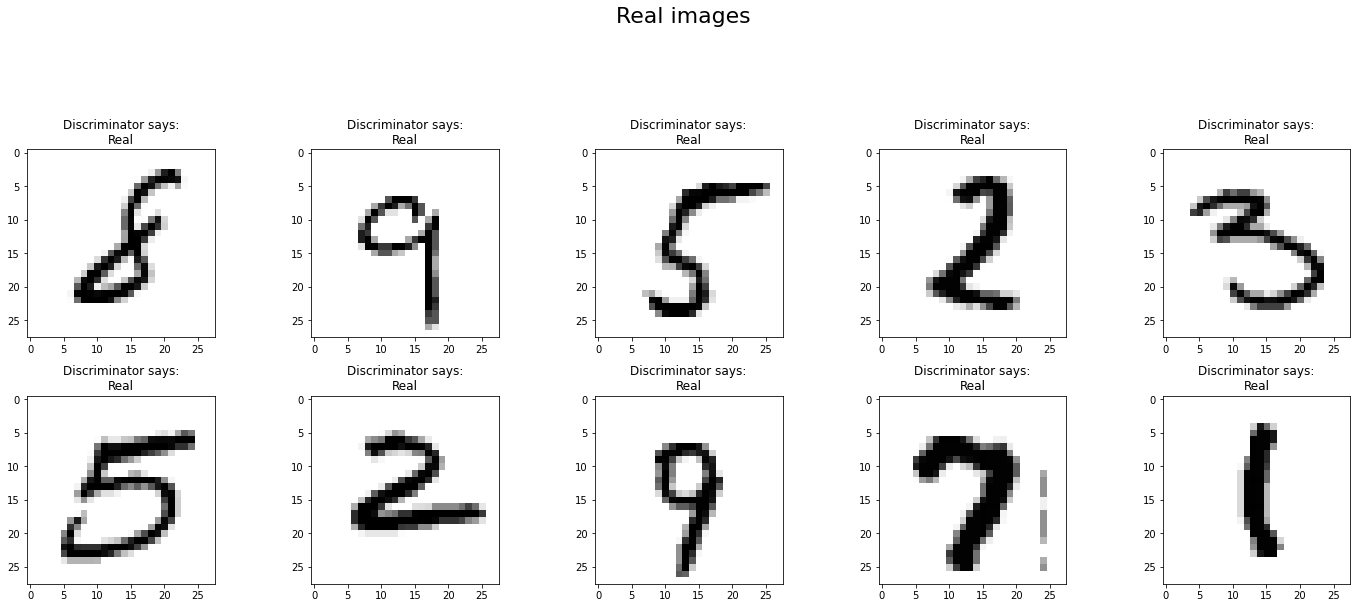

------------------------------------------------------------------------------------------------------------------------


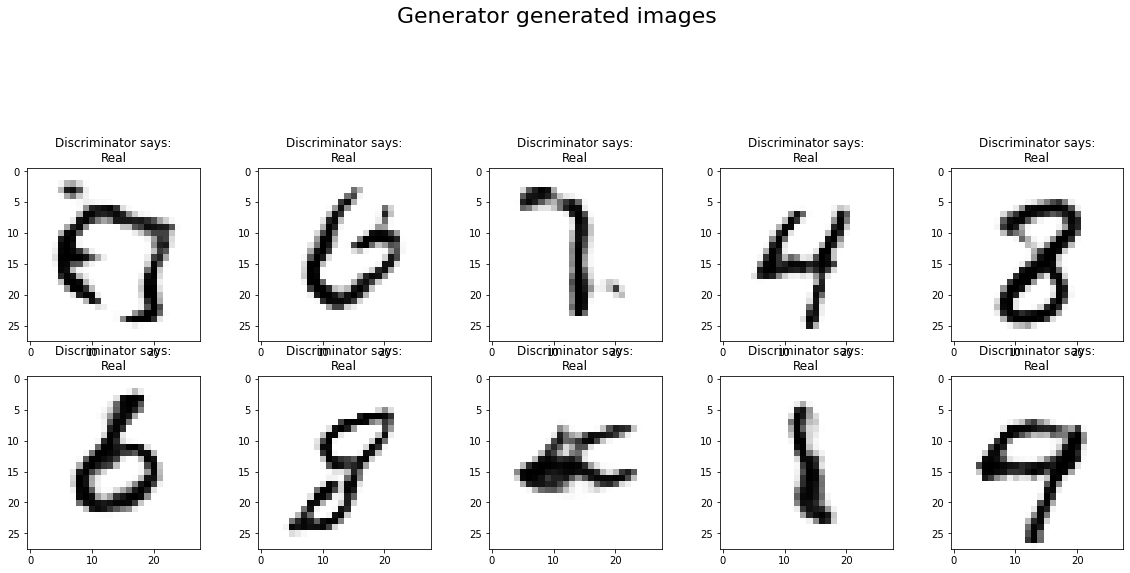

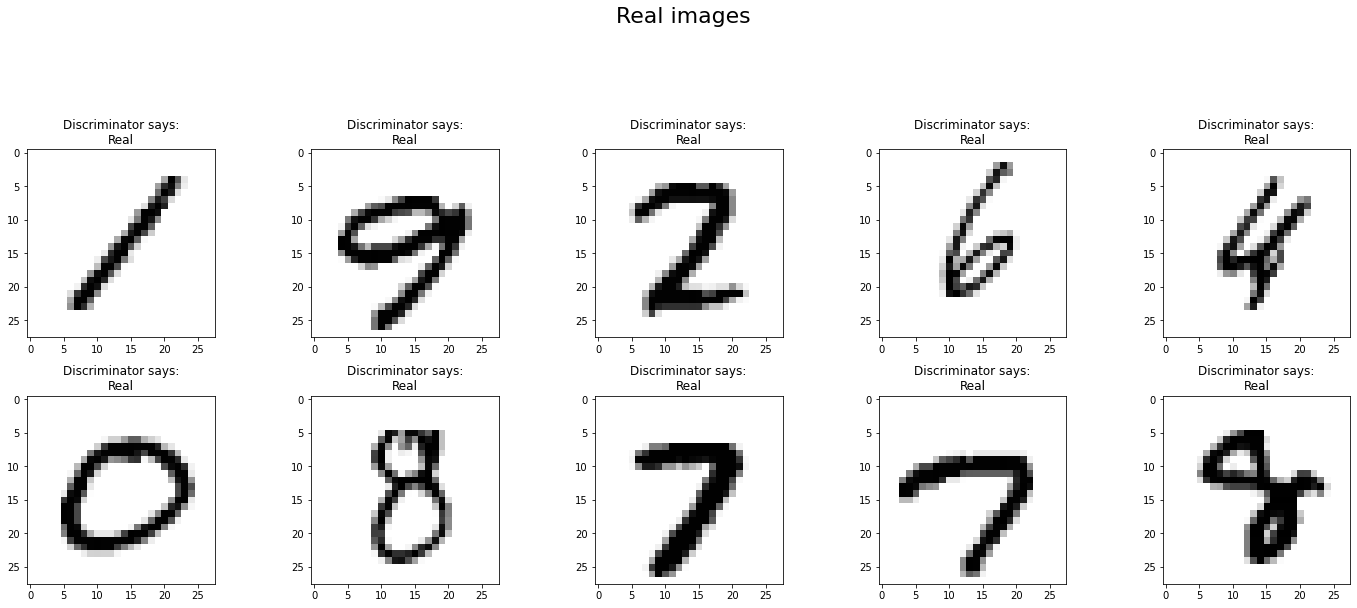

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.48333333333333334
El accuracy del generador es: 1.0


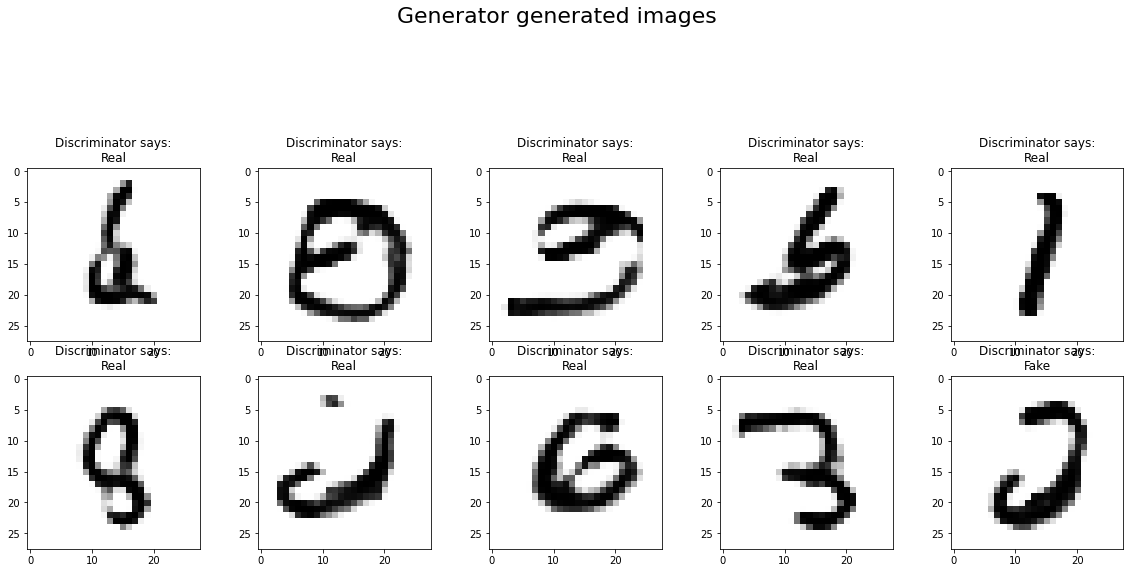

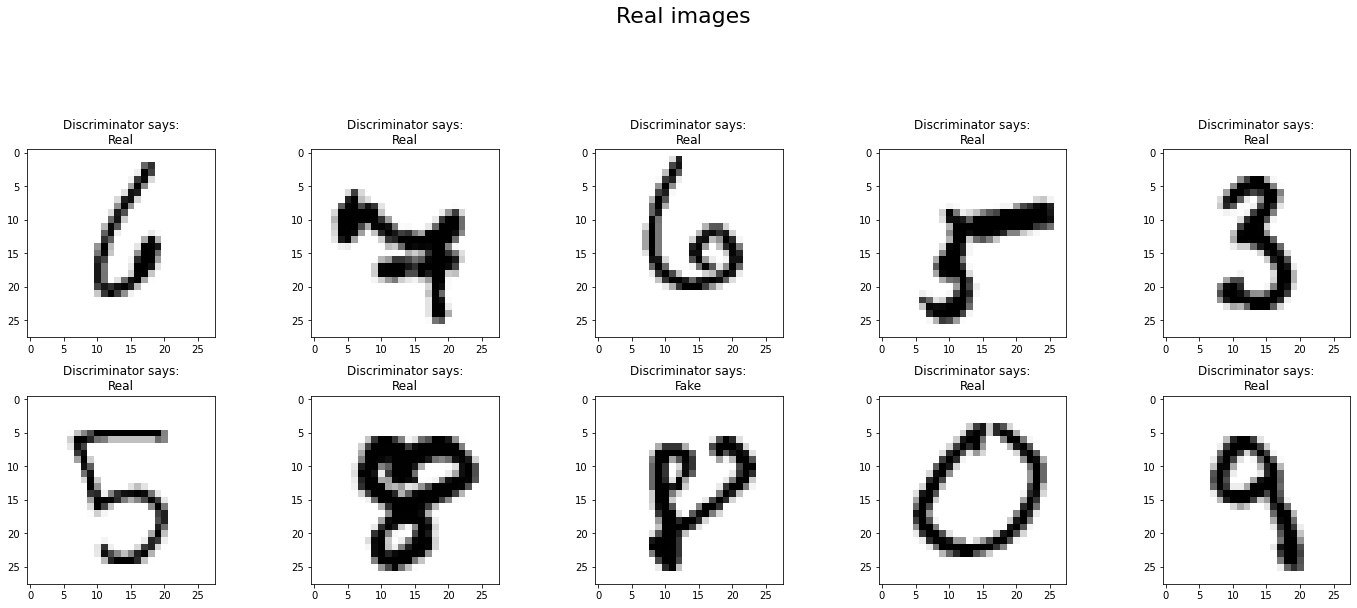

------------------------------------------------------------------------------------------------------------------------


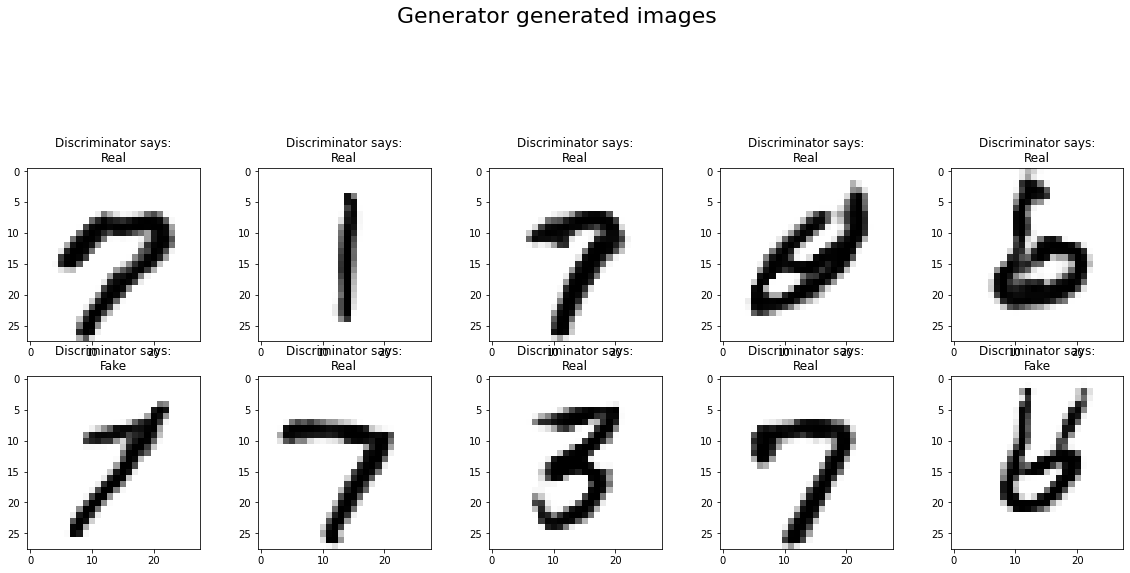

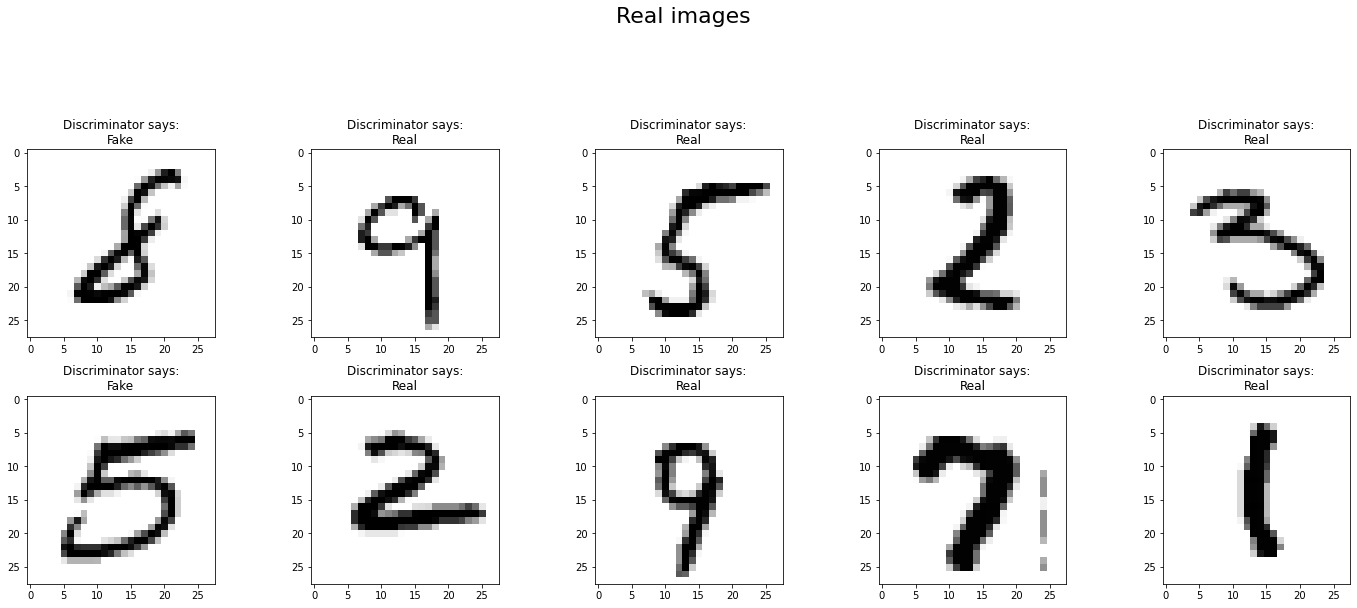

------------------------------------------------------------------------------------------------------------------------


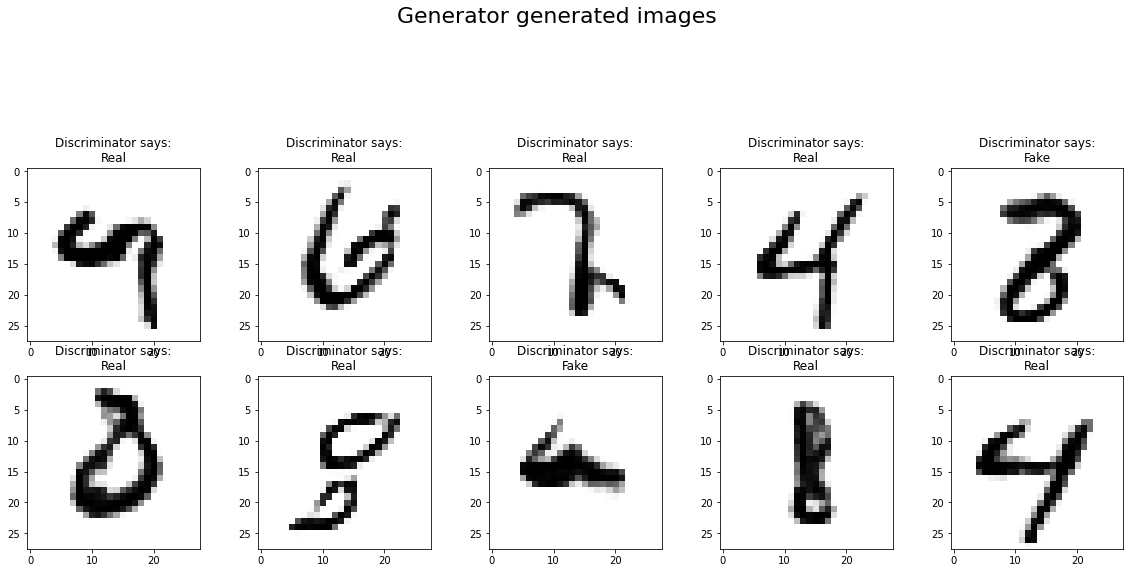

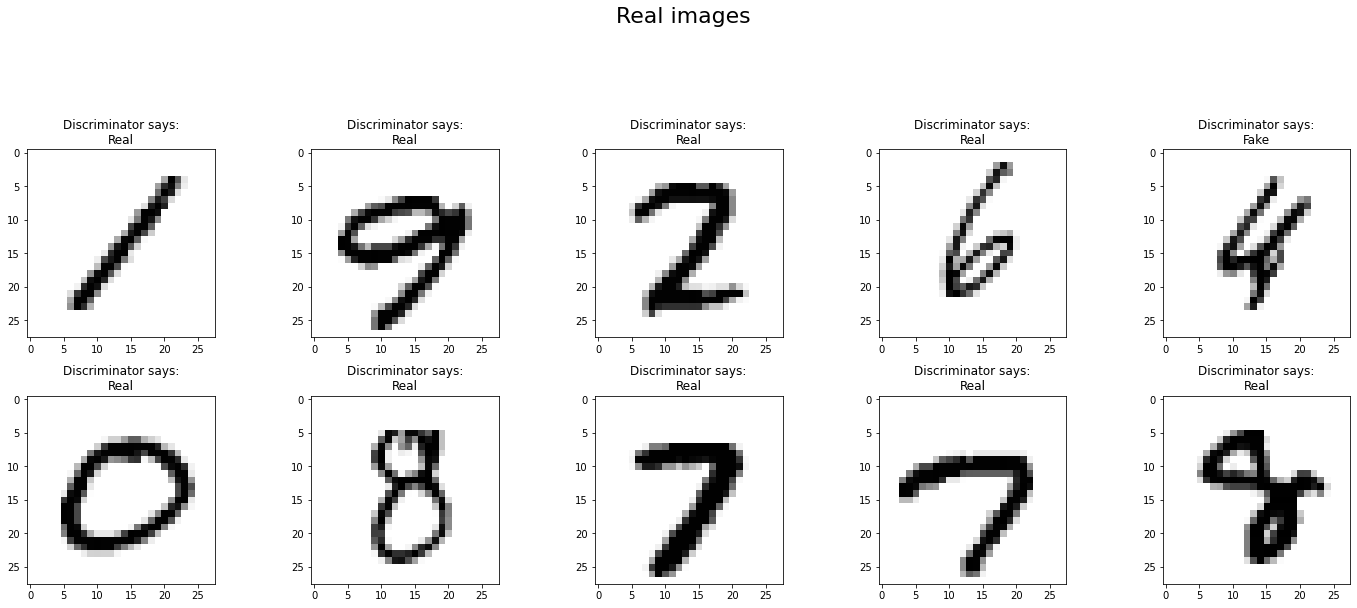

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.5166666666666667
El accuracy del generador es: 0.8333333333333334


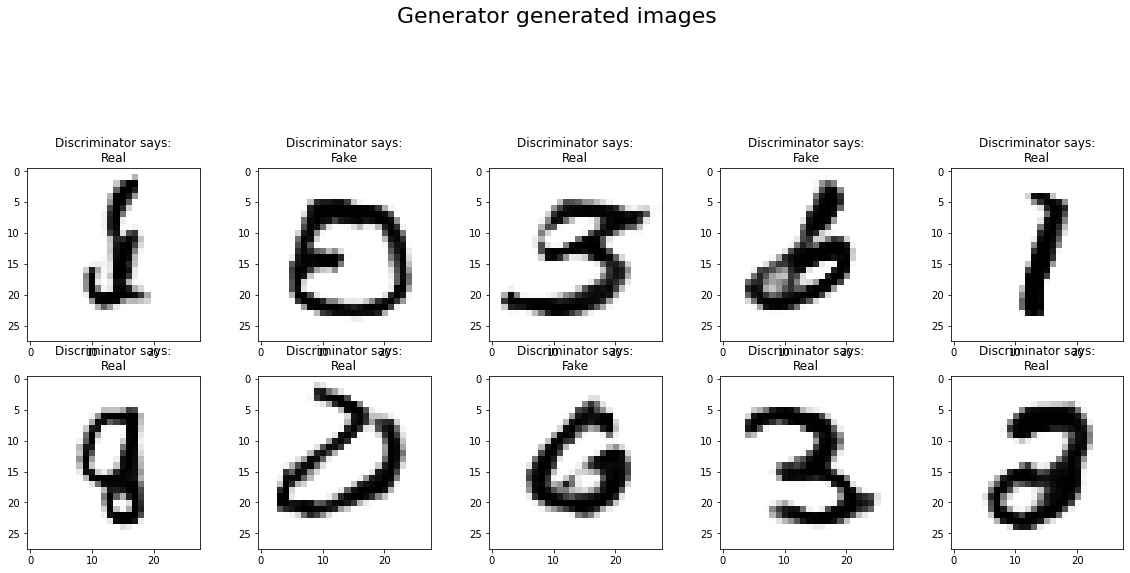

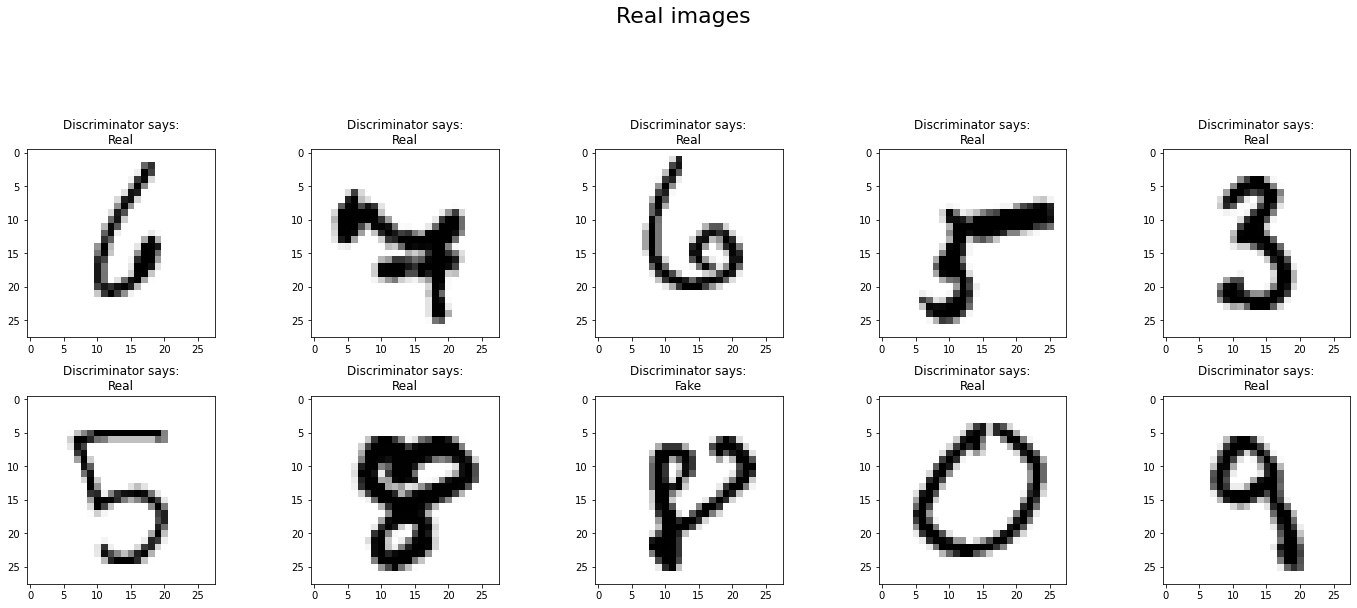

------------------------------------------------------------------------------------------------------------------------


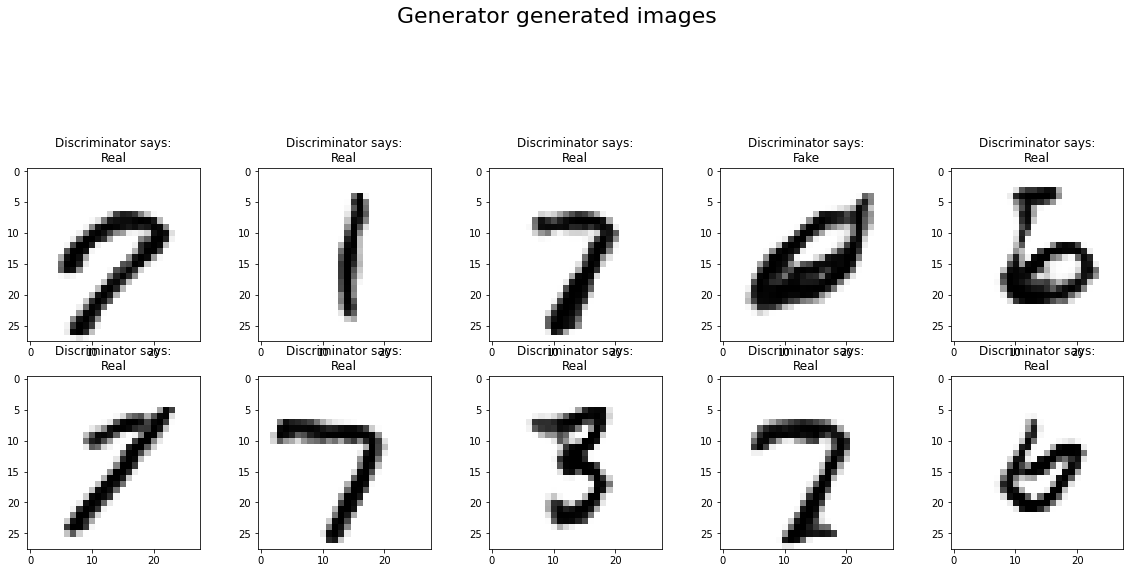

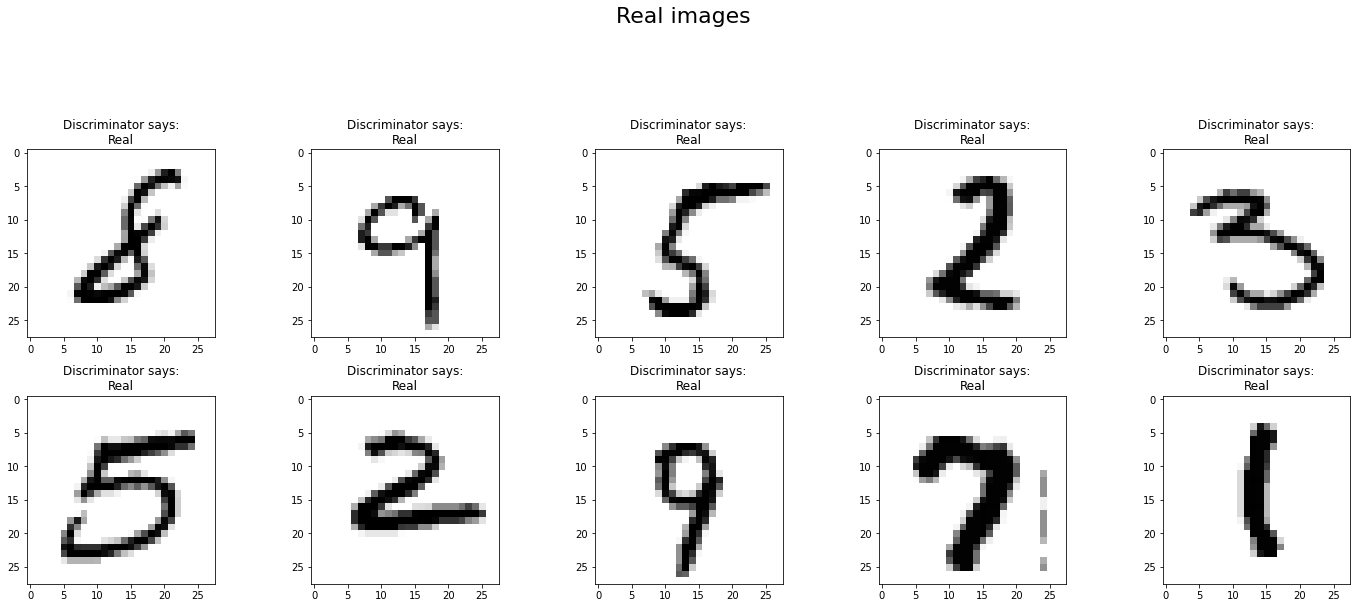

------------------------------------------------------------------------------------------------------------------------


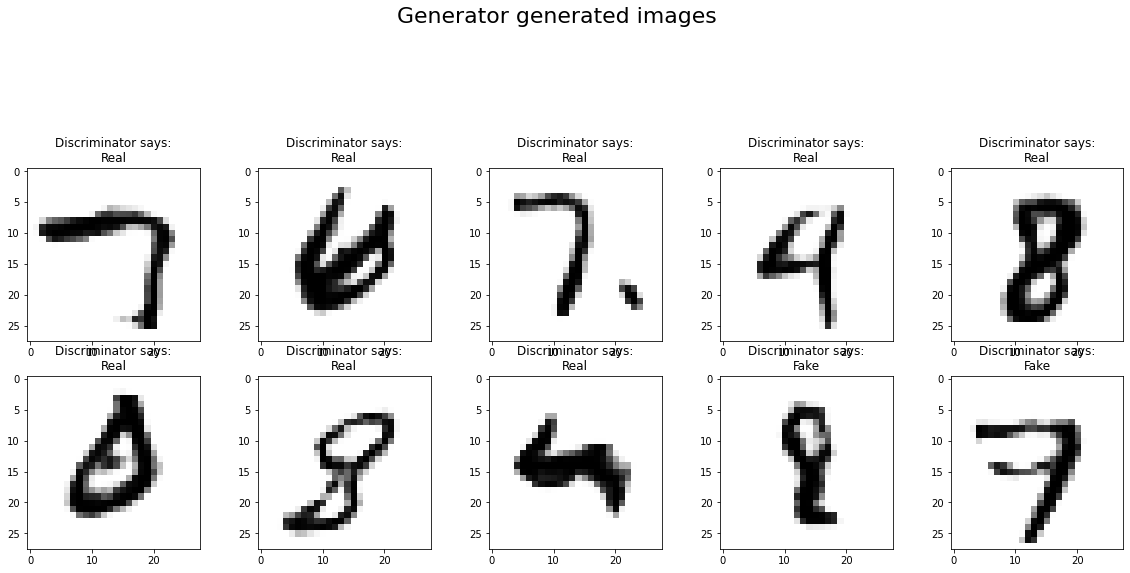

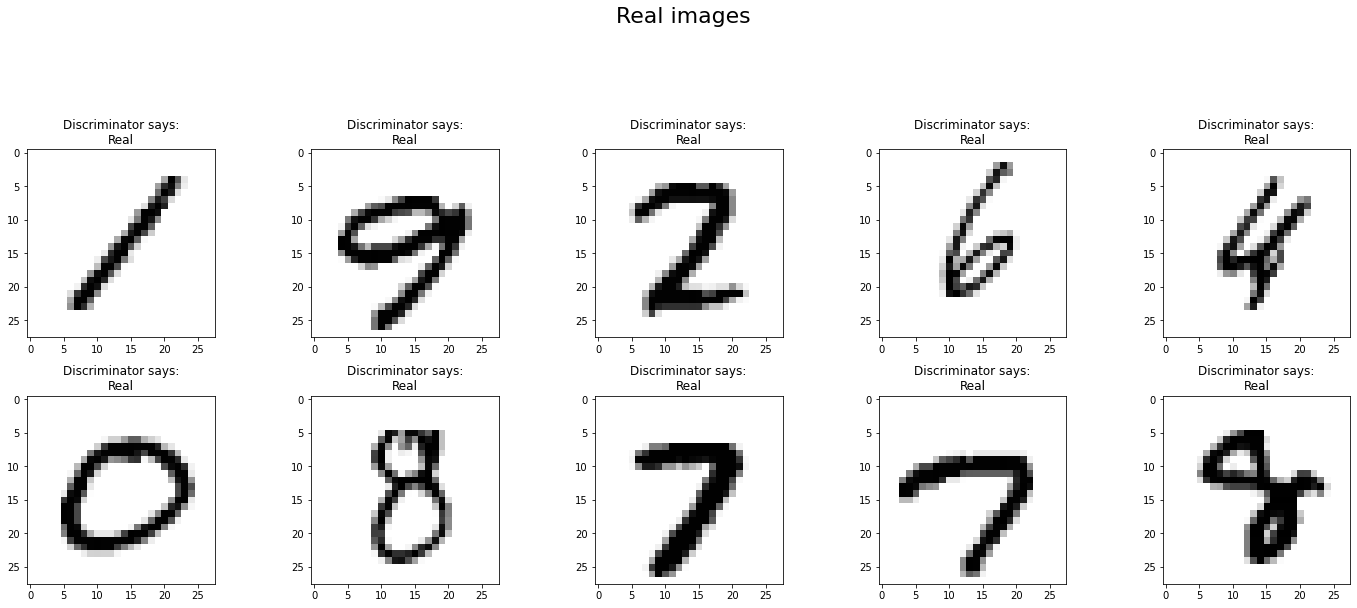

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.5833333333333334
El accuracy del generador es: 0.8


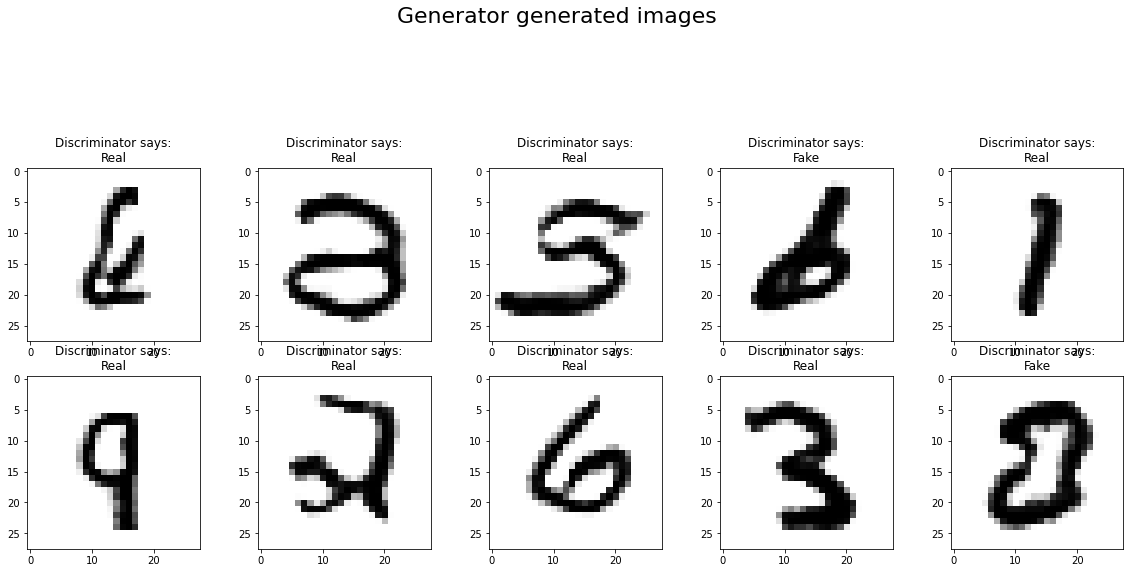

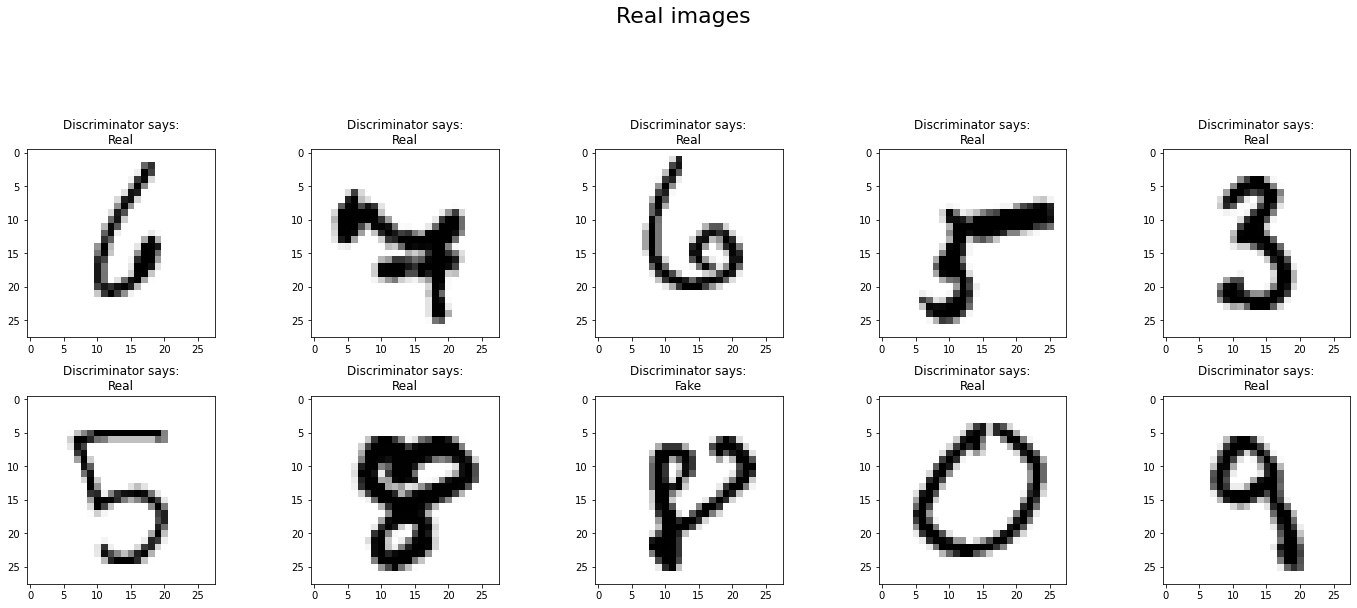

------------------------------------------------------------------------------------------------------------------------


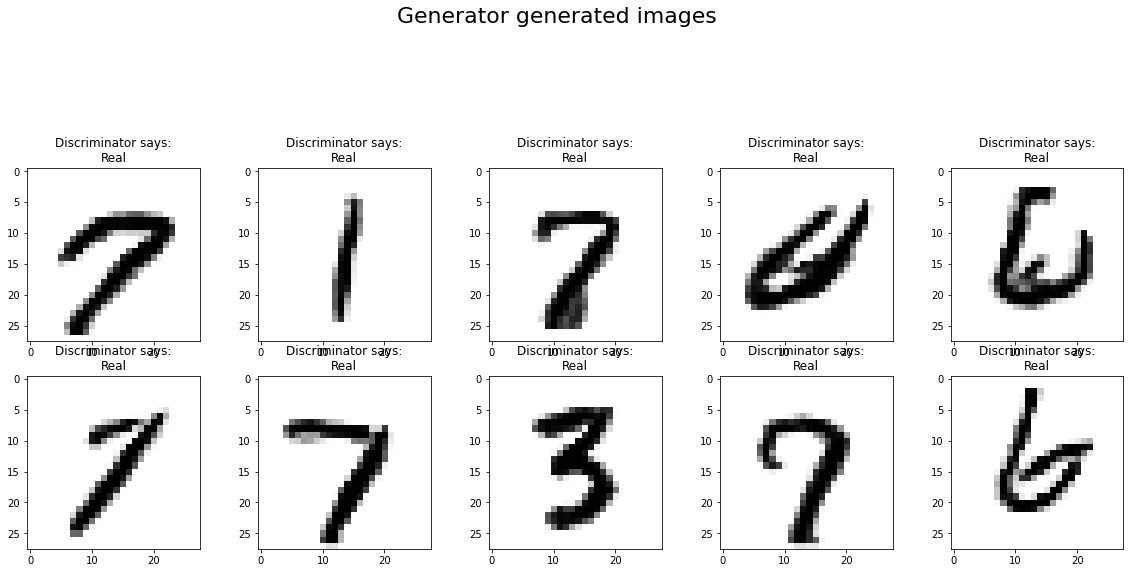

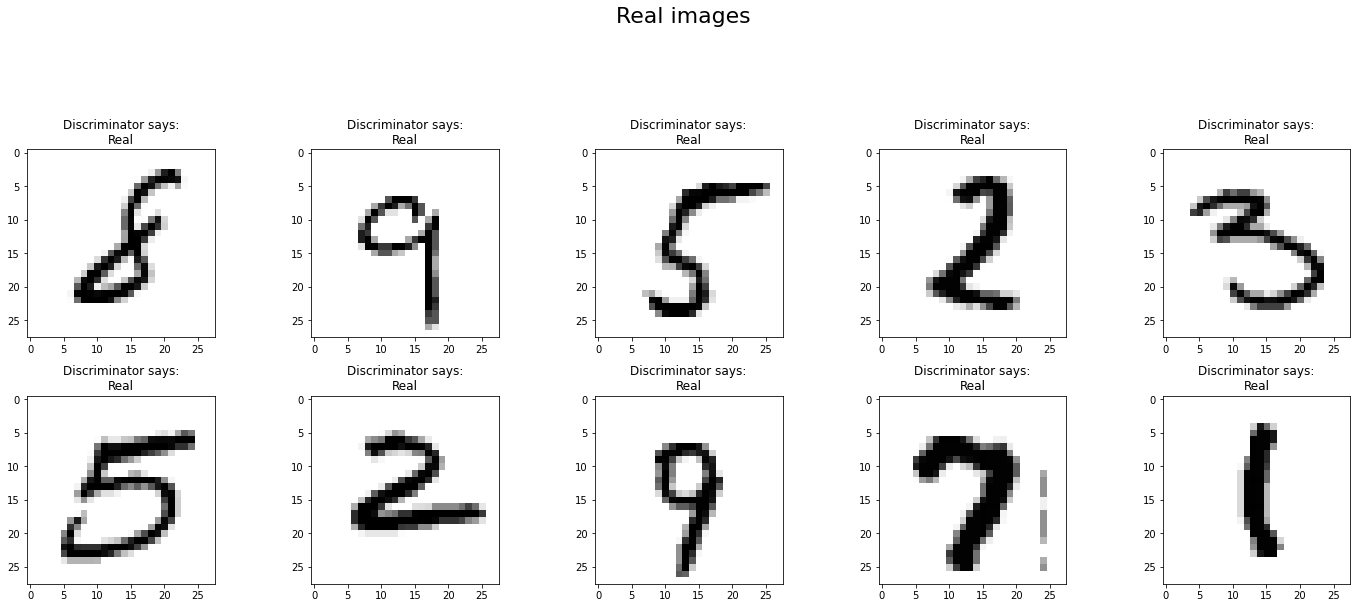

------------------------------------------------------------------------------------------------------------------------


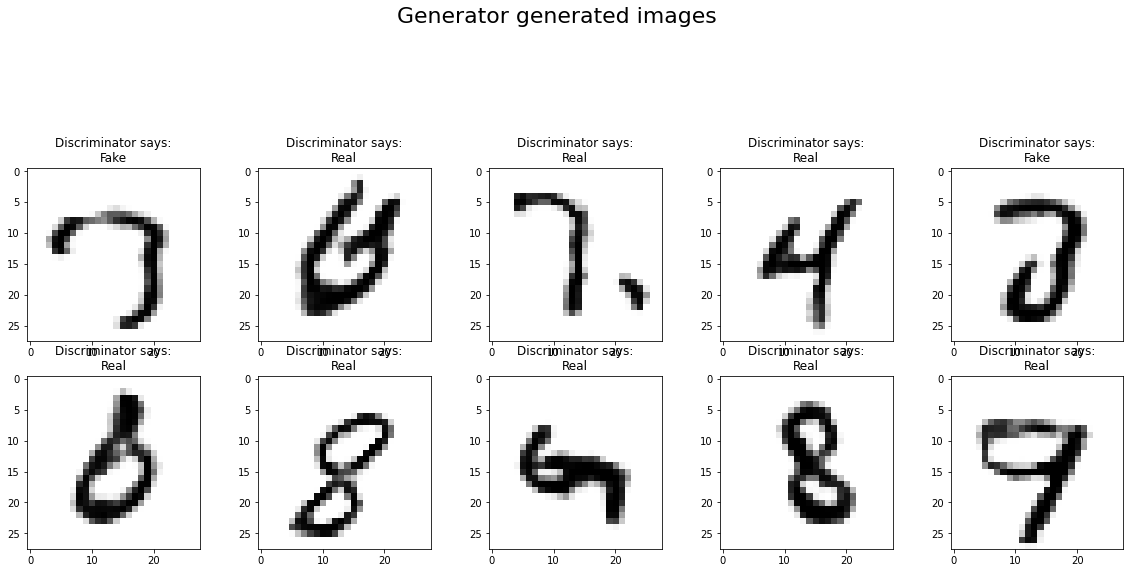

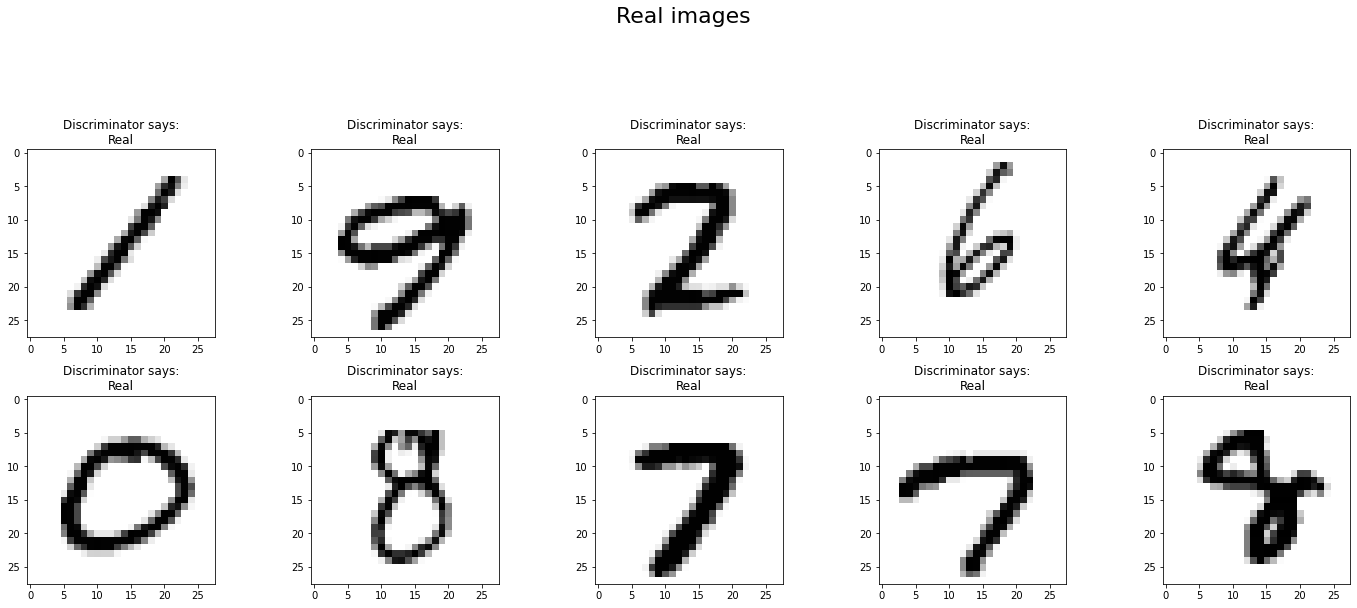

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.55
El accuracy del generador es: 0.8666666666666667


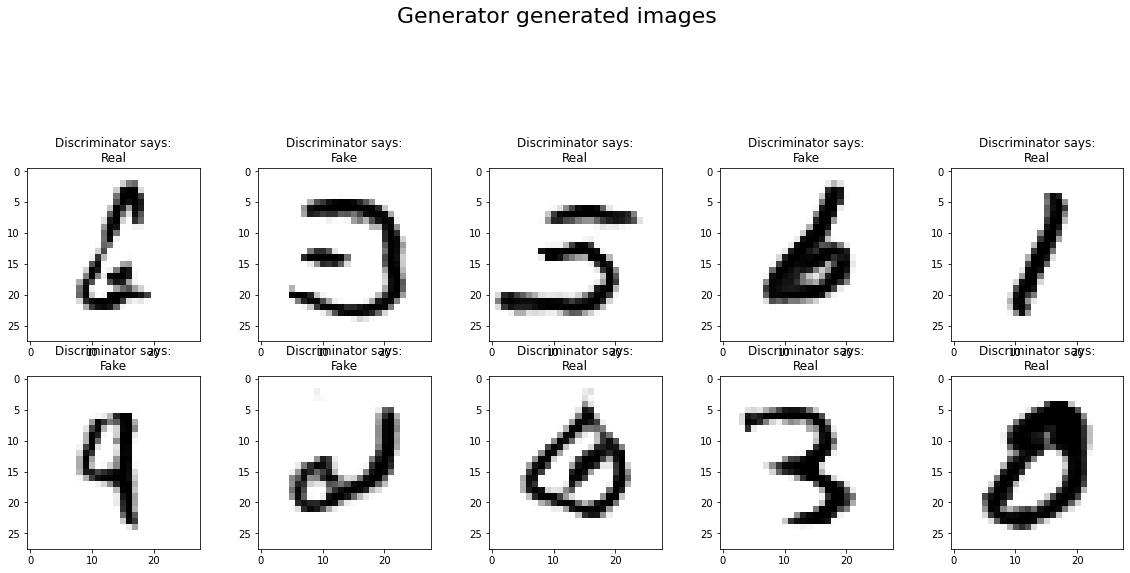

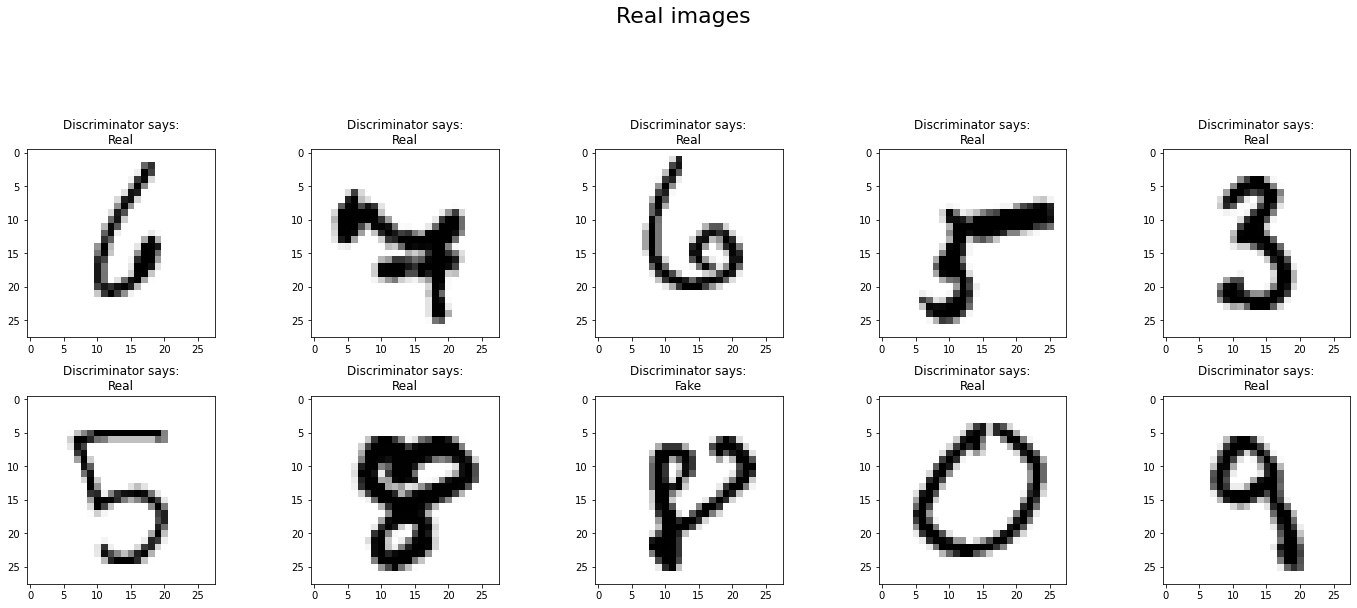

------------------------------------------------------------------------------------------------------------------------


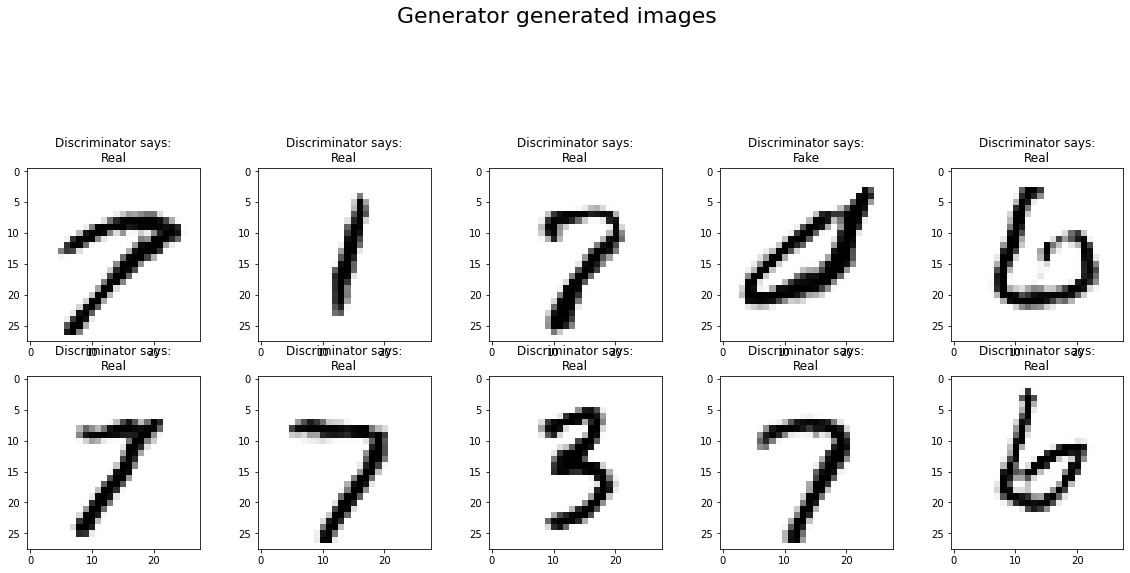

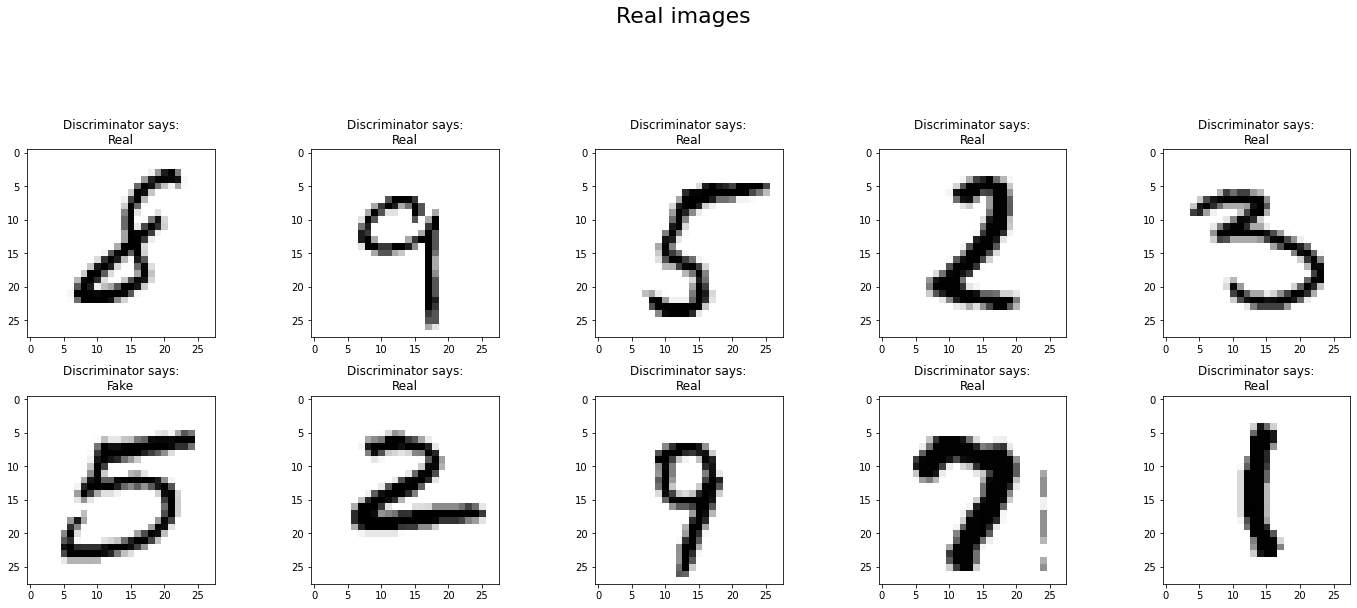

------------------------------------------------------------------------------------------------------------------------


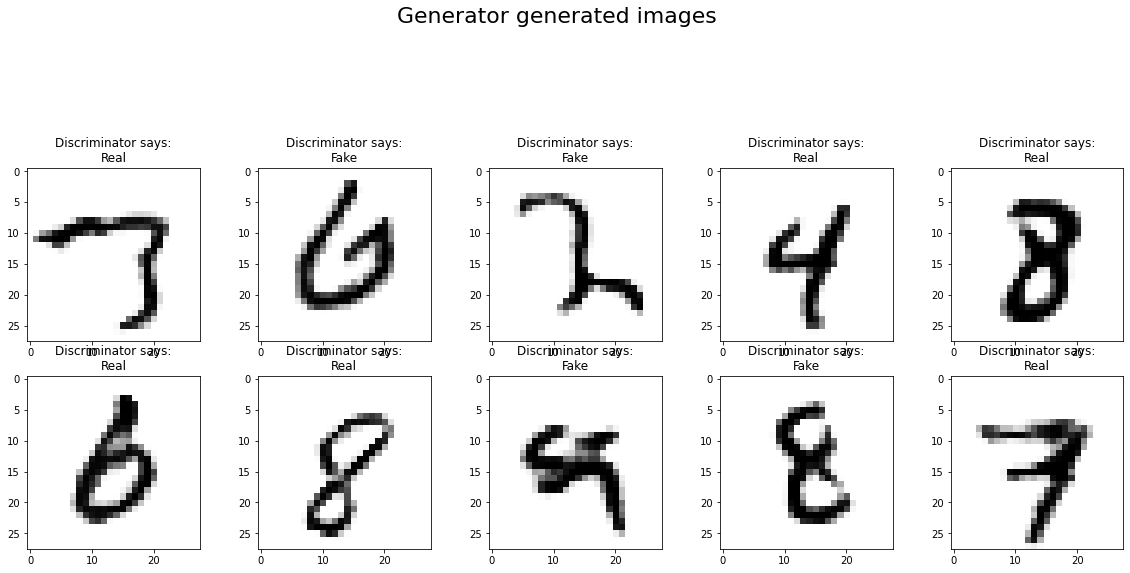

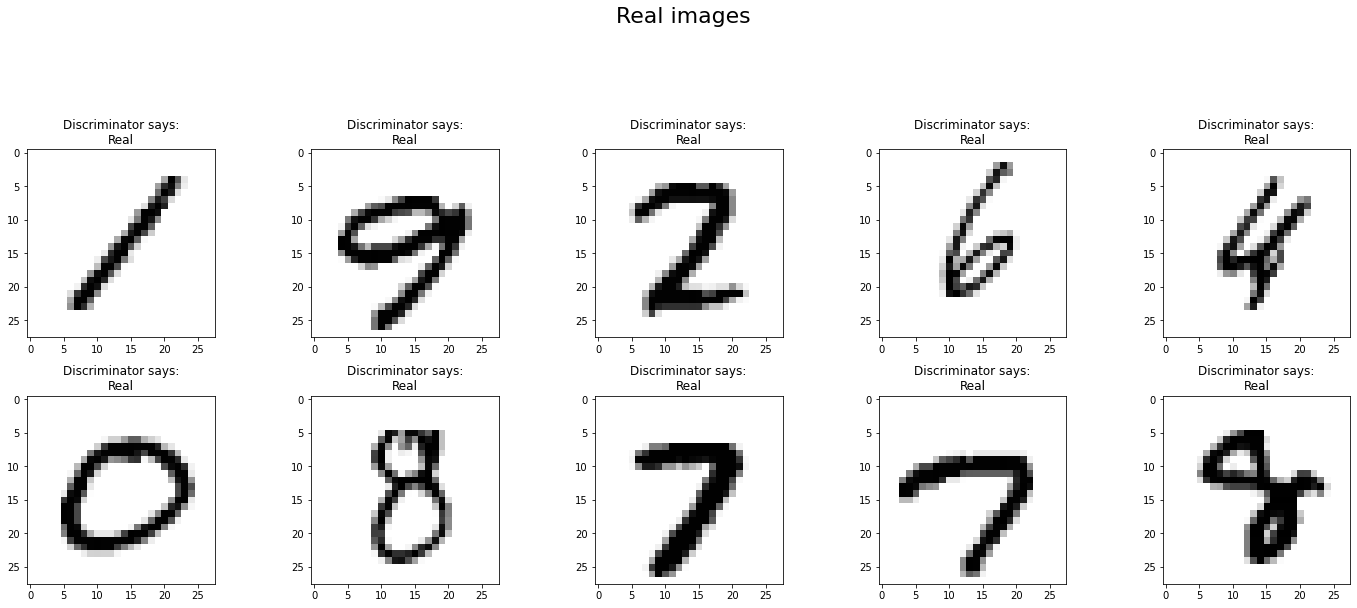

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.6166666666666667
El accuracy del generador es: 0.7


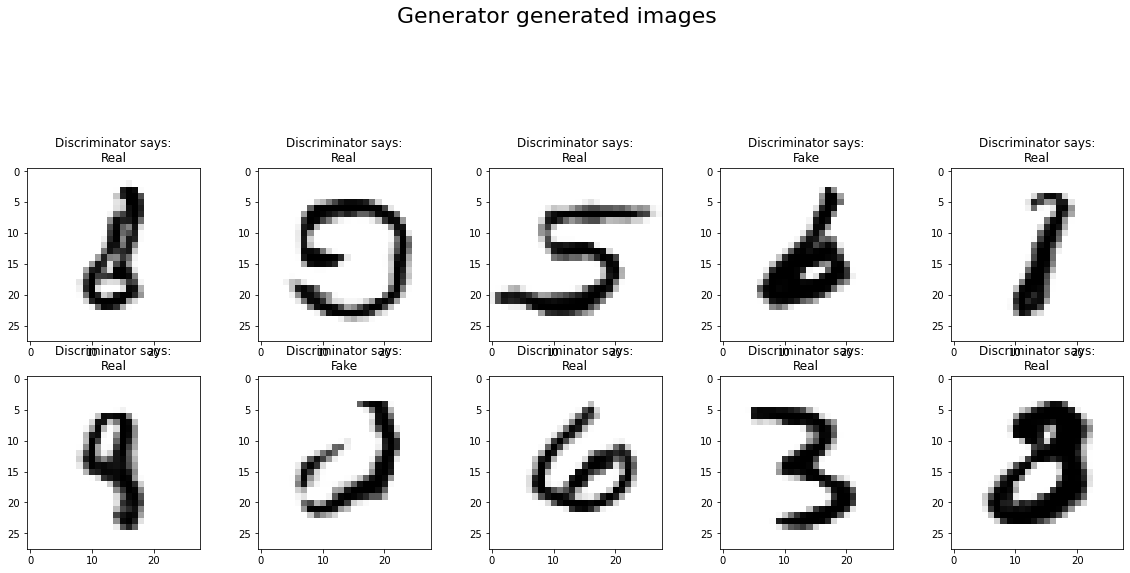

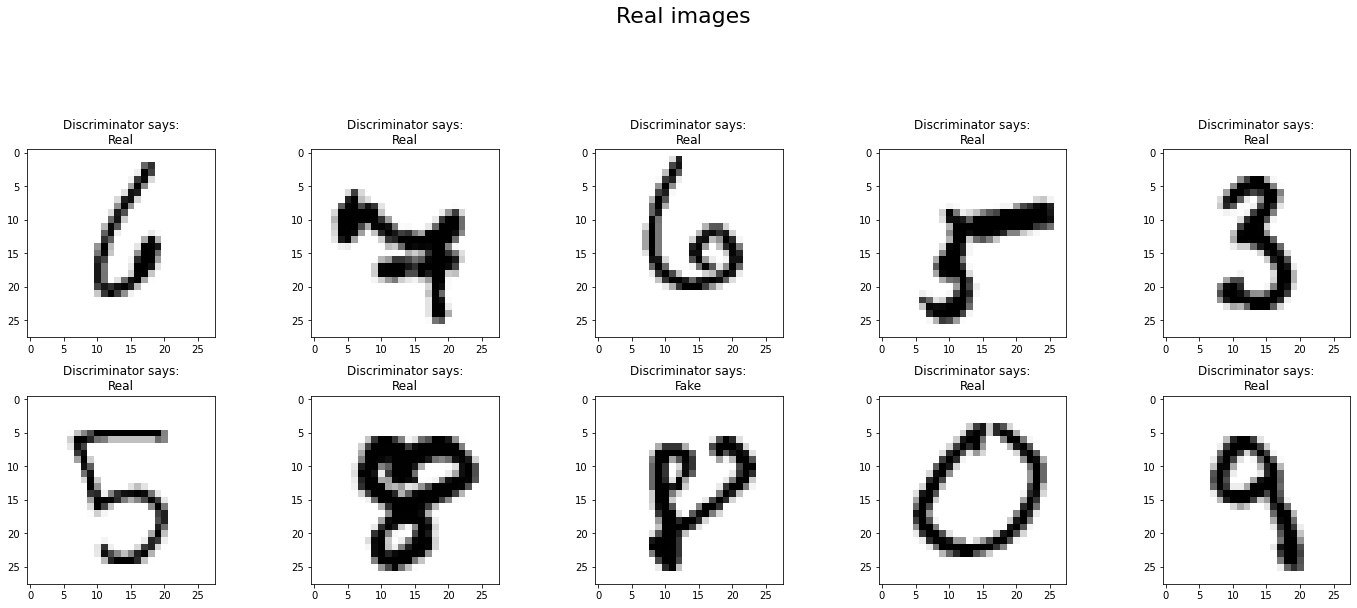

------------------------------------------------------------------------------------------------------------------------


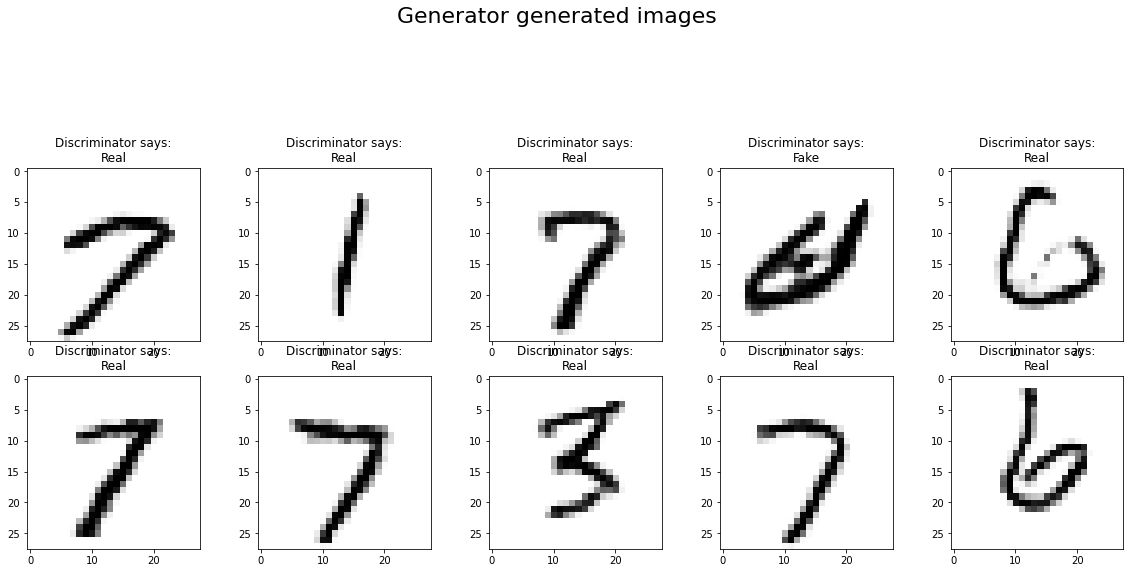

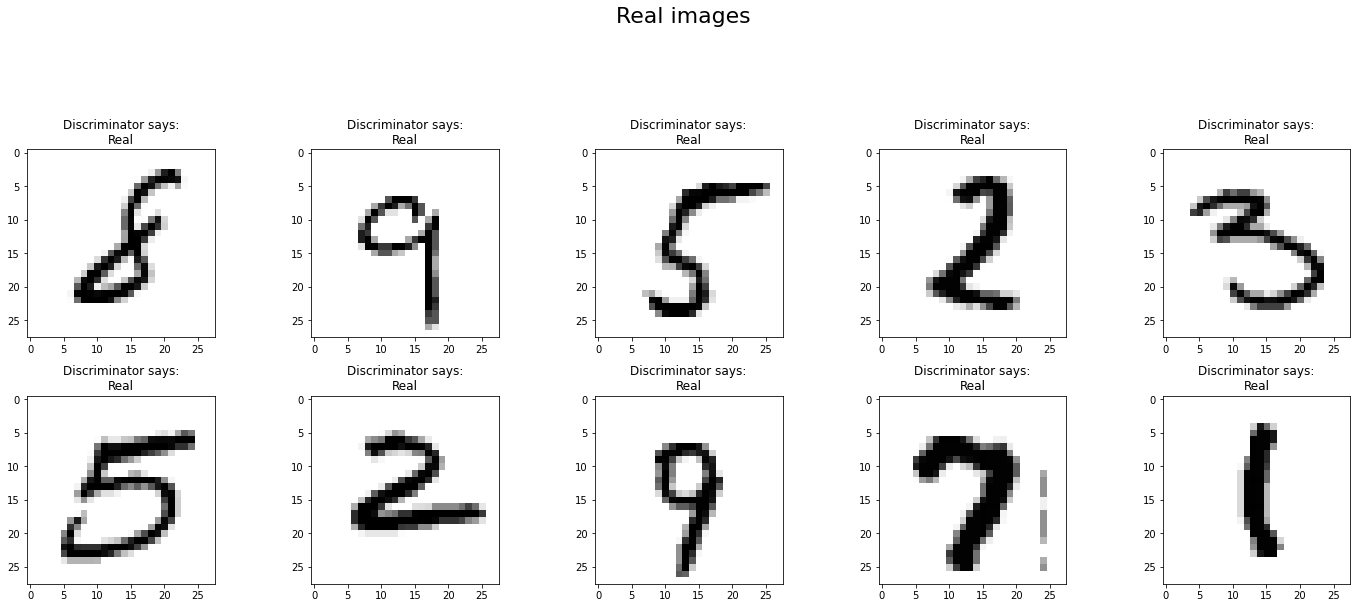

------------------------------------------------------------------------------------------------------------------------


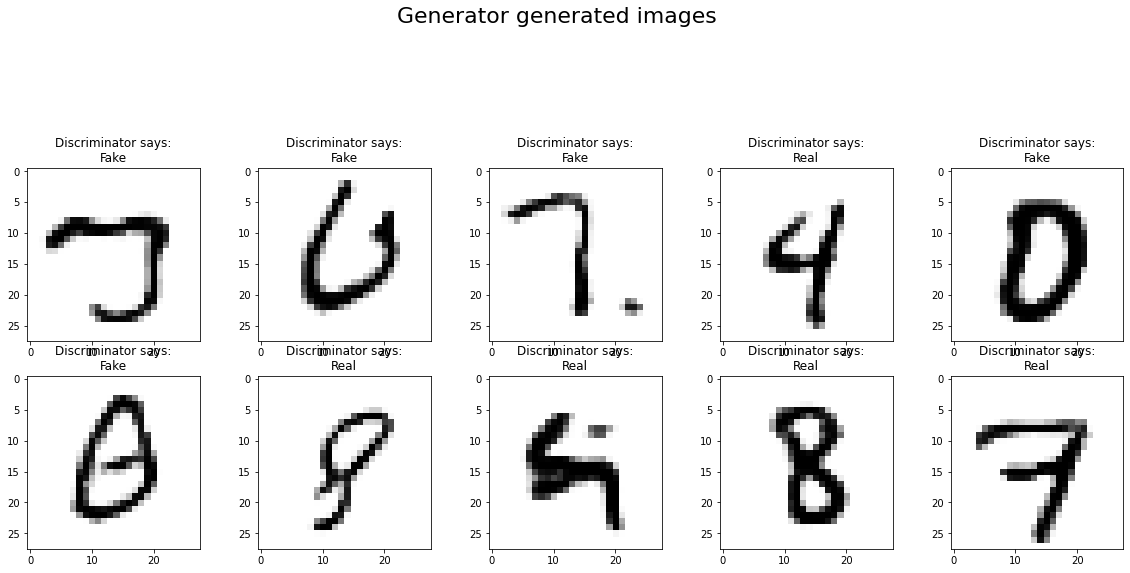

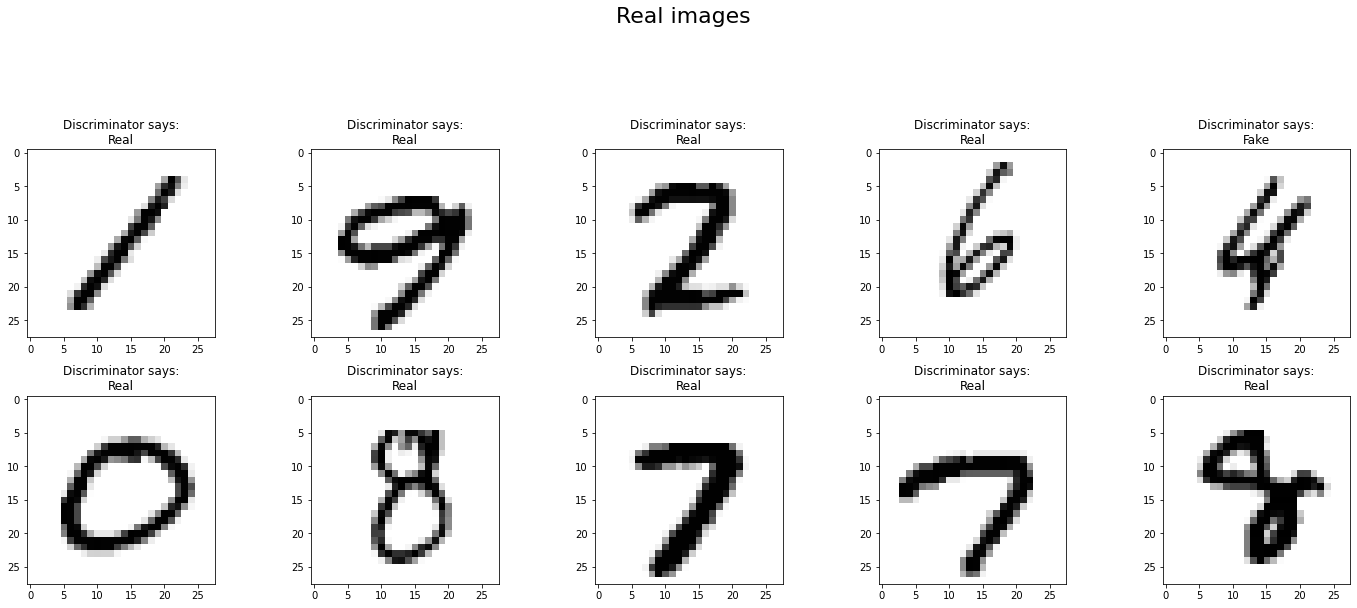

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.6
El accuracy del generador es: 0.7333333333333334


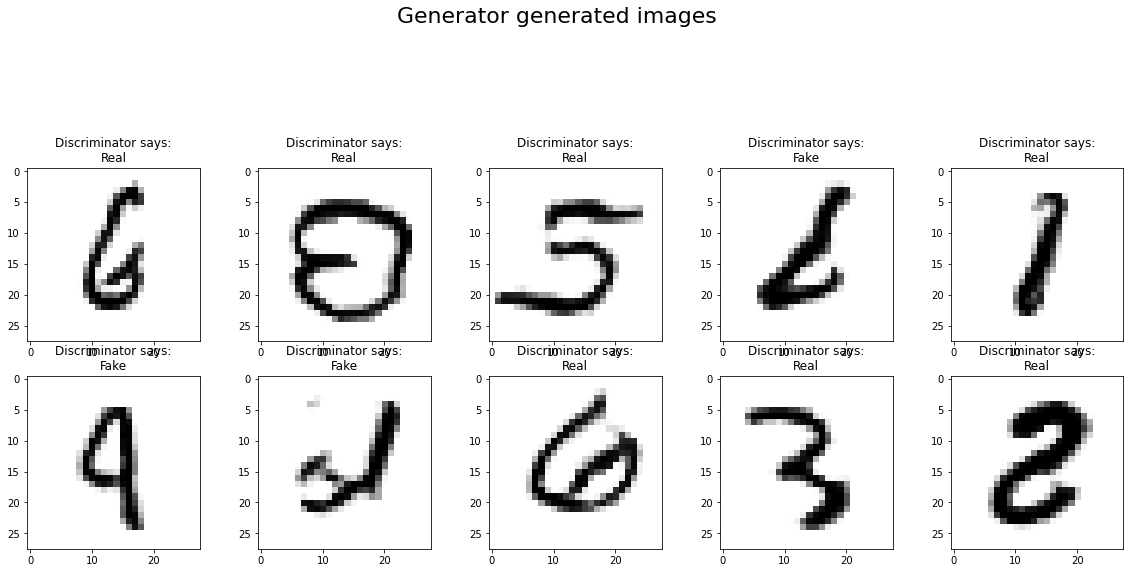

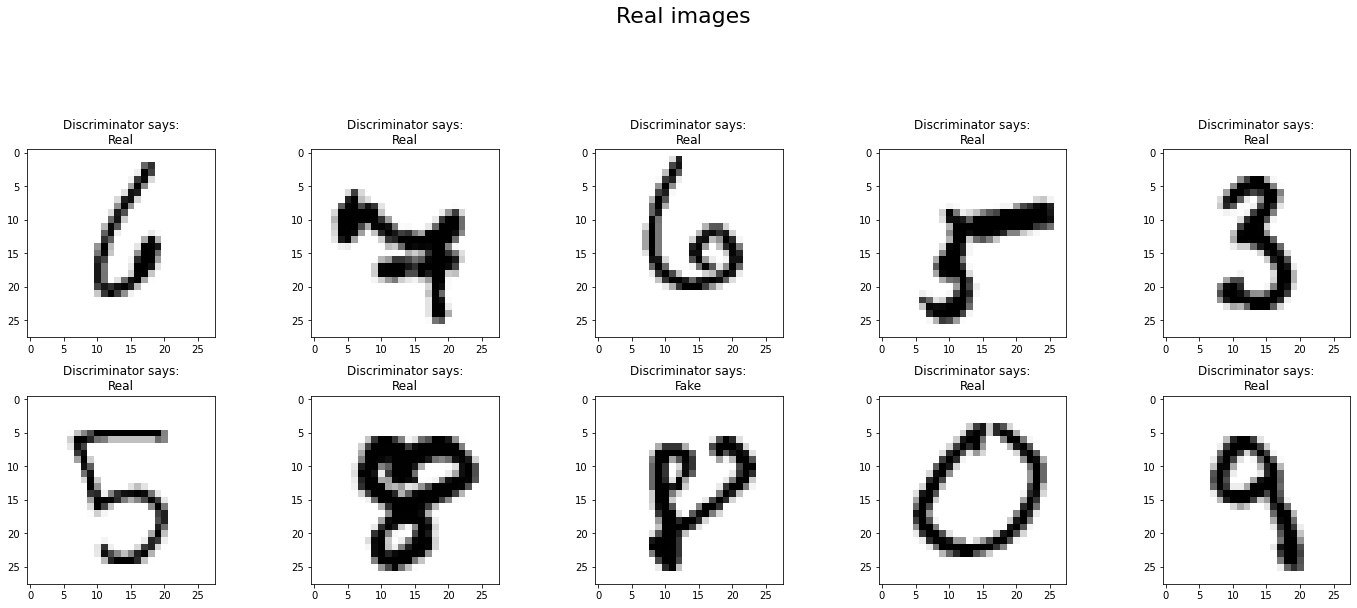

------------------------------------------------------------------------------------------------------------------------


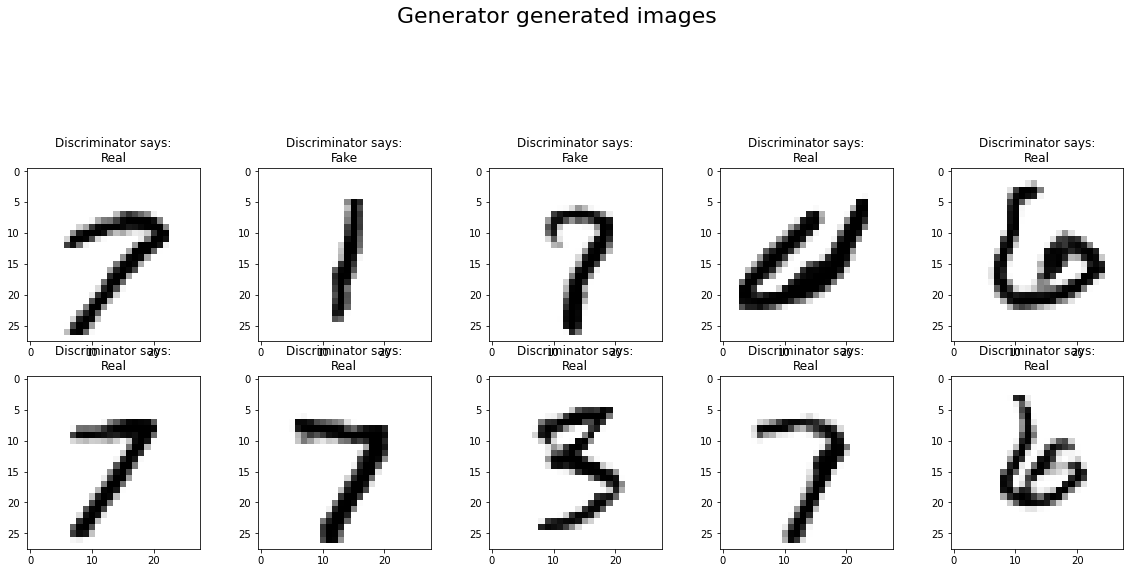

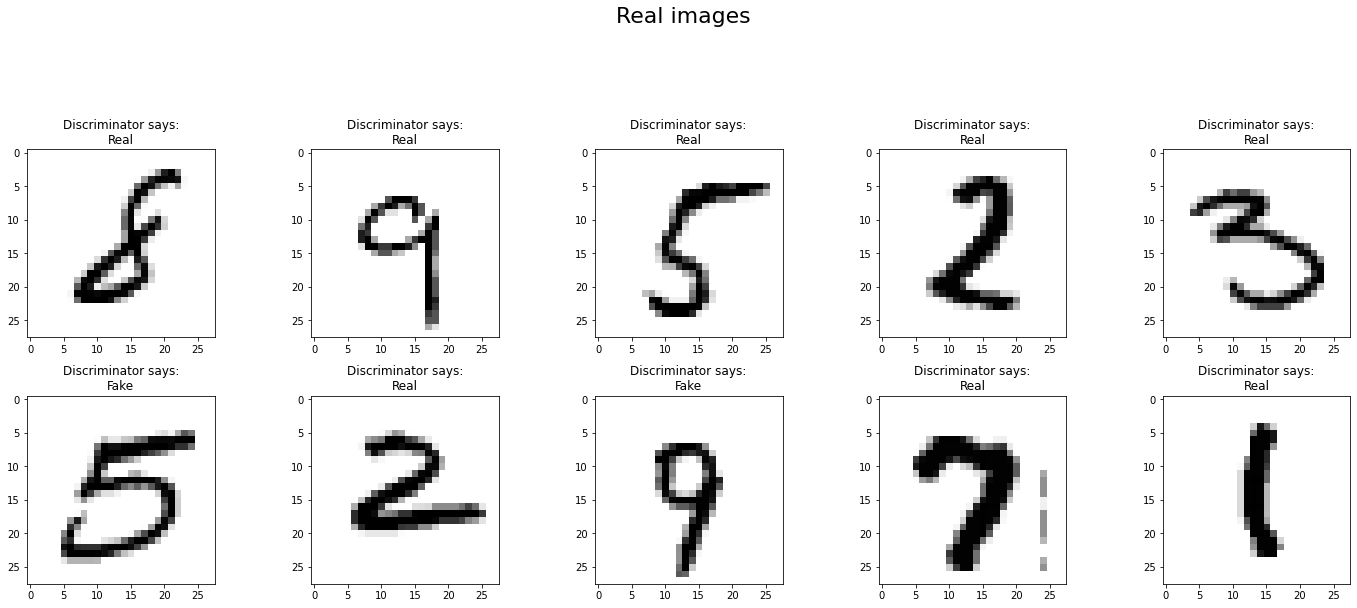

------------------------------------------------------------------------------------------------------------------------


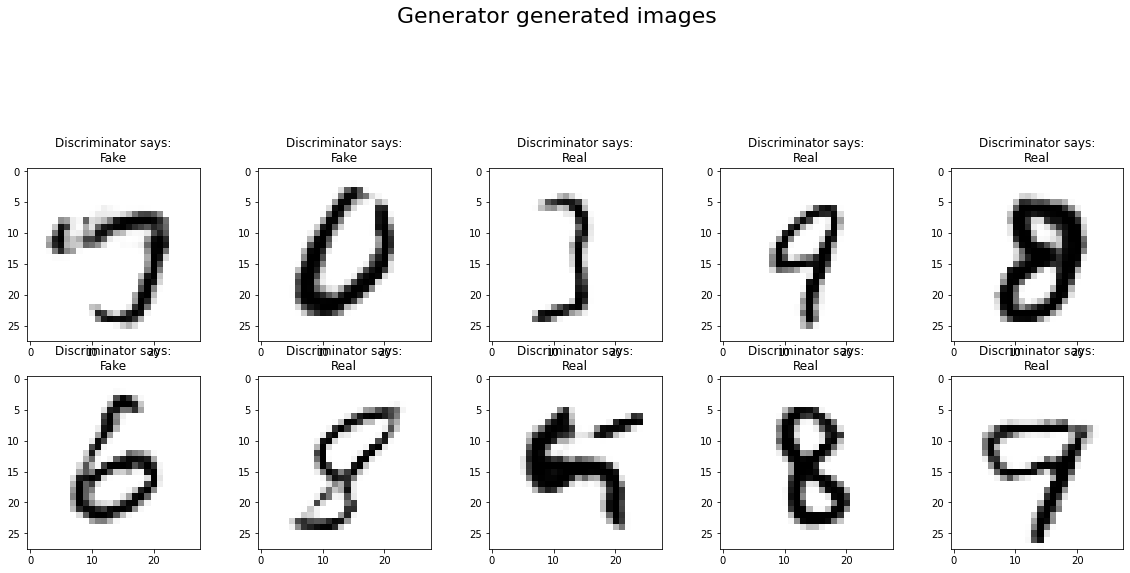

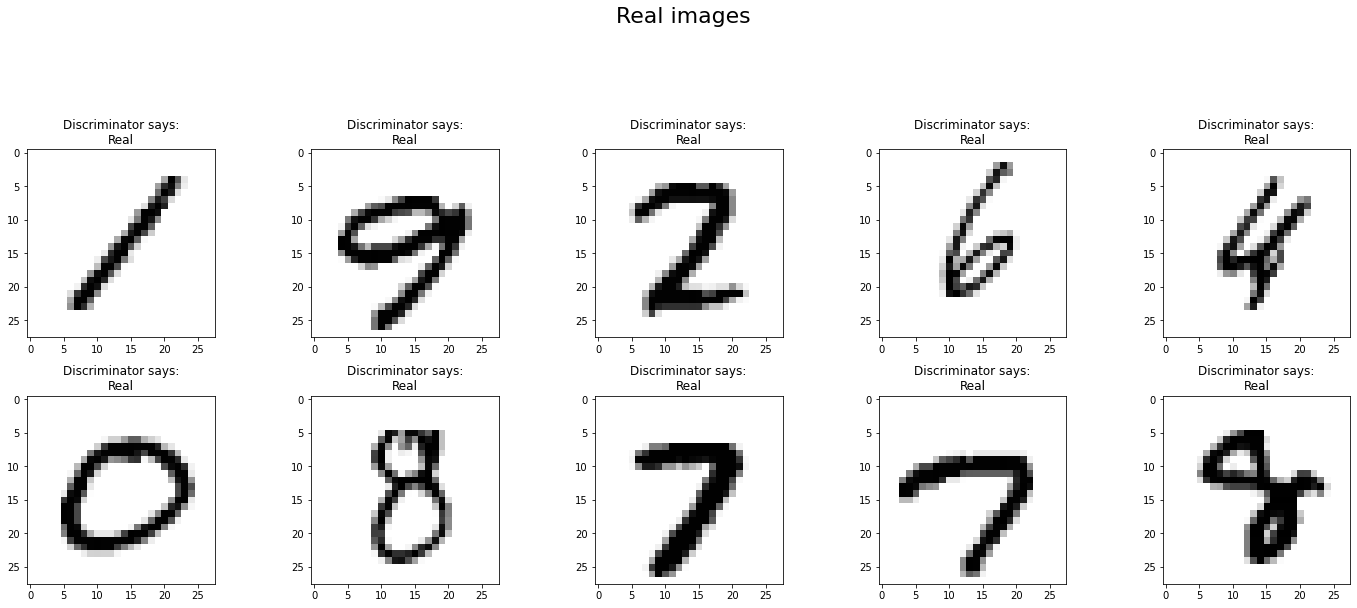

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.5833333333333334
El accuracy del generador es: 0.7333333333333334


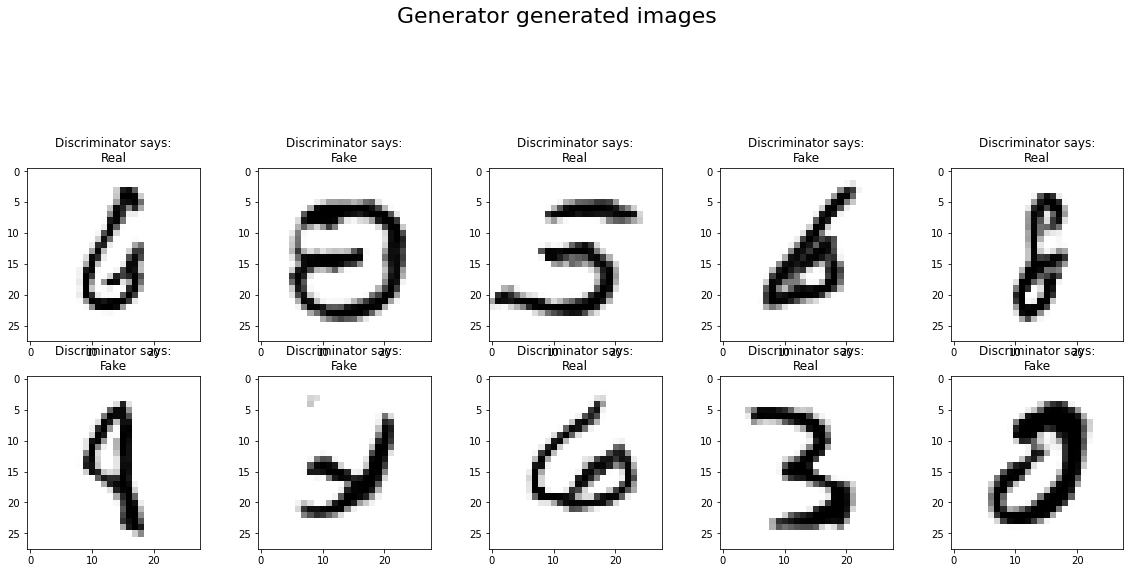

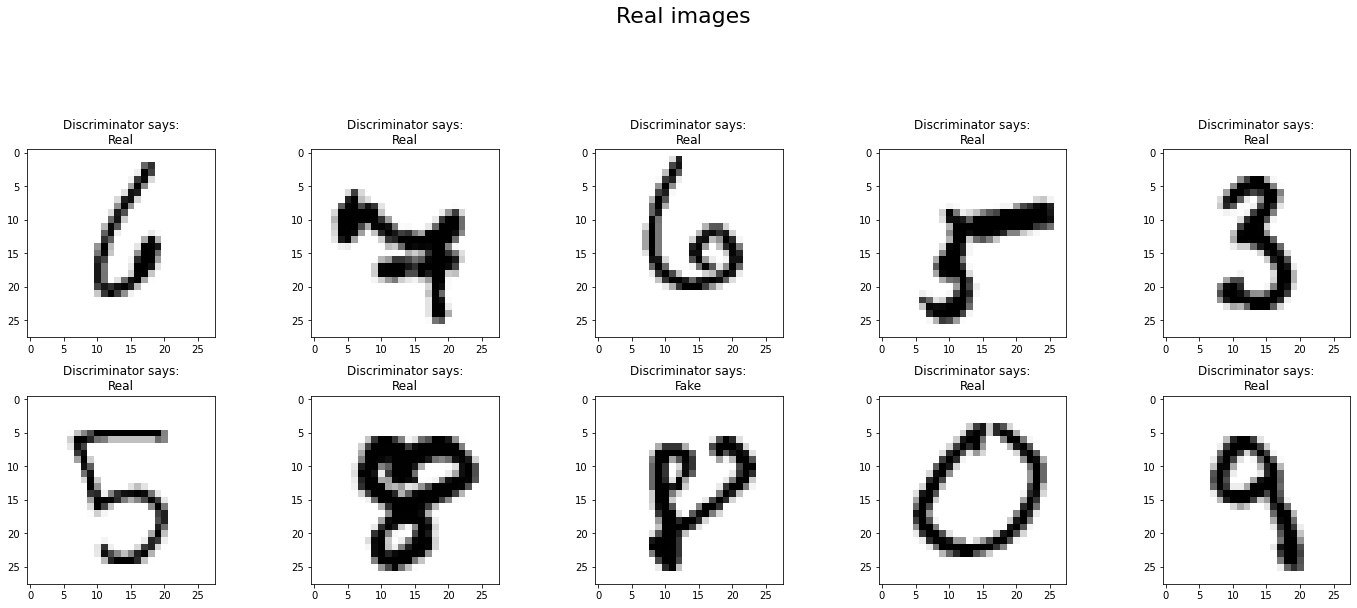

------------------------------------------------------------------------------------------------------------------------


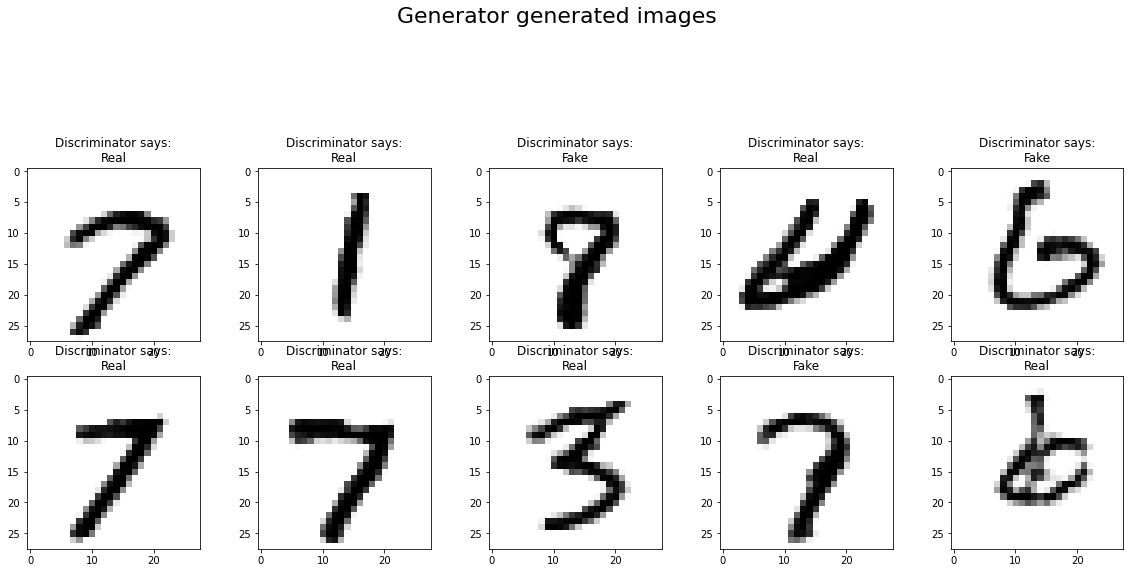

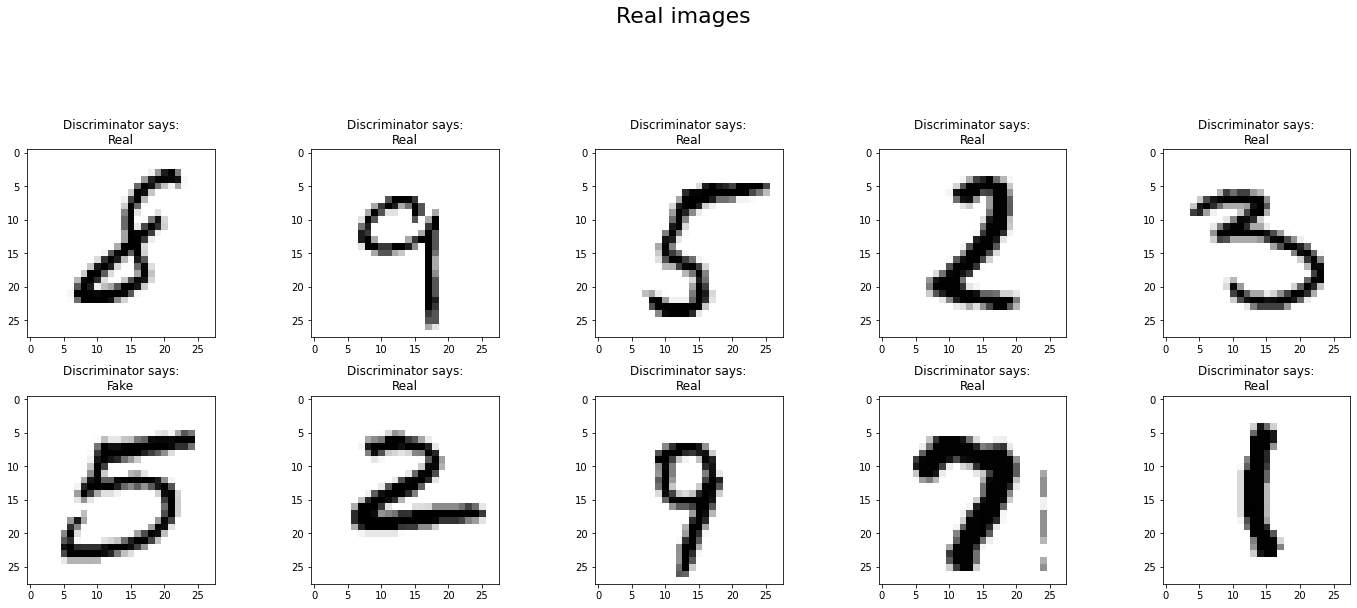

------------------------------------------------------------------------------------------------------------------------


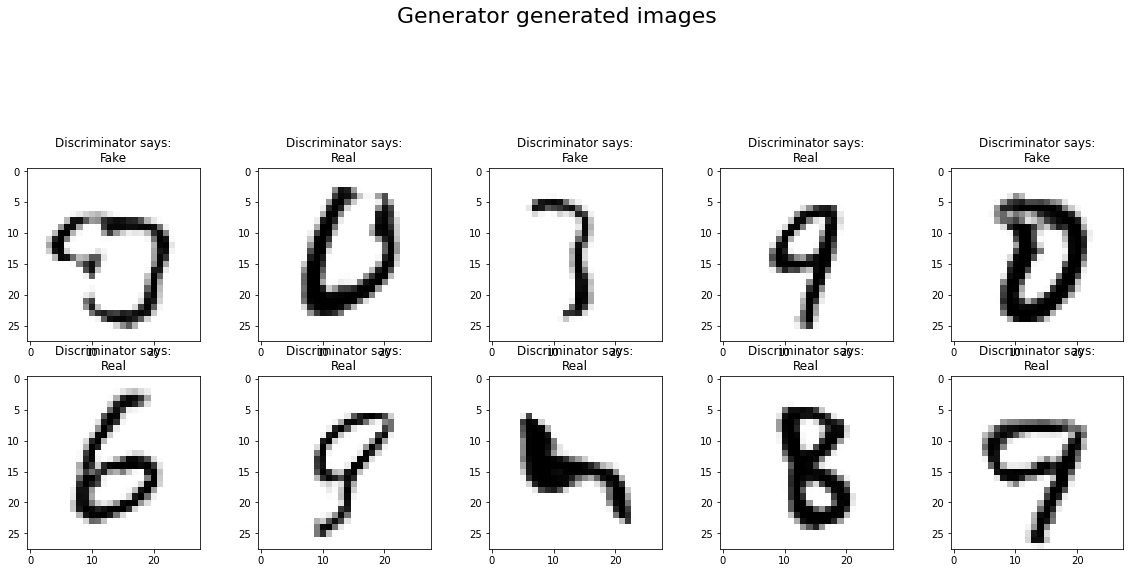

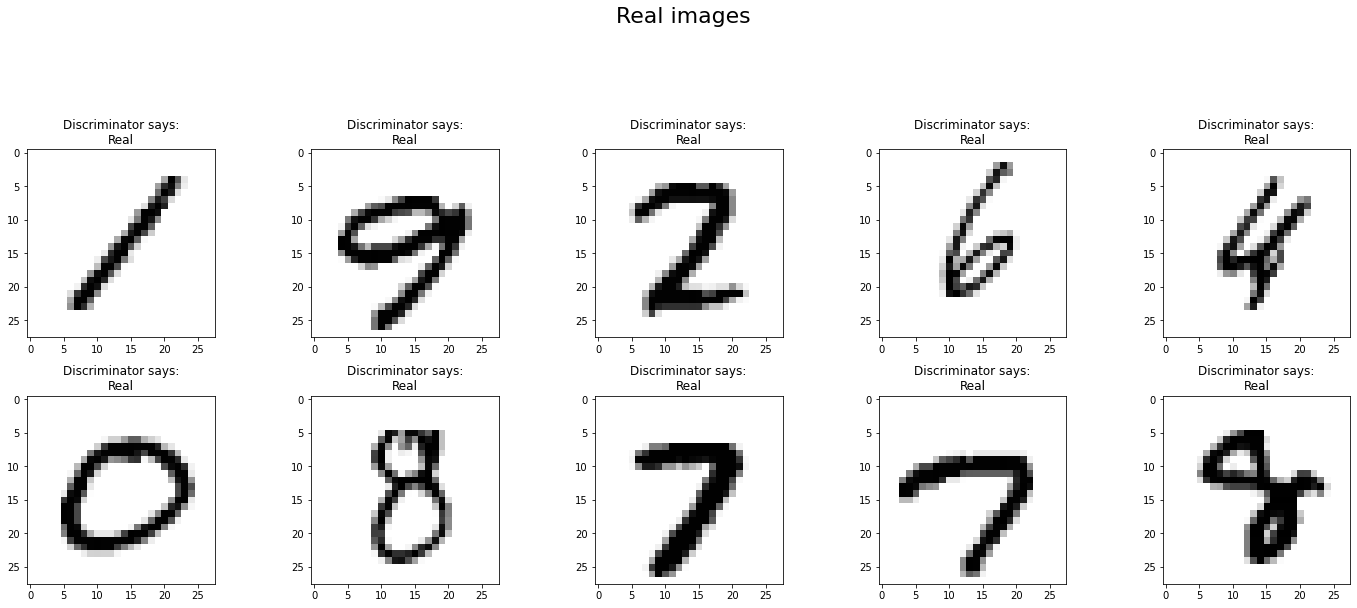

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.65
El accuracy del generador es: 0.6333333333333333


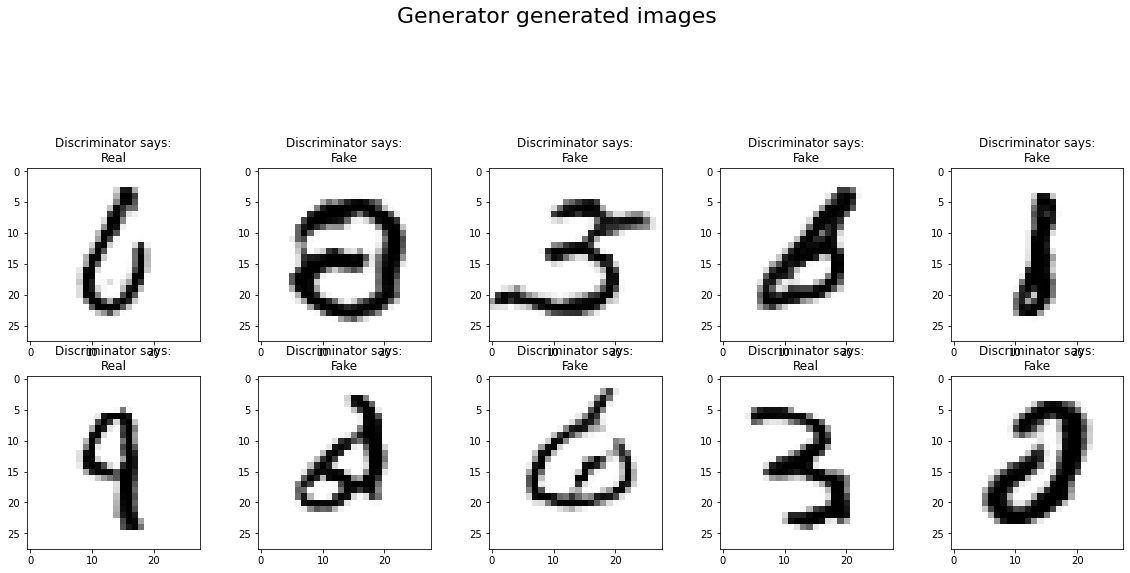

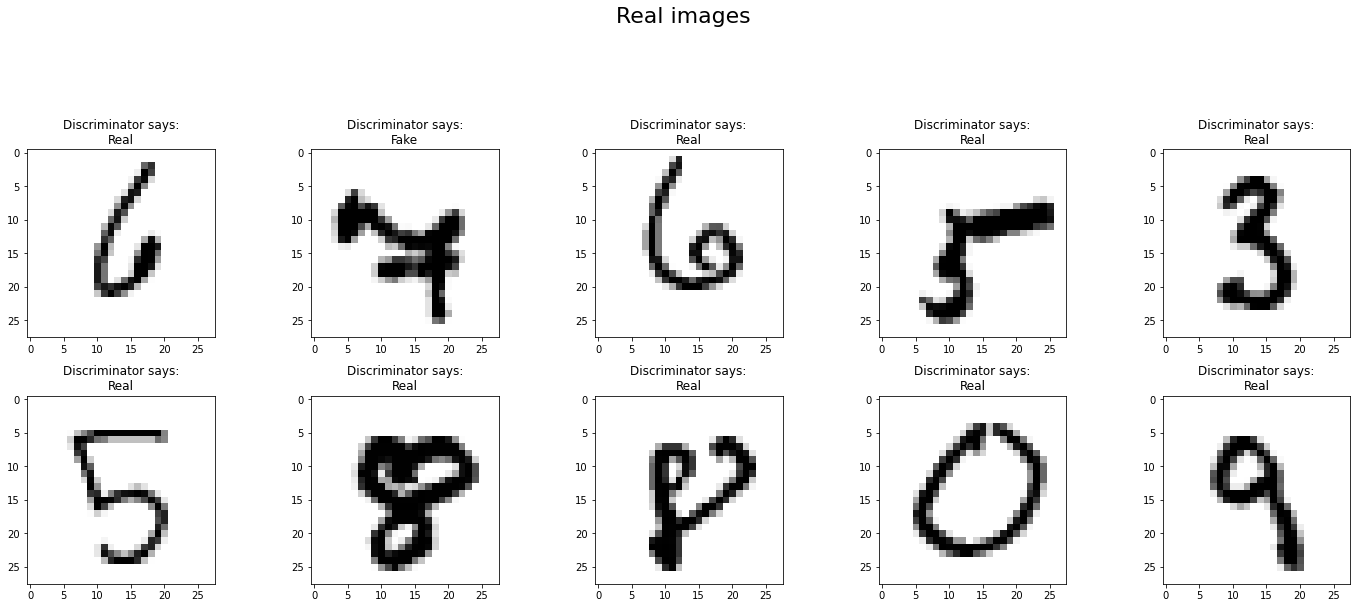

------------------------------------------------------------------------------------------------------------------------


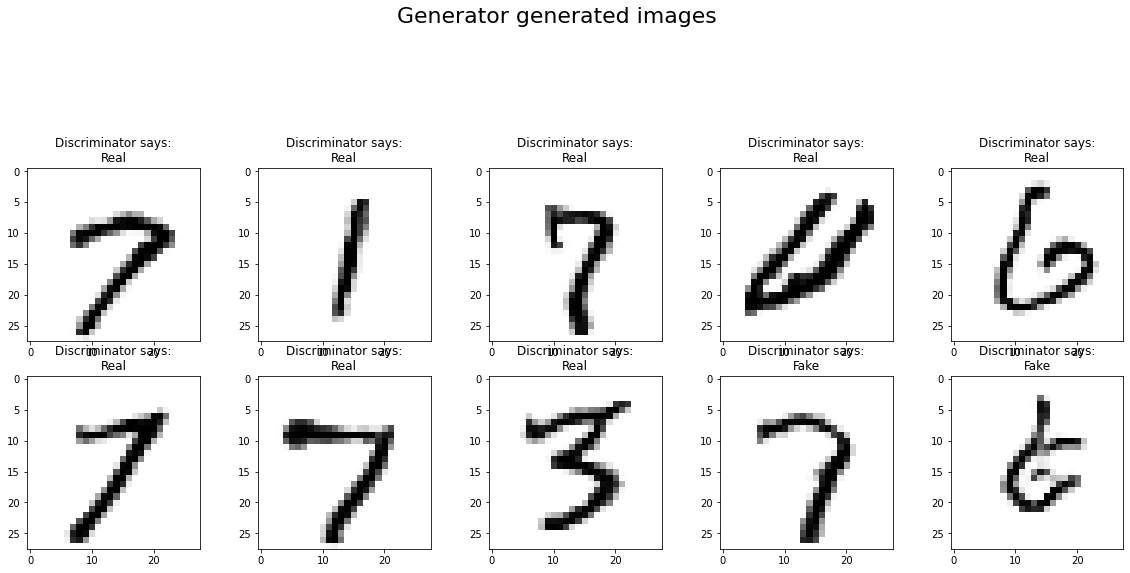

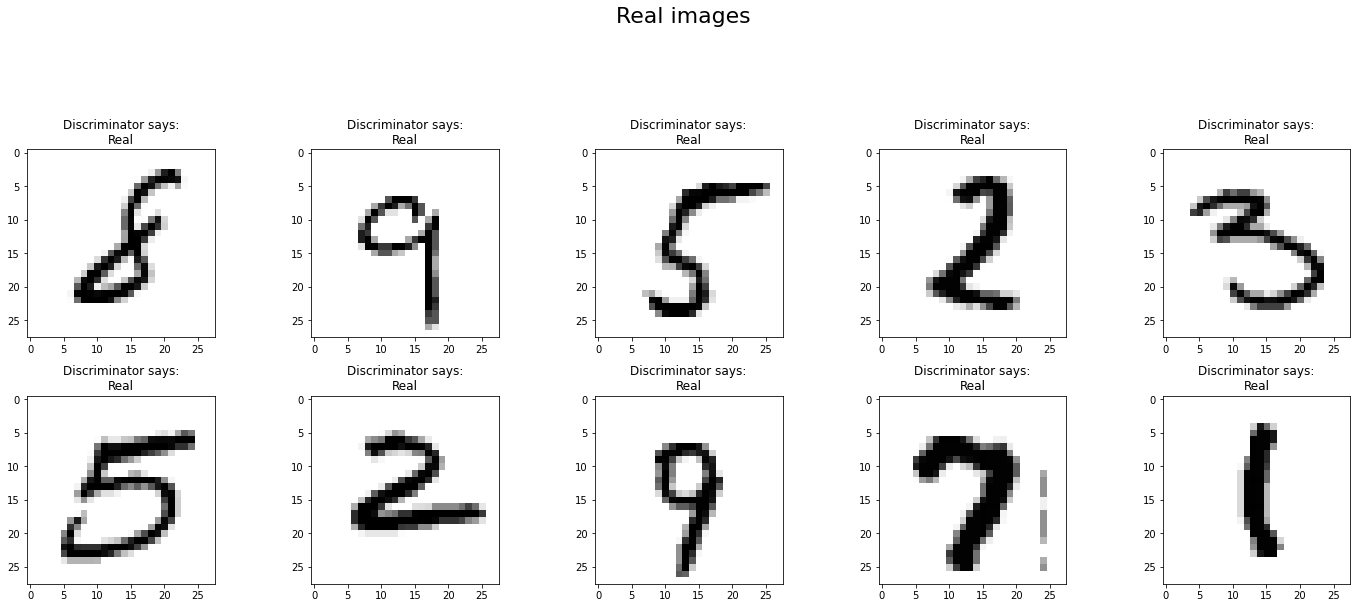

------------------------------------------------------------------------------------------------------------------------


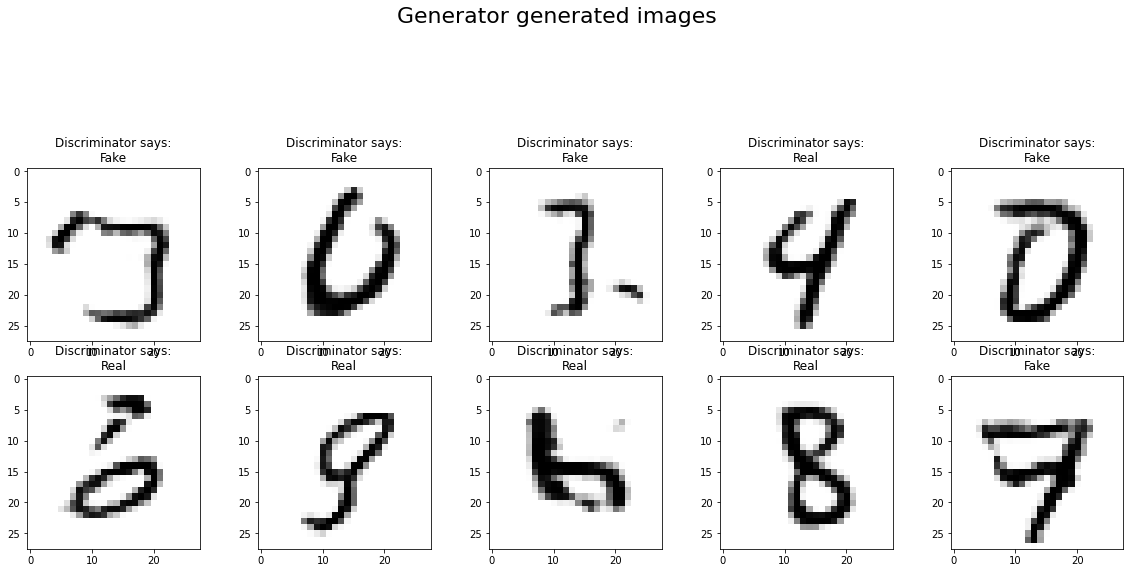

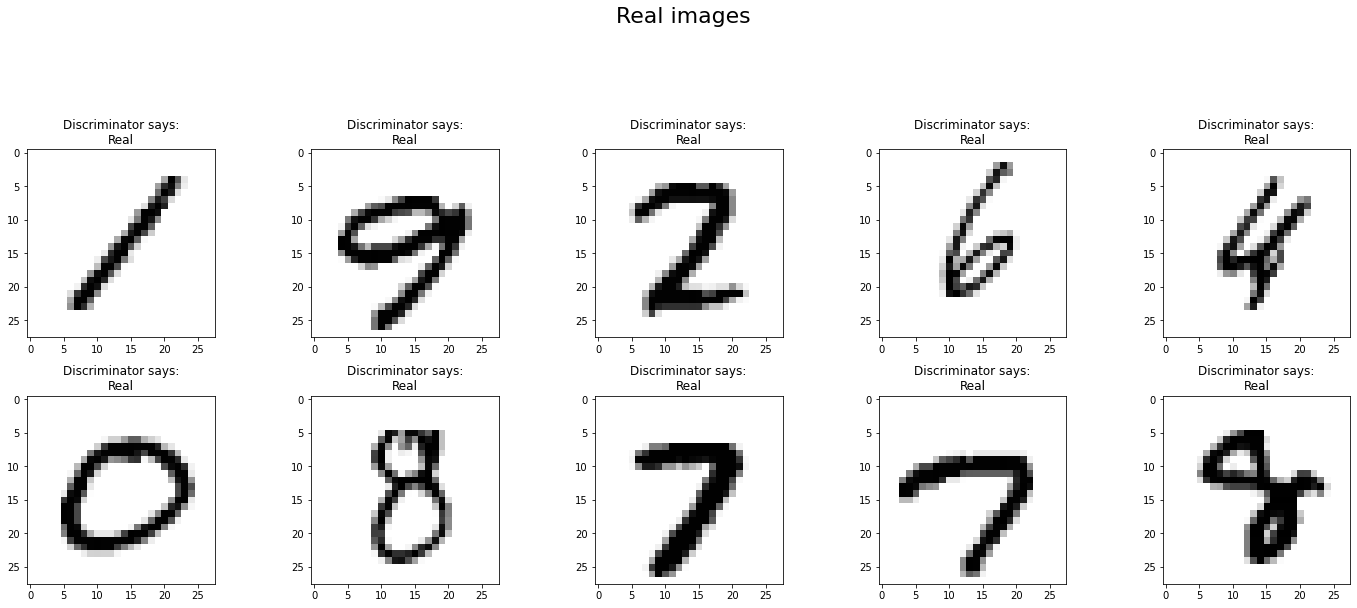

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.7166666666666667
El accuracy del generador es: 0.5333333333333333


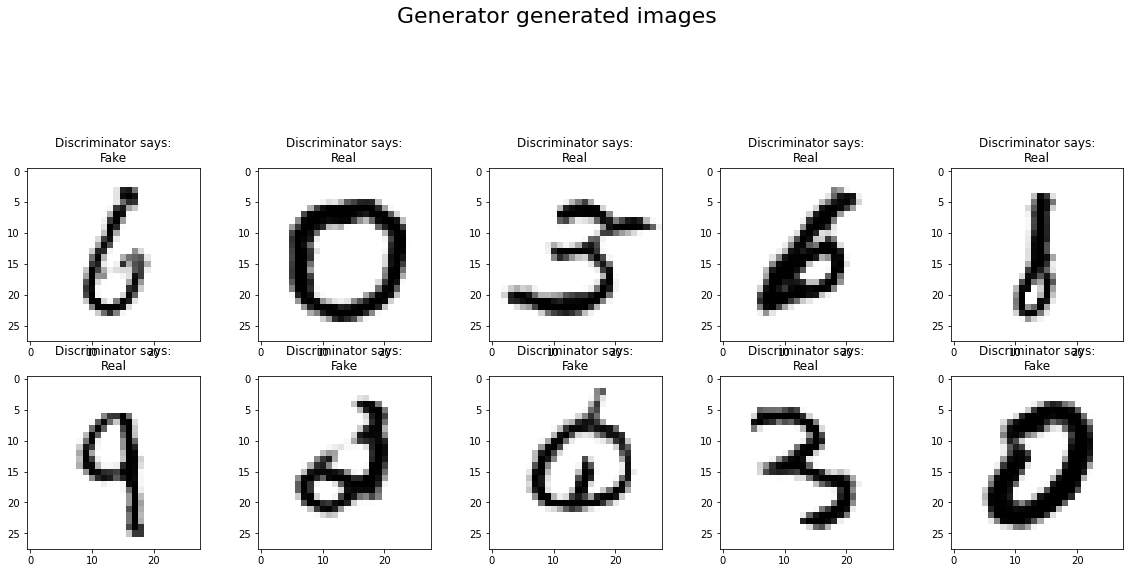

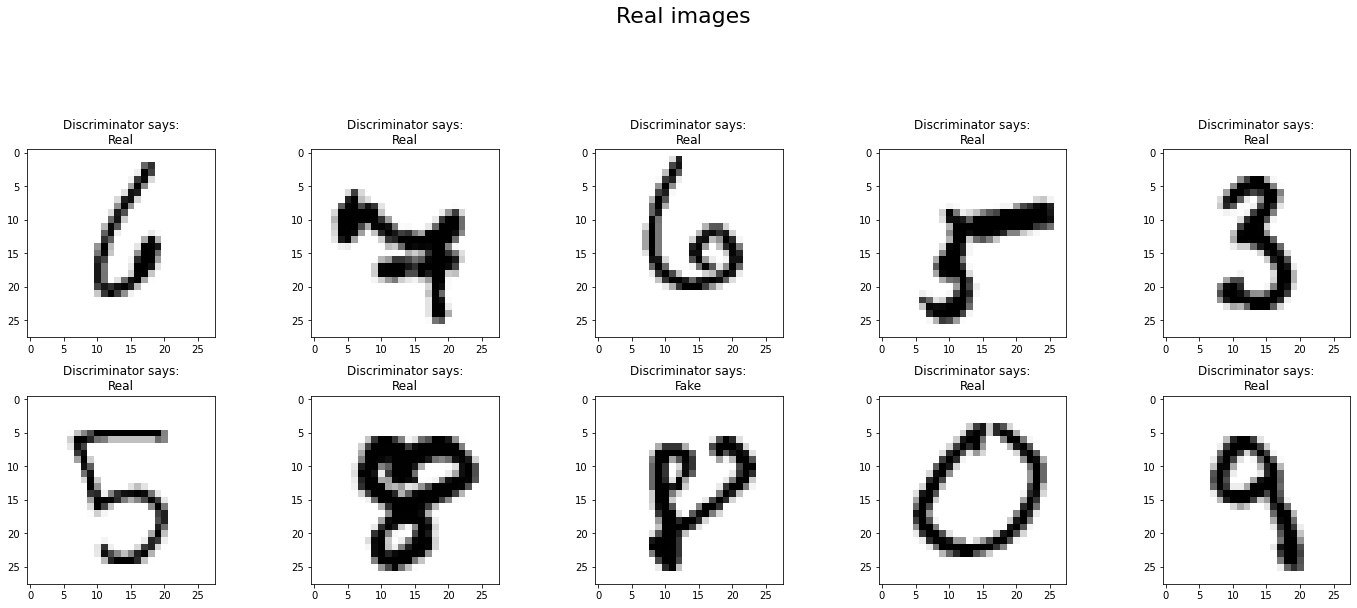

------------------------------------------------------------------------------------------------------------------------


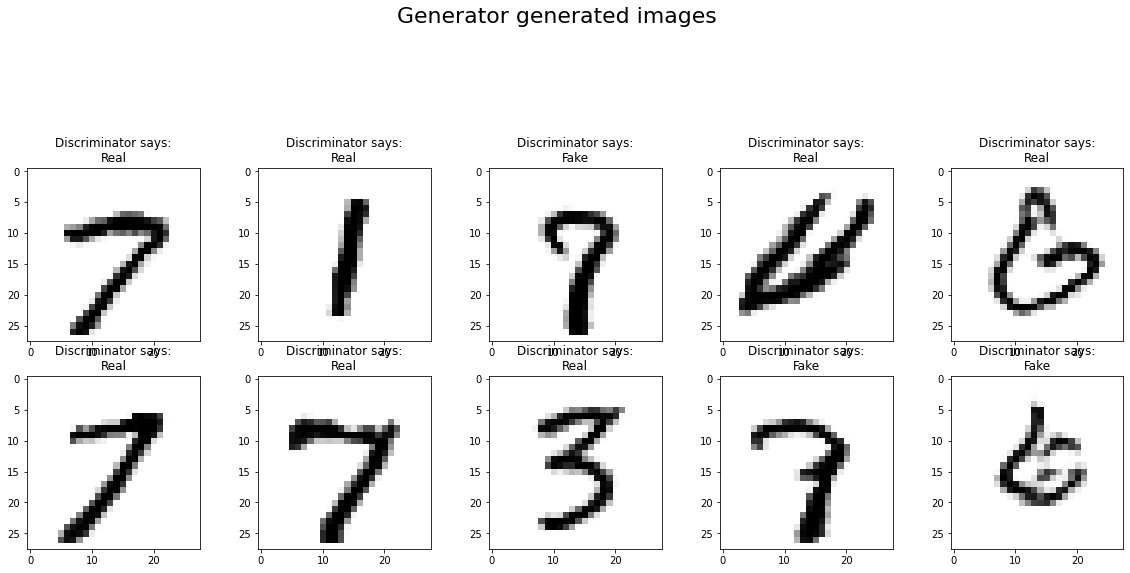

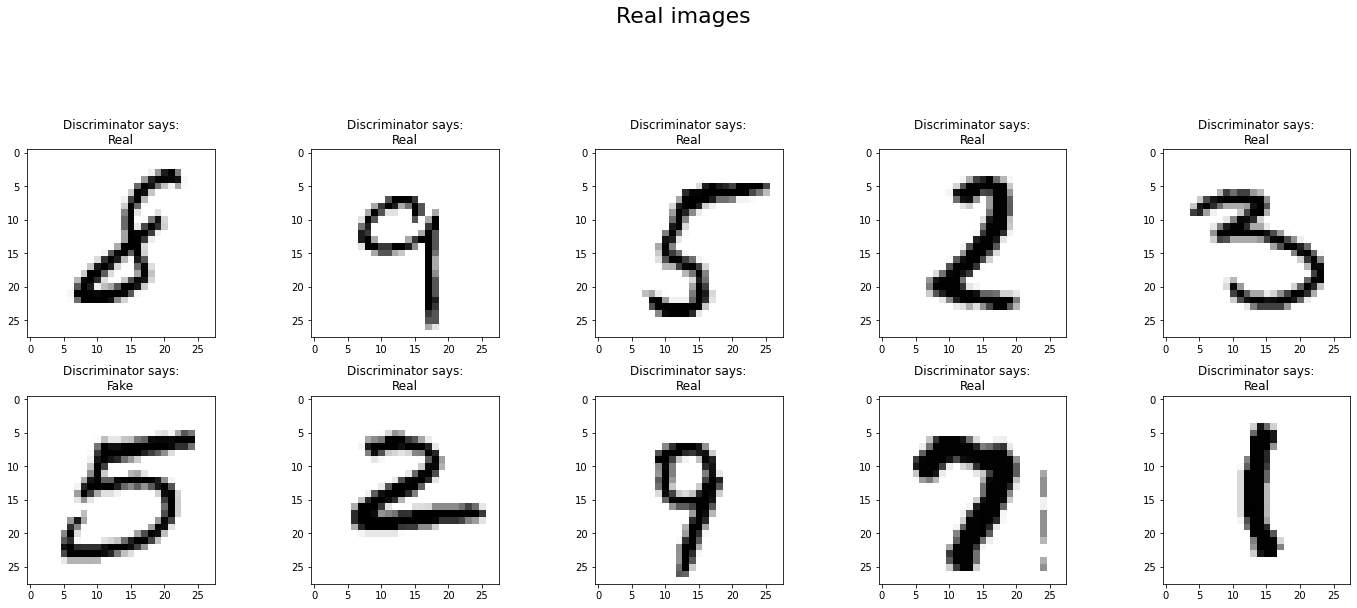

------------------------------------------------------------------------------------------------------------------------


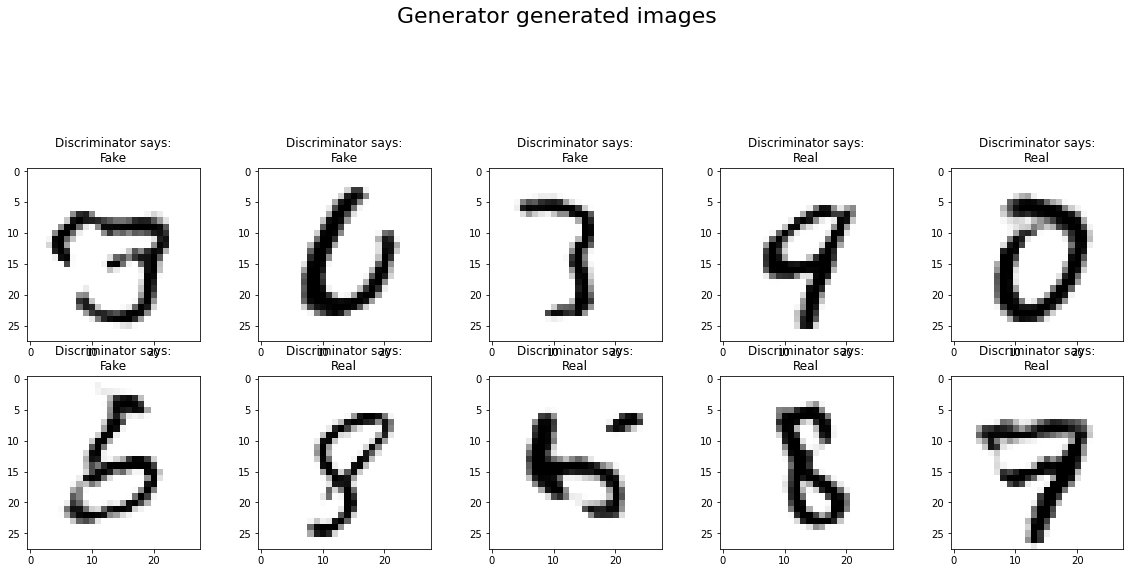

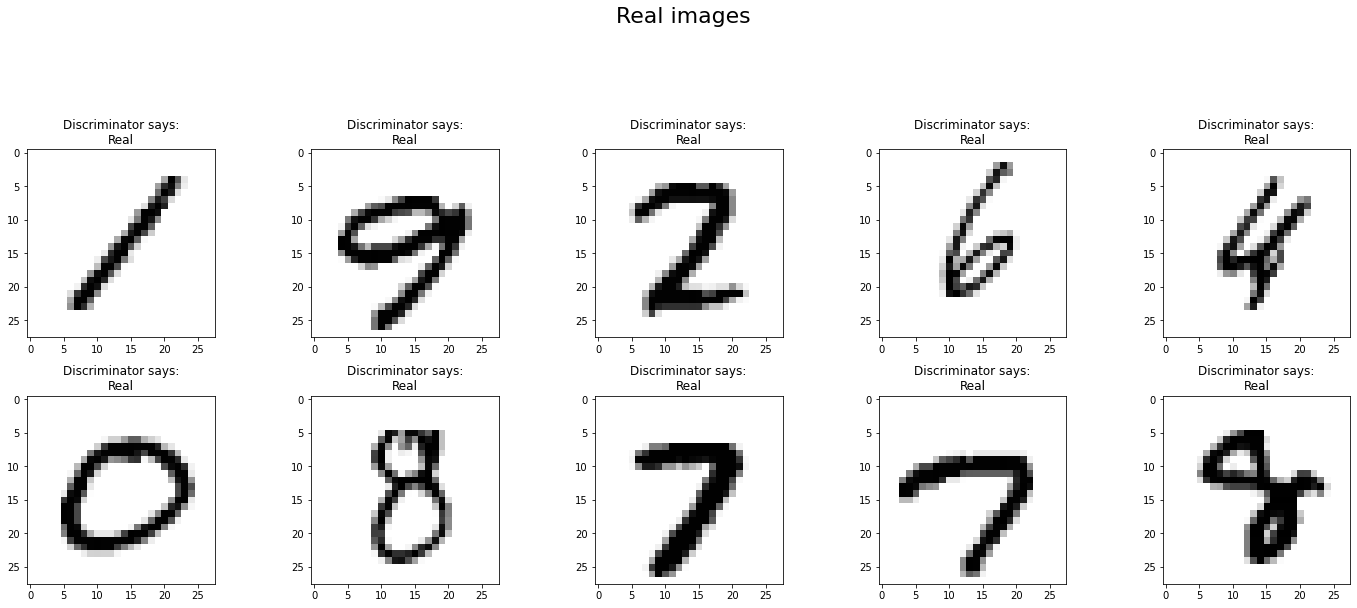

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.65
El accuracy del generador es: 0.6333333333333333


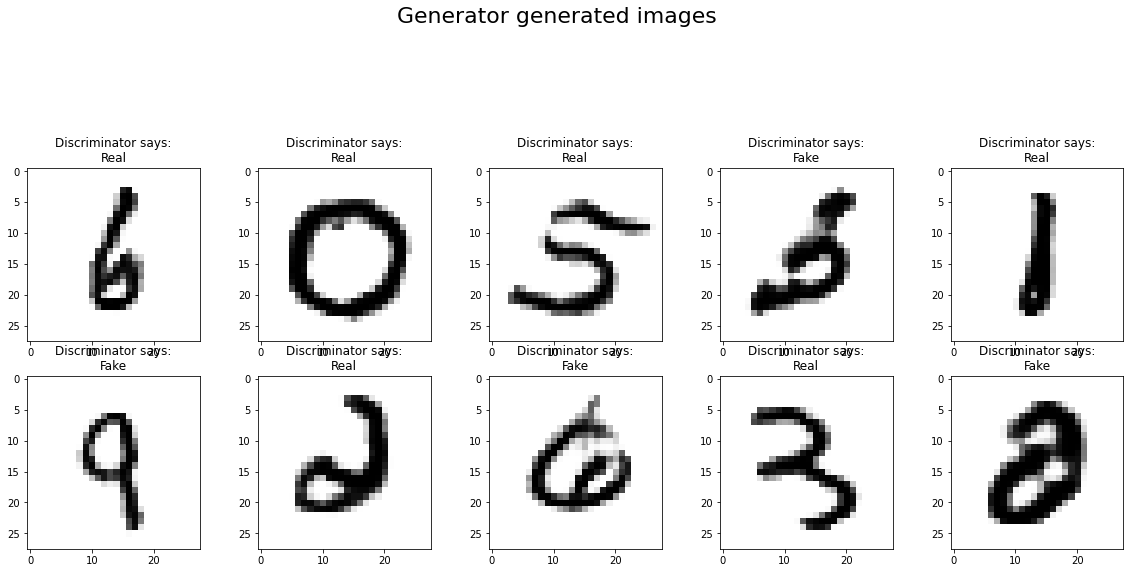

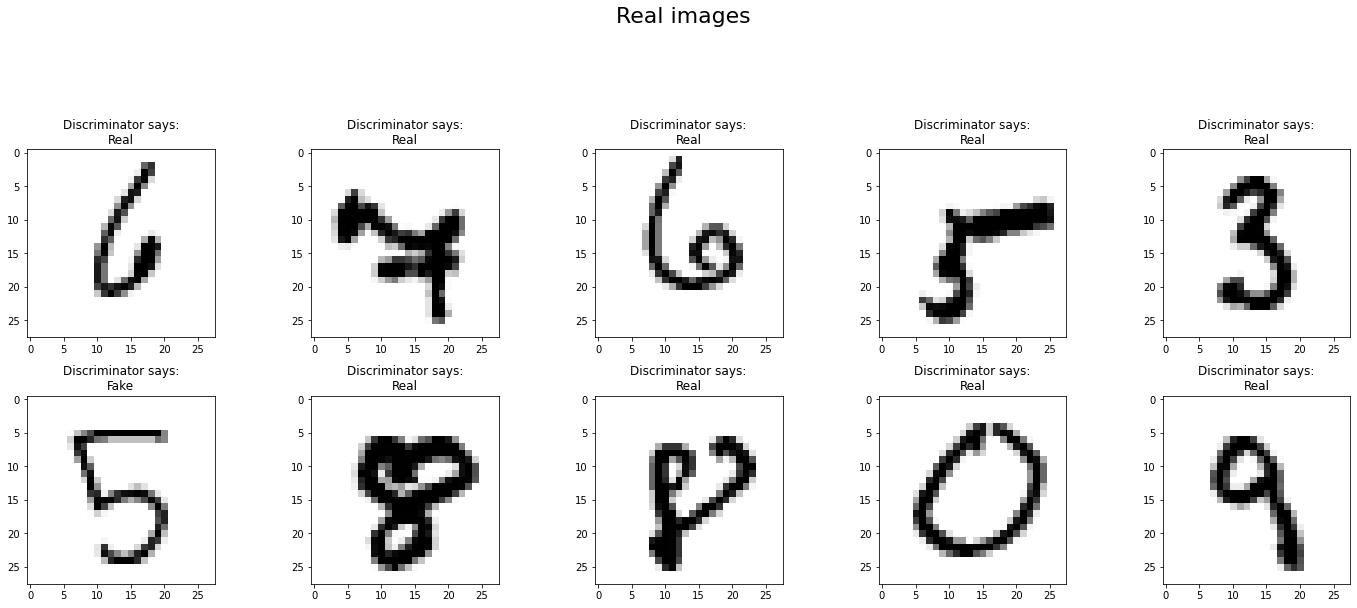

------------------------------------------------------------------------------------------------------------------------


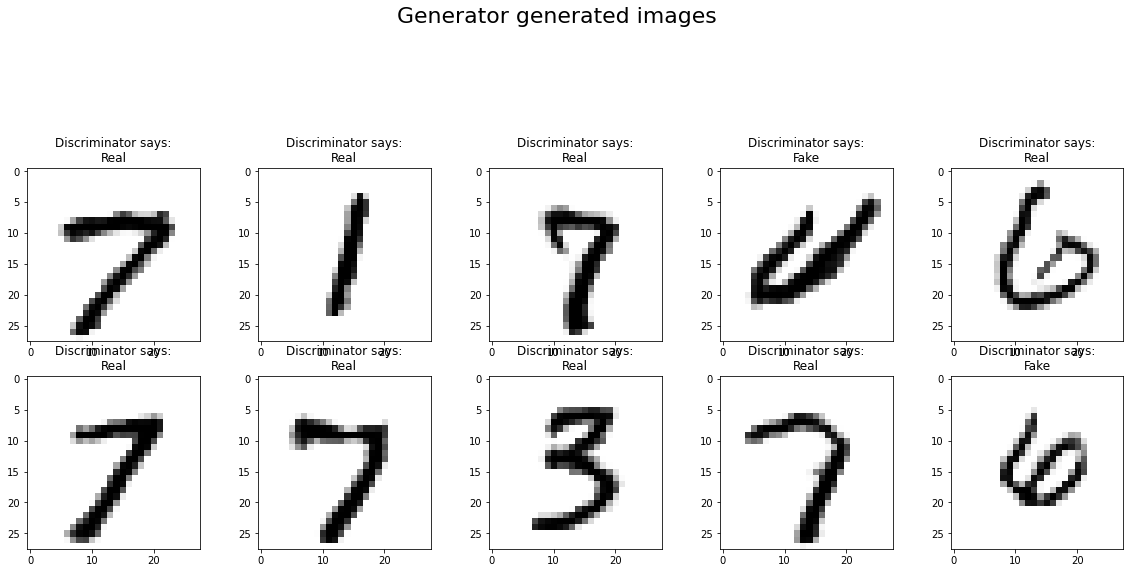

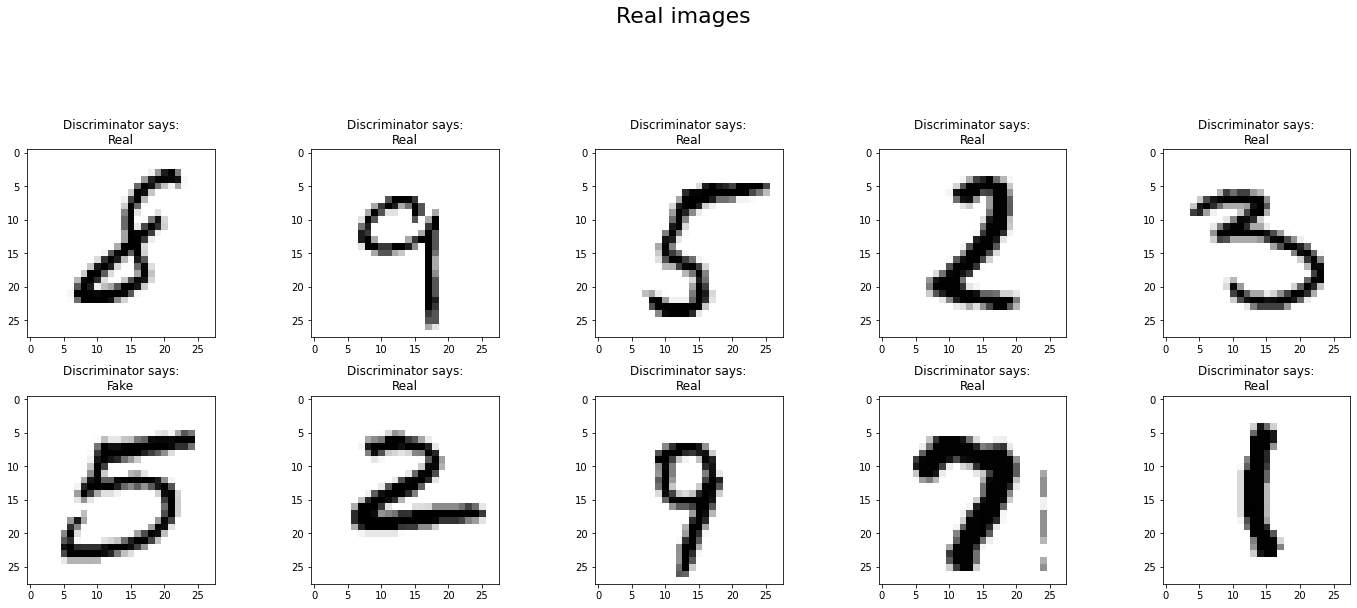

------------------------------------------------------------------------------------------------------------------------


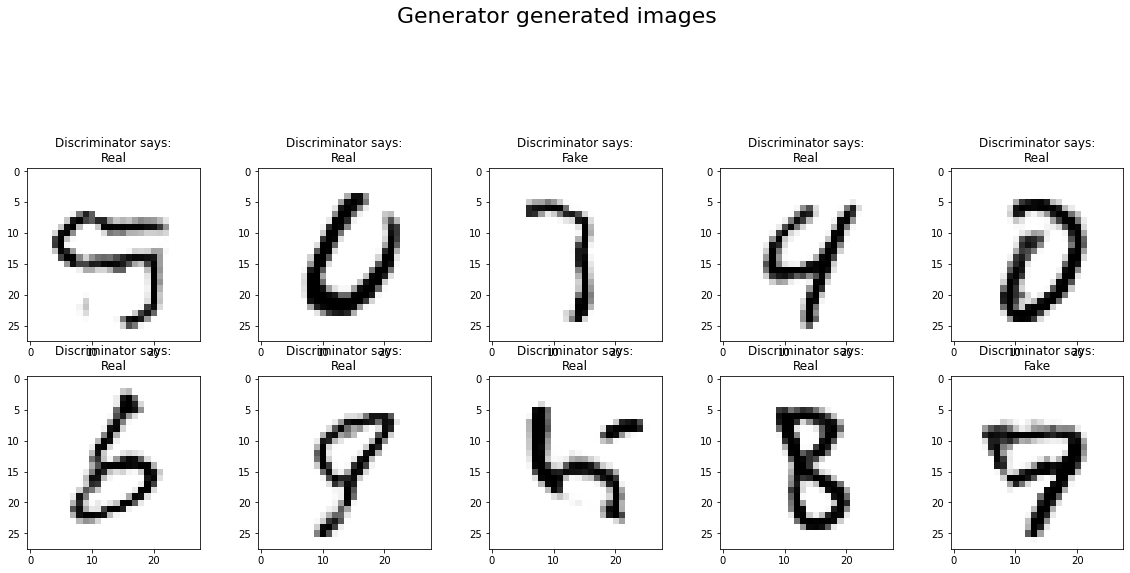

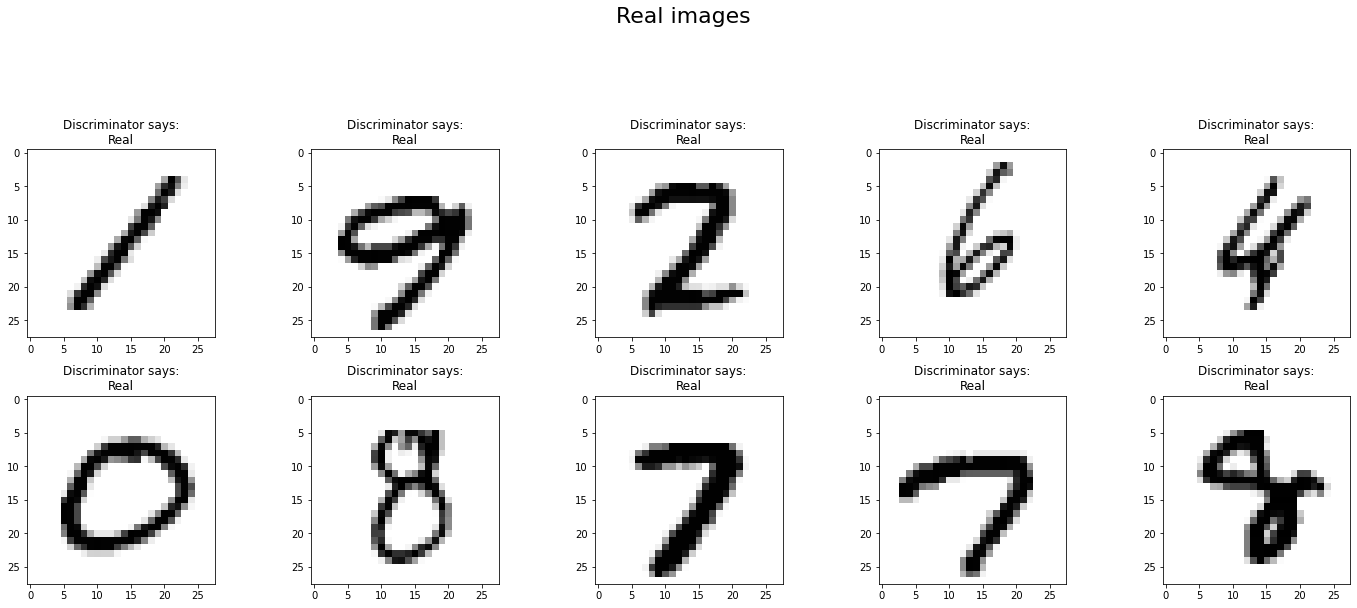

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.6
El accuracy del generador es: 0.7333333333333334


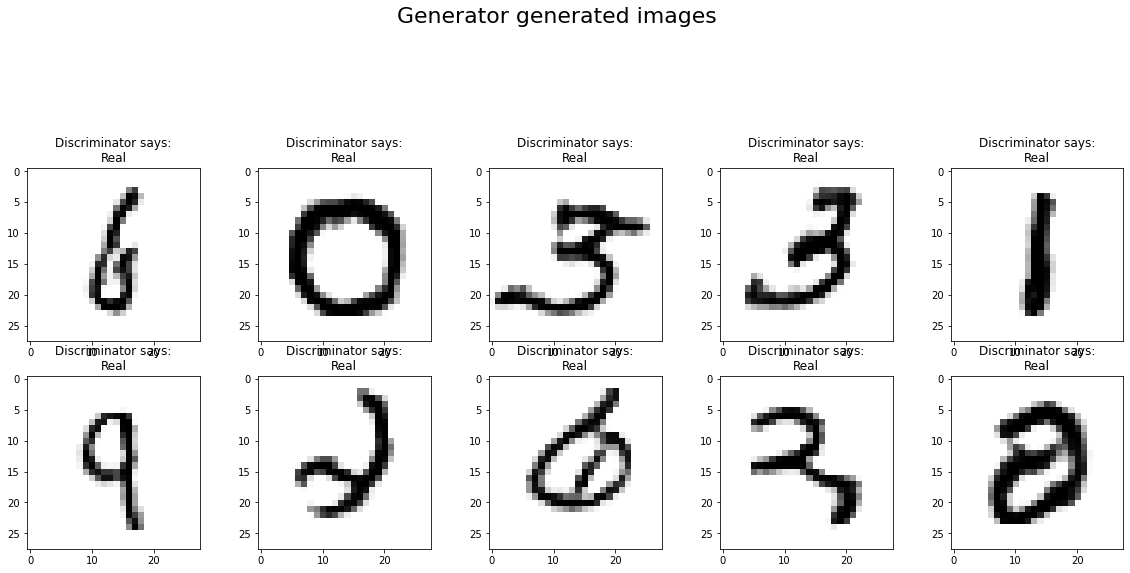

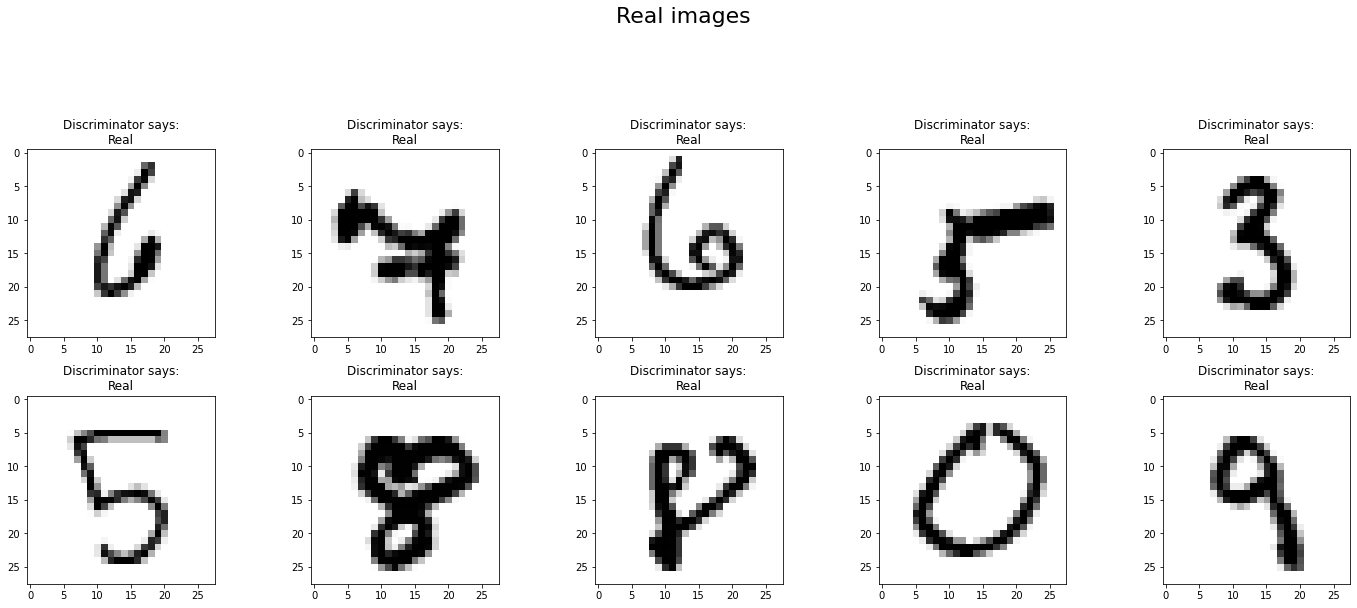

------------------------------------------------------------------------------------------------------------------------


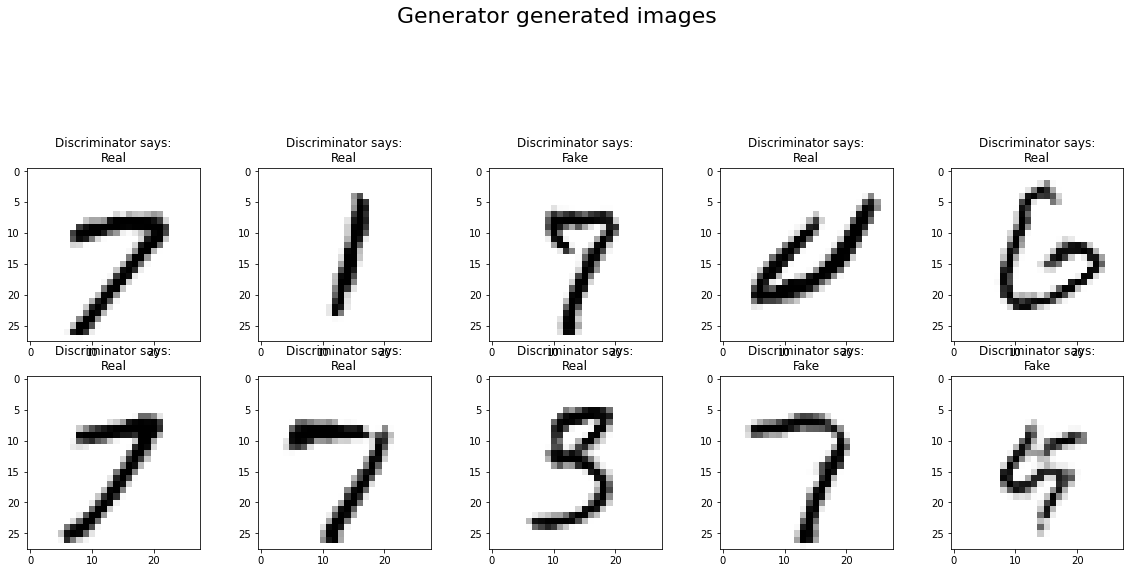

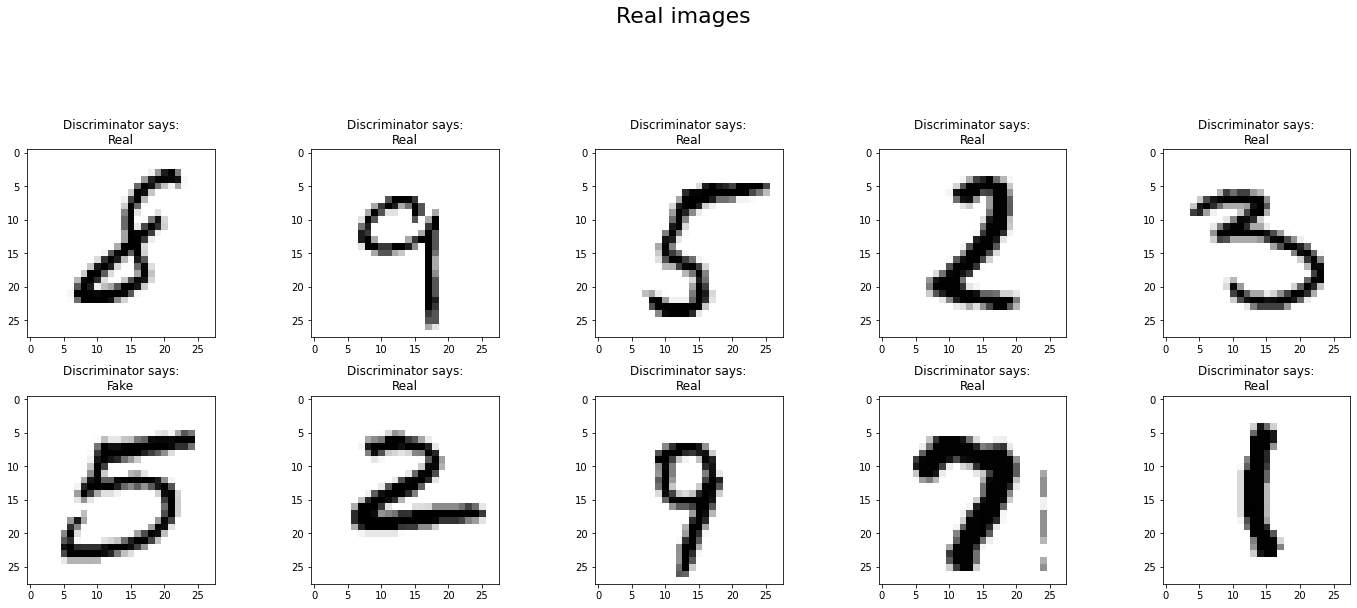

------------------------------------------------------------------------------------------------------------------------


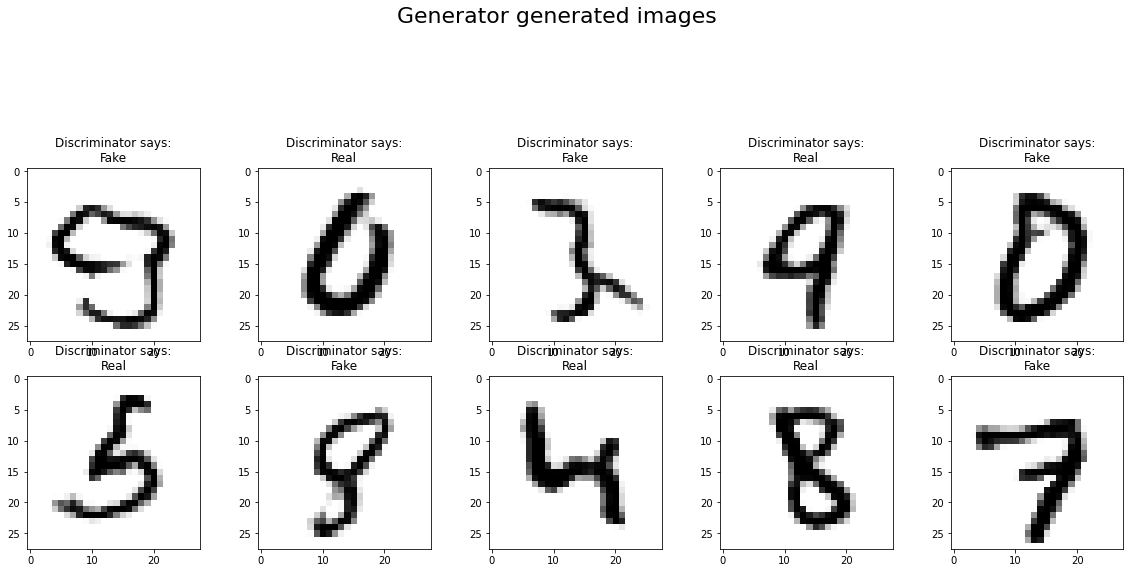

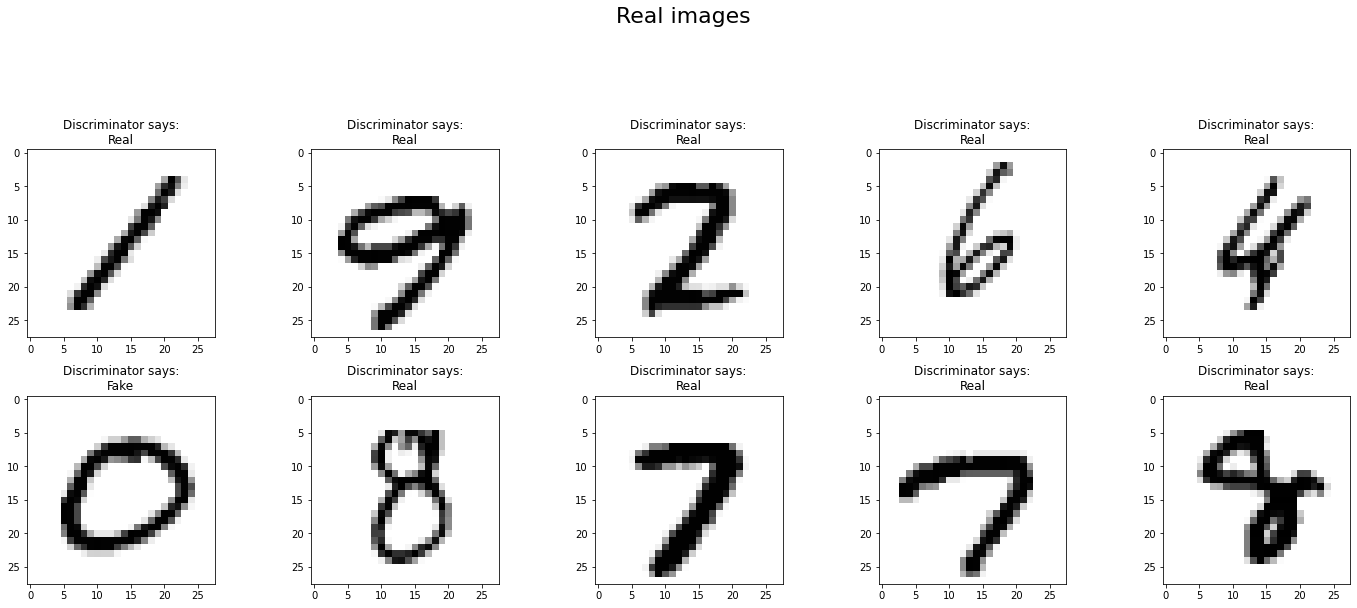

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.6
El accuracy del generador es: 0.7333333333333334


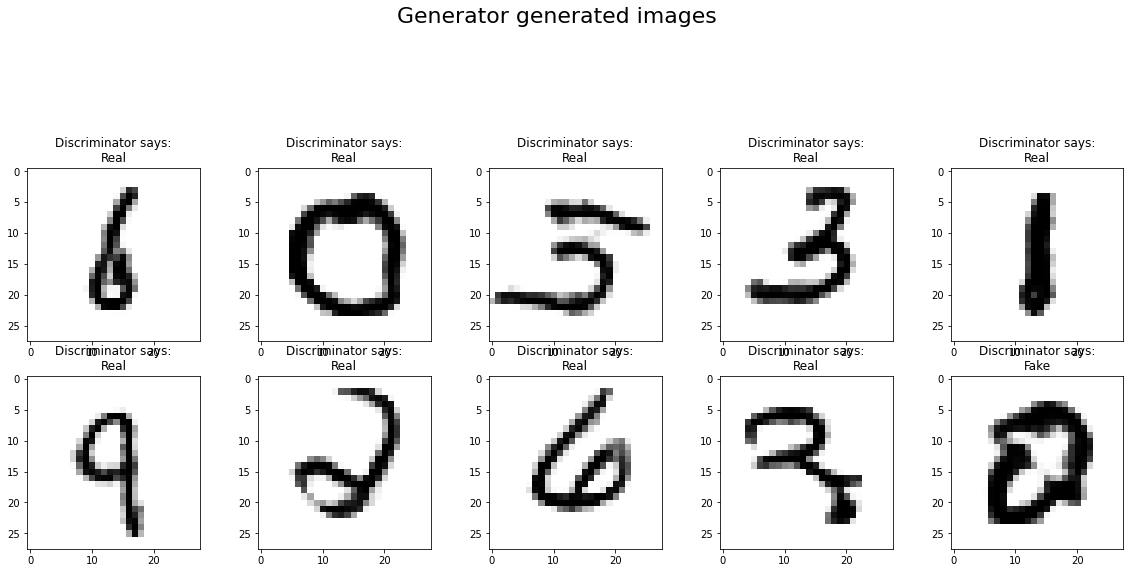

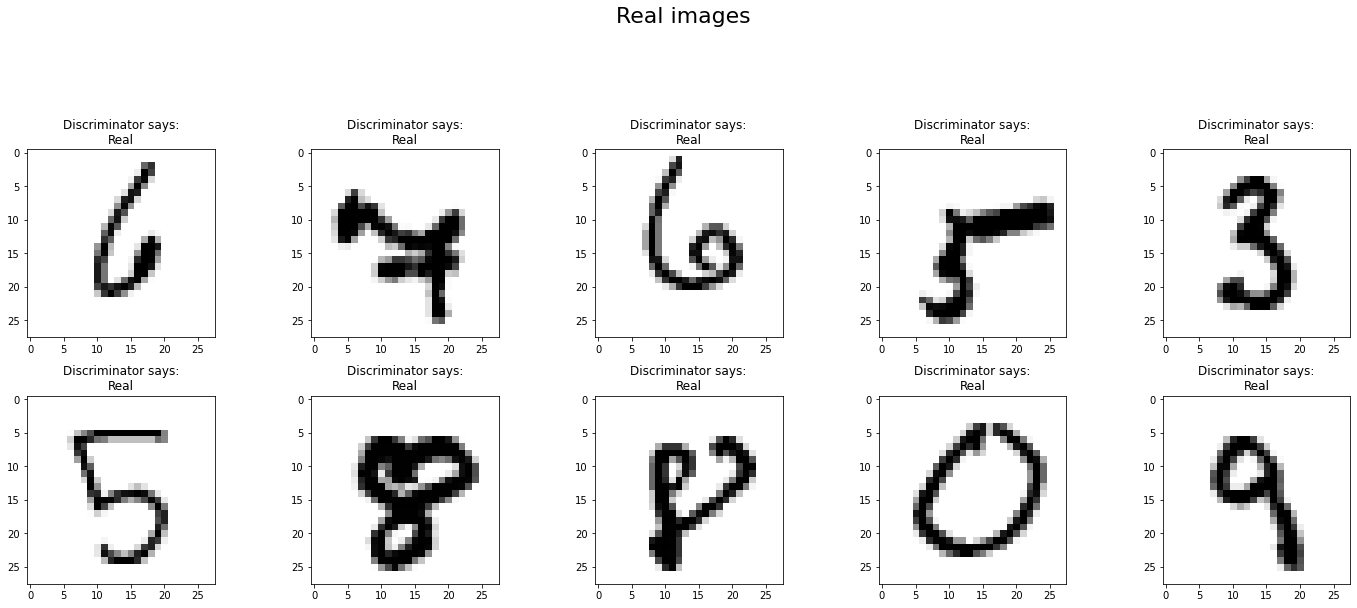

------------------------------------------------------------------------------------------------------------------------


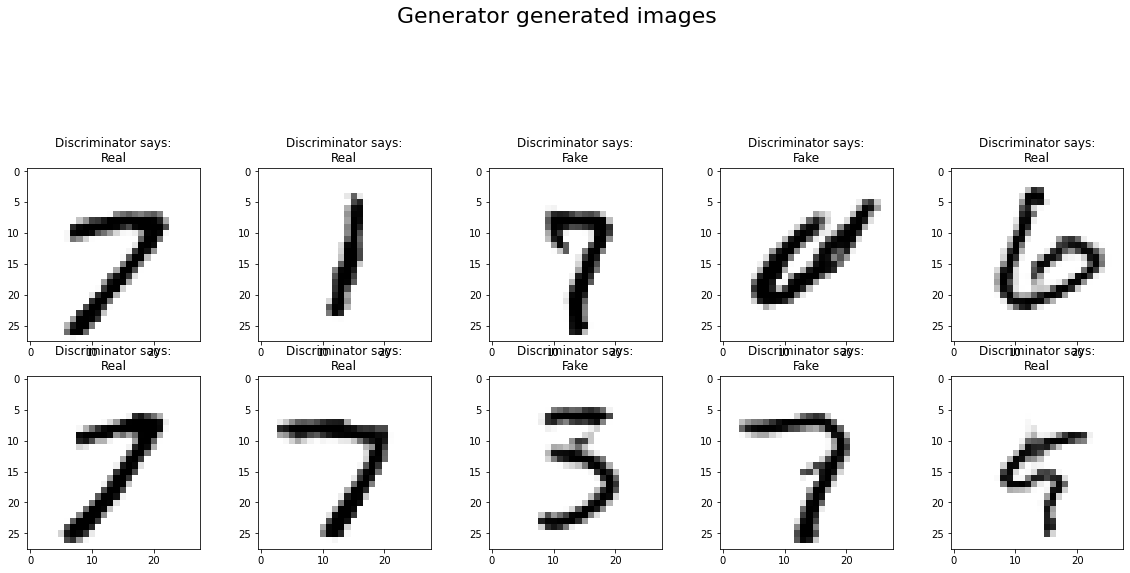

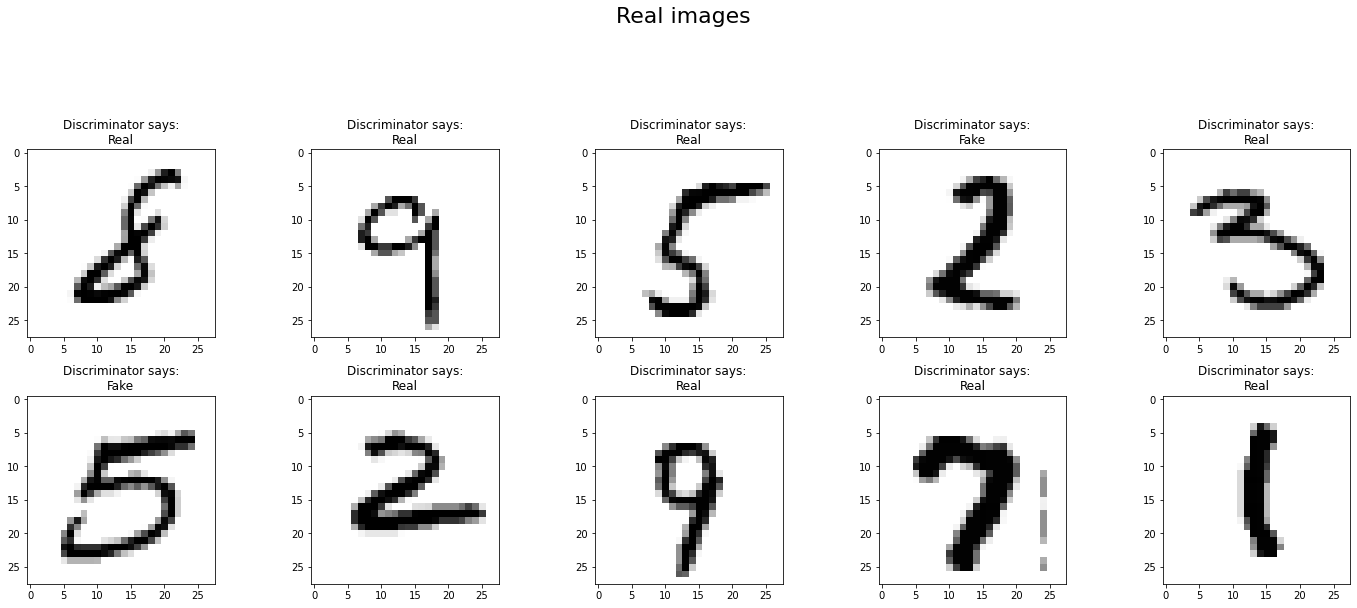

------------------------------------------------------------------------------------------------------------------------


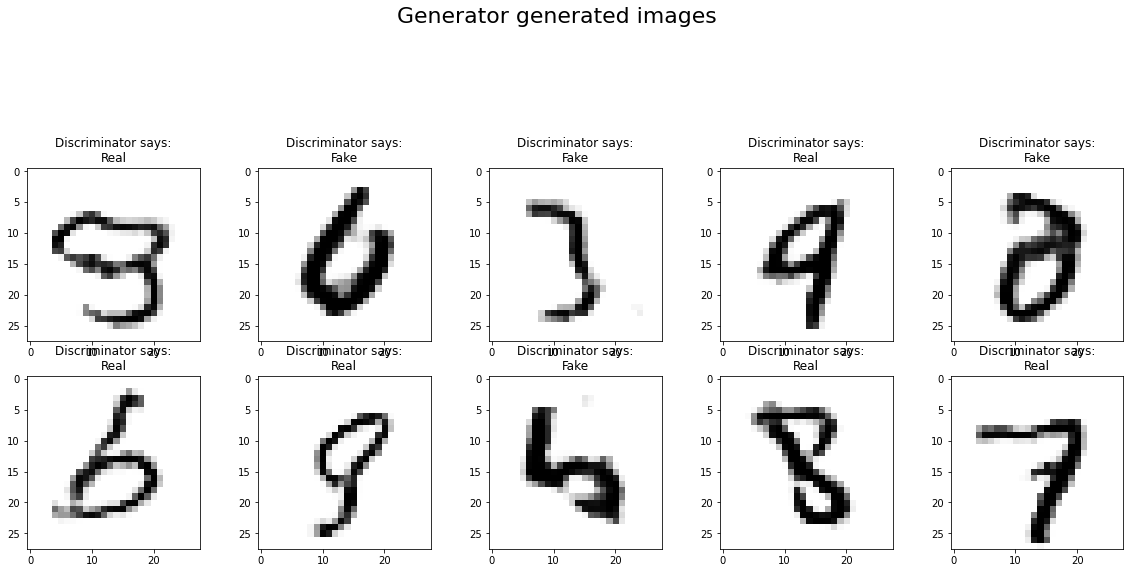

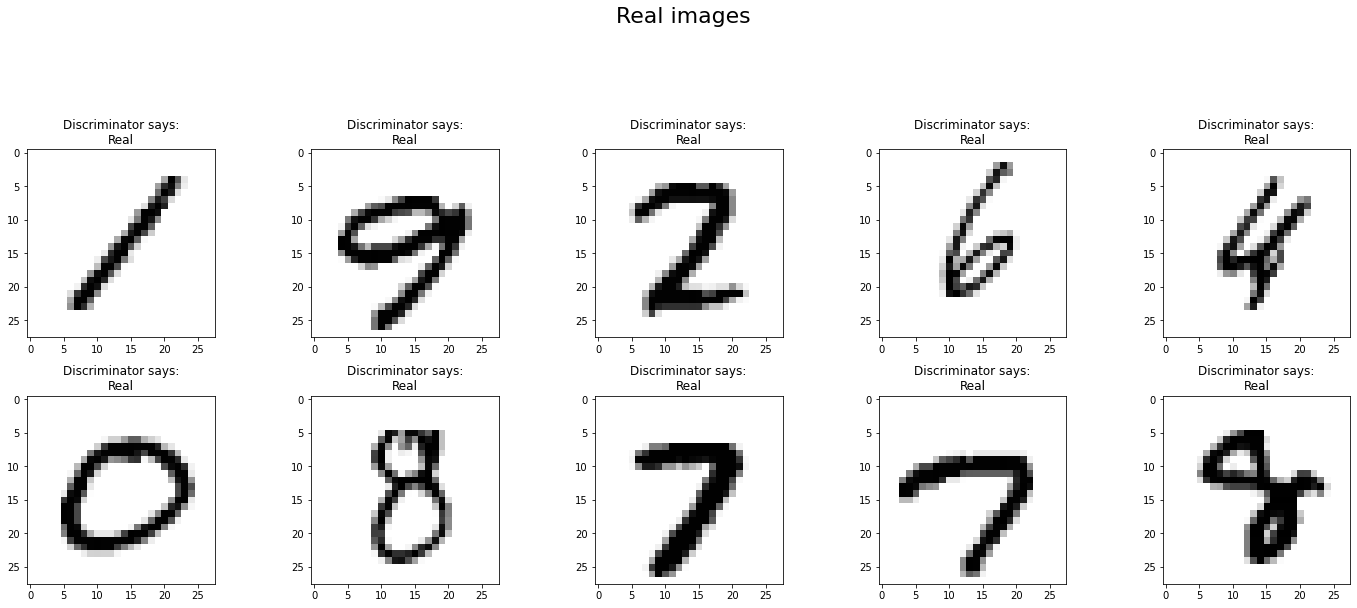

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.6166666666666667
El accuracy del generador es: 0.7


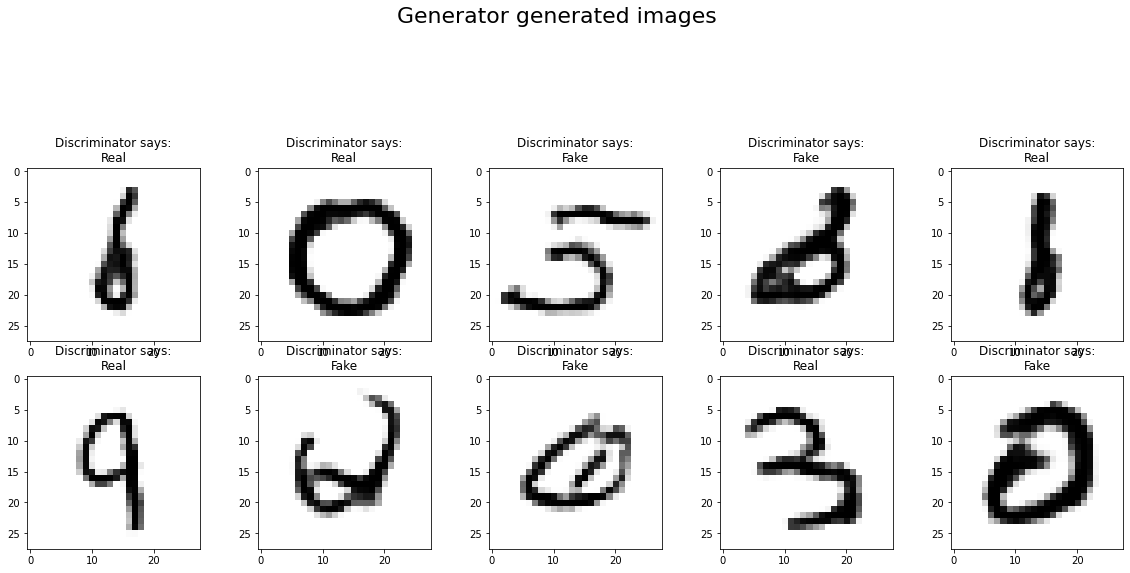

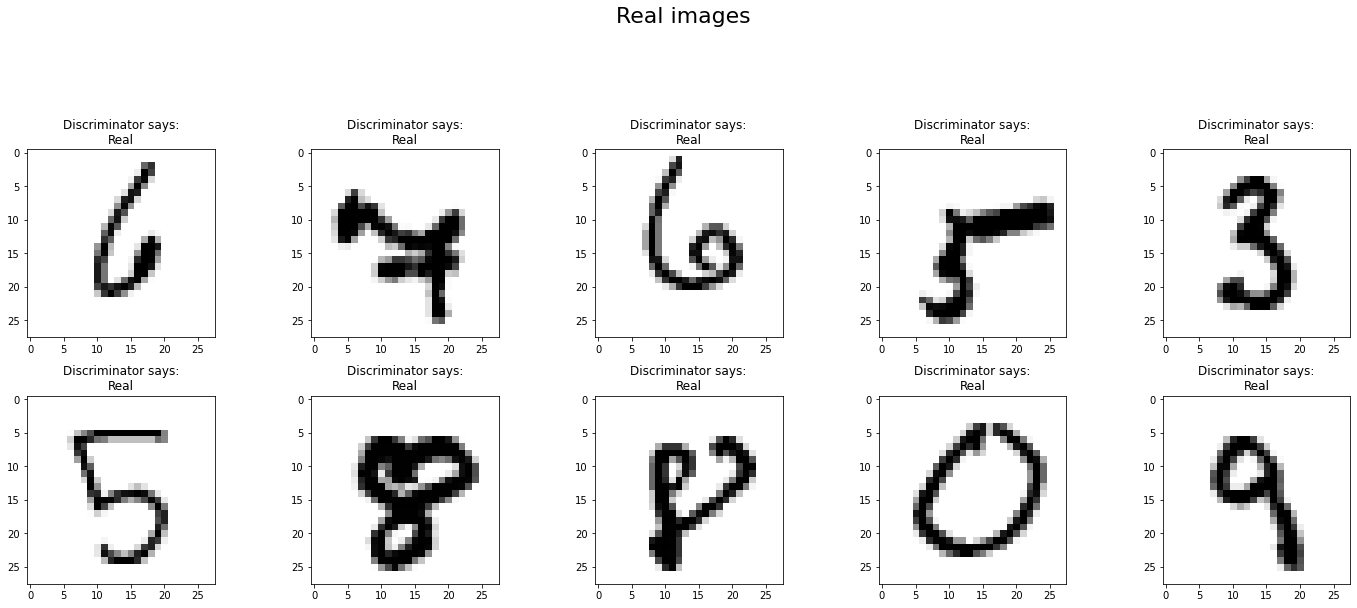

------------------------------------------------------------------------------------------------------------------------


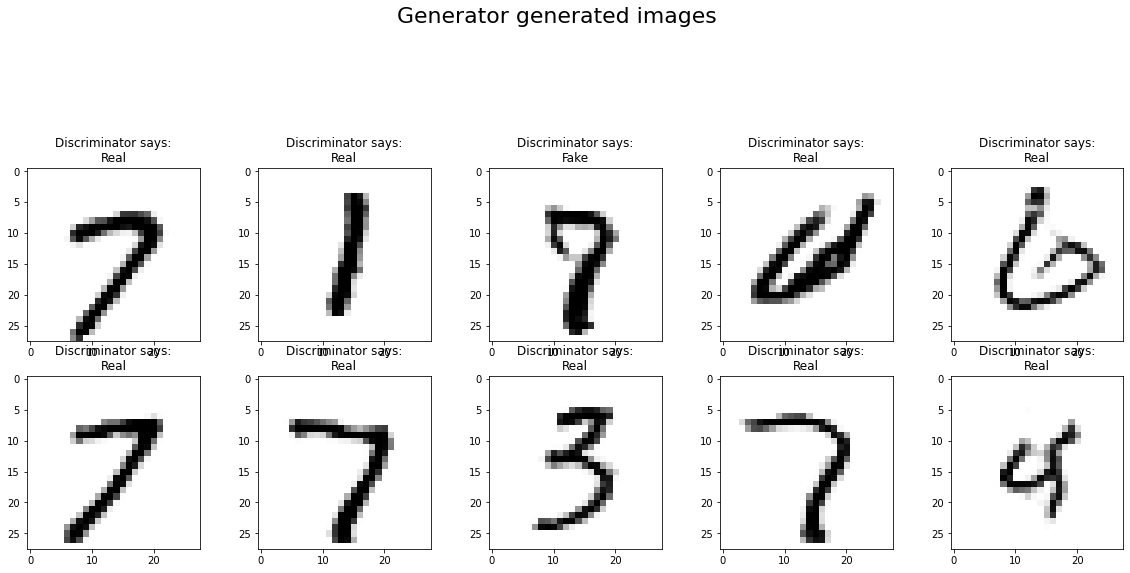

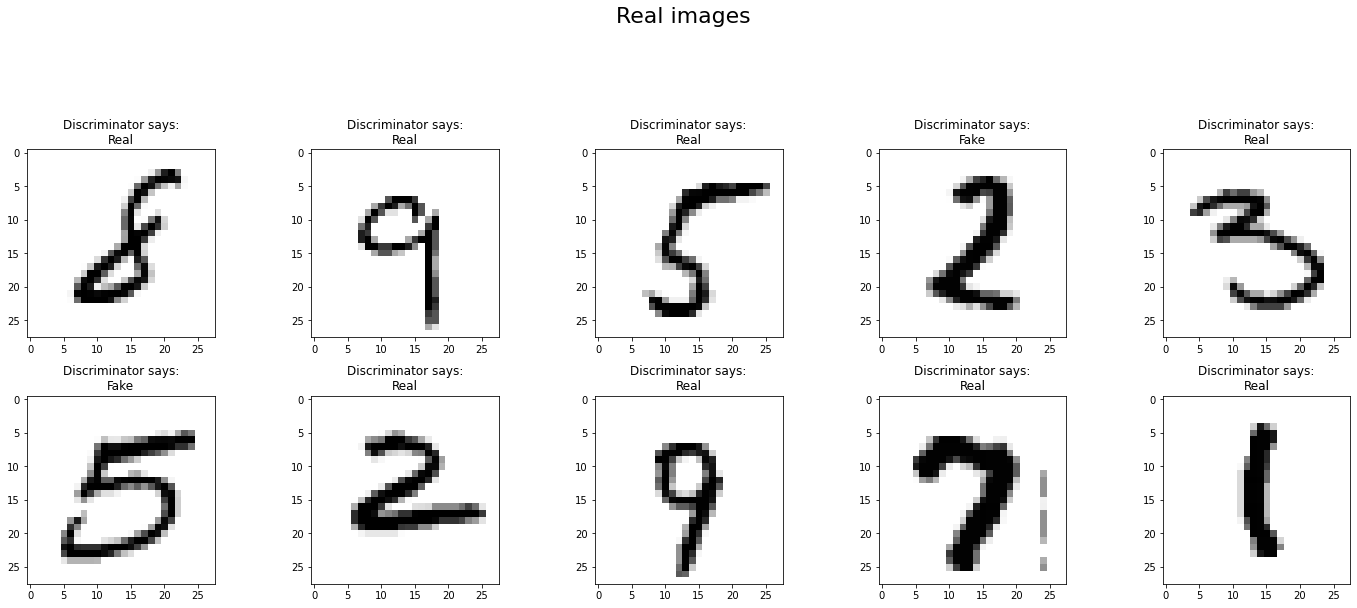

------------------------------------------------------------------------------------------------------------------------


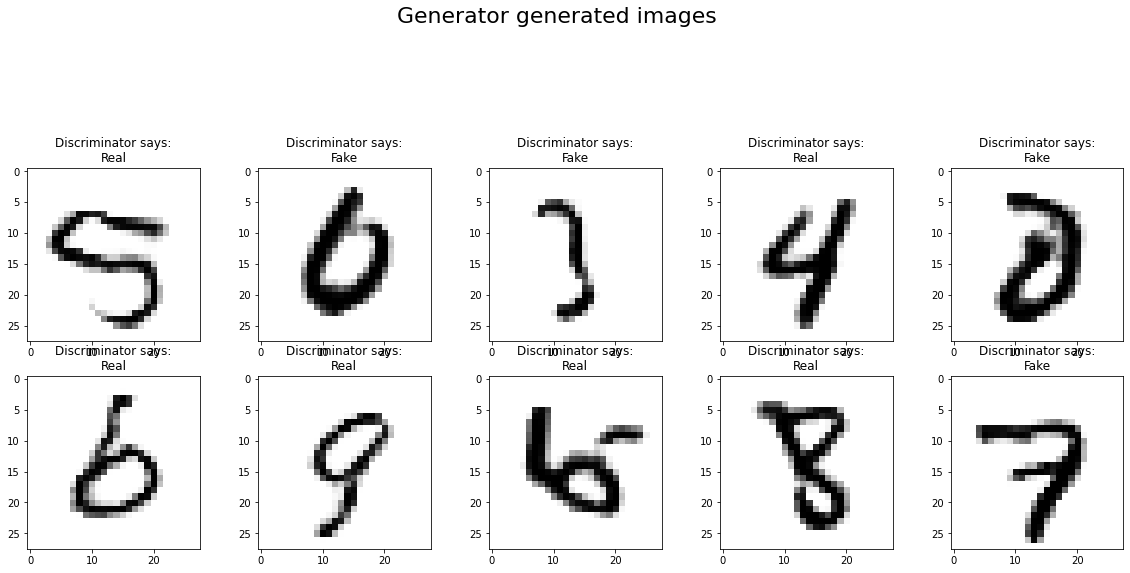

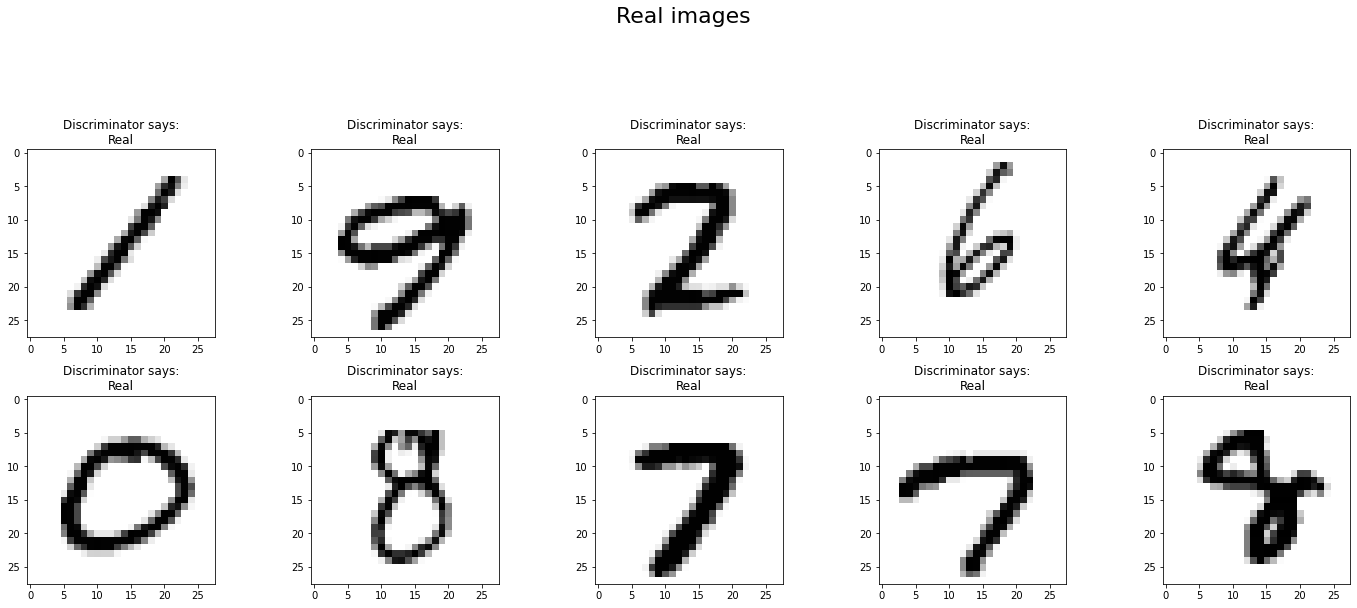

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.6333333333333333
El accuracy del generador es: 0.6666666666666667


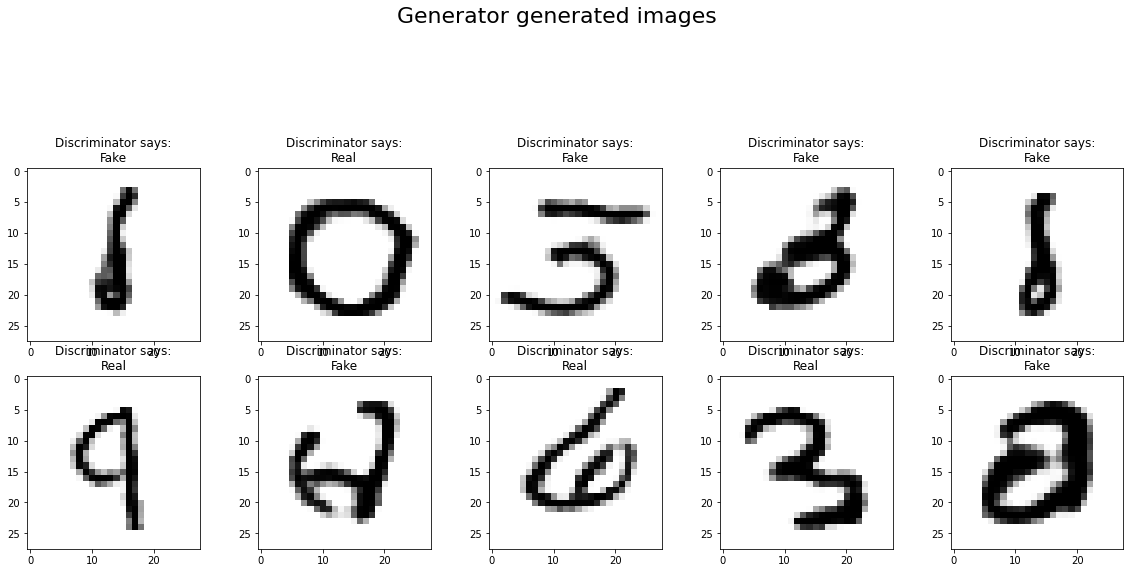

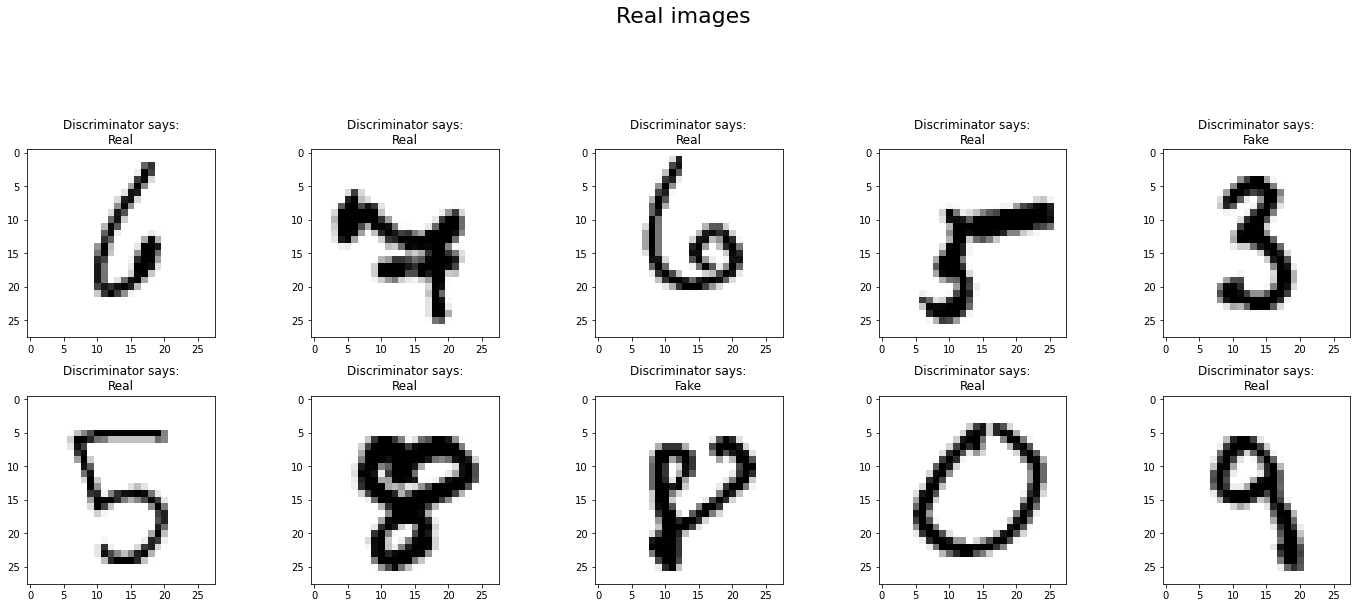

------------------------------------------------------------------------------------------------------------------------


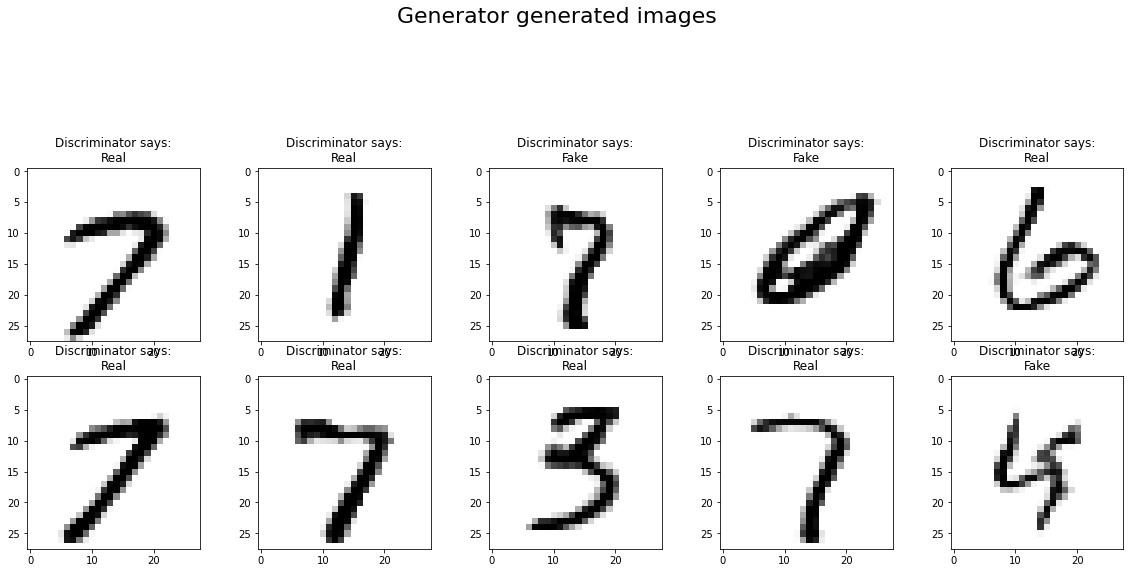

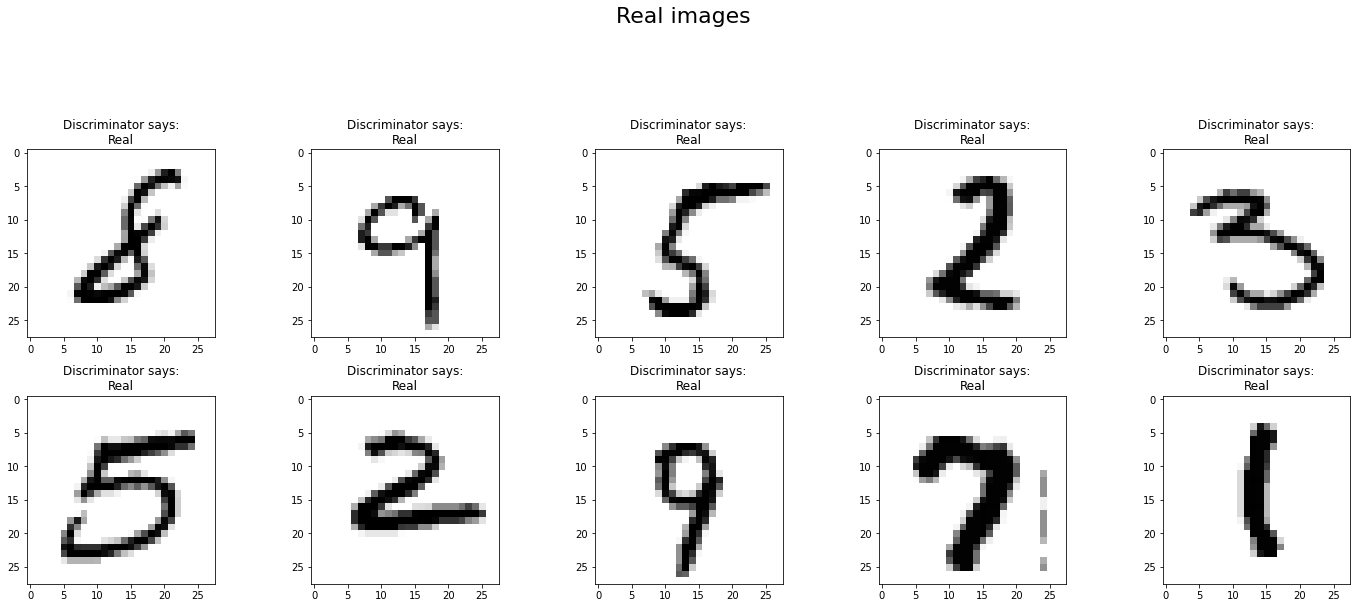

------------------------------------------------------------------------------------------------------------------------


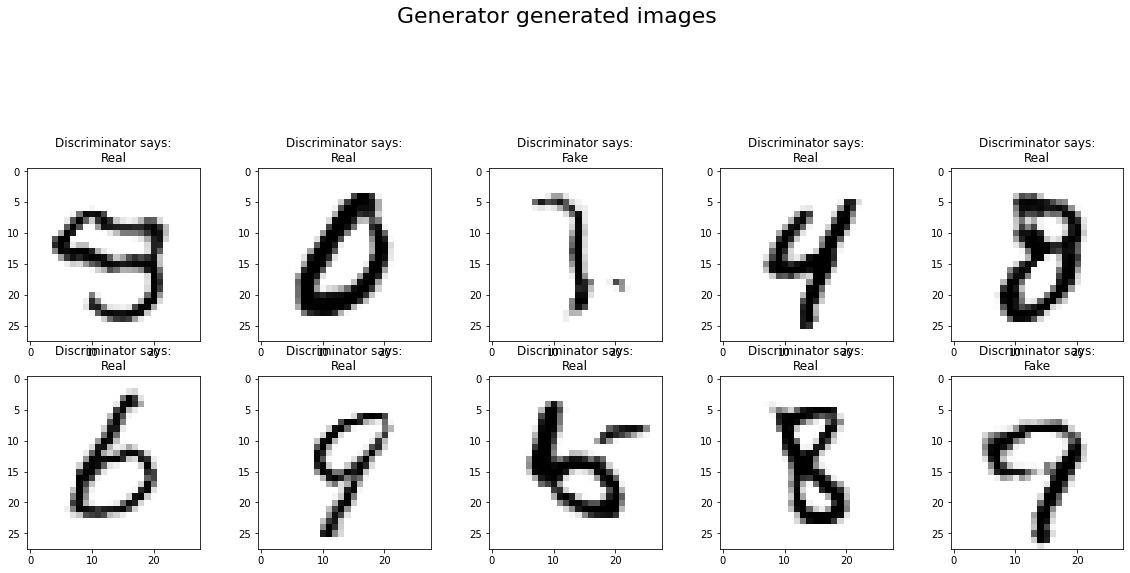

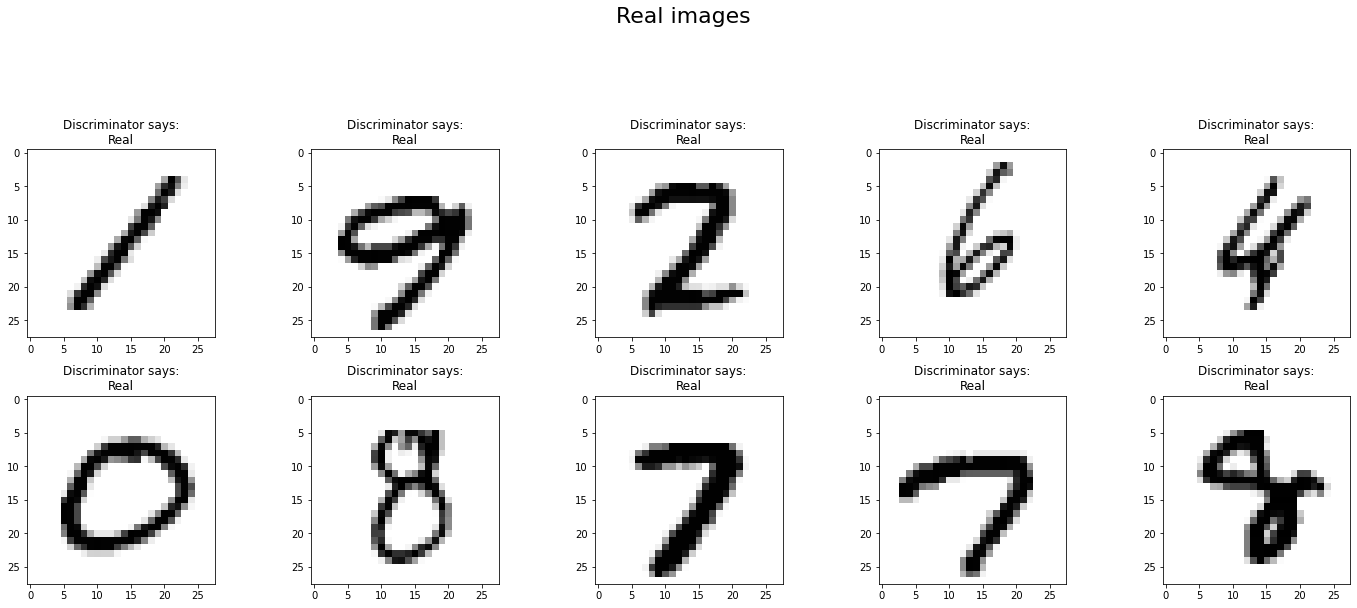

------------------------------------------------------------------------------------------------------------------------
El accuracy del discriminador es: 0.65
El accuracy del generador es: 0.6333333333333333


In [ ]:
batch_size = 128 
plt.rcParams["figure.figsize"] = [20, 7]
accuracies_d = np.array([])
accuracies_g = np.array([])

for epoch in range(20):
    y_preds_false = np.array([])
    y_clas_false = np.array([])
    y_preds_true = np.array([])
    y_clas_true = np.array([])
    for batch in range(
        int(x.shape[0] / batch_size)
    ): 
        # train discriminator
        ix = np.random.randint(
            0, x.shape[0], batch_size
        )  # we generate indices to sample images from the dataset, we sample batch_size=128 data
        x_real = x[ix]  # we select the images
        np.random.seed(batch)
        noise = np.random.rand(
            noise_size * batch_size
        )  # we generate noise, depending on the size of the input of our generator
        noise = noise.reshape(
            (batch_size, noise_size)
        )  # reshape (batch_size,noise_size) sized noise
        x_false = generator_net.predict(noise)  # we generate fake images according to the noise
        y_real = np.ones((batch_size, 1))  # real labels
        y_false = np.zeros((batch_size, 1))  # fake labels
        x_train = np.concatenate(
            (x_real, x_false)
        ) 
        y_train = np.concatenate(
            (y_real, y_false)
        )  
        response_dis = discriminator.train_on_batch(
            x_train, y_train
        )  # train discriminator
        # discriminator.trainable = False
        # train generator
        noise2 = np.random.rand(
            noise_size * batch_size
        )  # we generate noise again based on the size of the input of our generator
        noise2 = noise2.reshape(
            (batch_size, noise_size)
        )  # reshape (batch_size,noise_size) sized noise
        response_gen = gan.train_on_batch(
            noise2, np.ones((batch_size, 1))
        )  # output is 1, as generator needs to convine discriminator (trainable false) w/ fake images from noise
        if batch % (200) == 0:  # cada cuánto plotear es ajustable
            # plot random generated images, discriminator image inputs and outputs, and losses and accuracies
            for i in range(0, 10):
                plt.subplot(2, 5, 1 + i)
                y_pred_false = int(
                    np.round(
                        discriminator.predict(x_false[i : i + 1, :, :, :])[0, 0], 0
                    )
                )
                y_preds_false = np.append(y_preds_false, y_pred_false)
                y_clas_false = np.append(y_clas_false, y_false[i : i + 1])
                plt.title("Discriminator says:\n" + ["Fake", "Real"][y_pred_false])
                plt.axis("on")
                # print(x_false[i,:,:,0])
                plt.imshow(x_false[i, :, :, 0], cmap="gray_r")
            plt.suptitle("Generator generated images", y=1.2, size=22)
            plt.show()

            for i in range(0, 10):
                plt.subplot(2, 5, i + 1)
                y_pred_true = int(
                    np.round(discriminator.predict(x_real[i : i + 1, :, :, :])[0, 0], 0)
                )
                y_preds_true = np.append(y_preds_true, y_pred_true)
                y_clas_true = np.append(y_clas_true, y_real[i : i + 1])
                plt.title(
                    "Discriminator says:\n"
                    + ["Fake", "Real"][
                        int(
                            np.round(
                                discriminator.predict(x_real[i : i + 1, :, :, :])[0, 0],
                                0,
                            )
                        )
                    ]
                )
                plt.imshow(x_real[i, :, :, 0], cmap="gray_r")

            plt.tight_layout()
            plt.suptitle("Real images", y=1.2, size=22)
            plt.show()
            print("-" * 120)
    y_pred = np.concatenate((y_preds_false, y_preds_true))
    y_clas = np.concatenate((y_clas_false, y_clas_true))
    y_pred_d = y_pred > 0.5
    y_clas_d = y_clas > 0.5
    acc_d = np.sum(y_pred_d == y_clas_d) / y_pred_d.shape[0]
    accuracies_d = np.append(accuracies_d, acc_d)
    y_pred_g = y_preds_false > 0.5
    y_clas_g = y_clas_false > 0.5
    acc_g = np.sum(y_pred_g == y_clas_g) / y_pred_g.shape[0]
    accuracies_g = np.append(accuracies_g, acc_g)
    print(f"El accuracy del discriminador es: {acc_d}")
    print(f"El accuracy del generador es: {1-acc_g}")


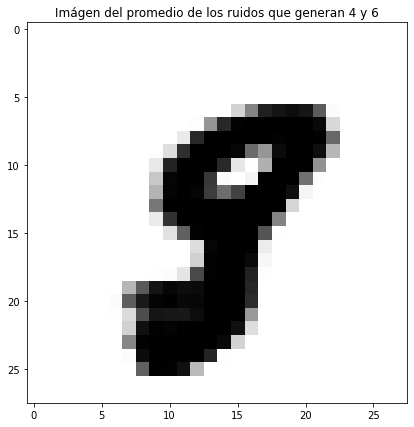

In [ ]:
# Los ruidos que generan el 3 y 7 corresponde a: noise[2] y noise[4] en la iteración final
tres = noise[3]
siete = noise[5]
promedio = (tres + siete) / 2
imagen_generada = generator_net.predict(promedio.reshape(1, 50))
plt.title("Imágen del promedio de los ruidos que generan 4 y 6")
plt.imshow(imagen_generada[0, :, :, 0], cmap="gray_r")


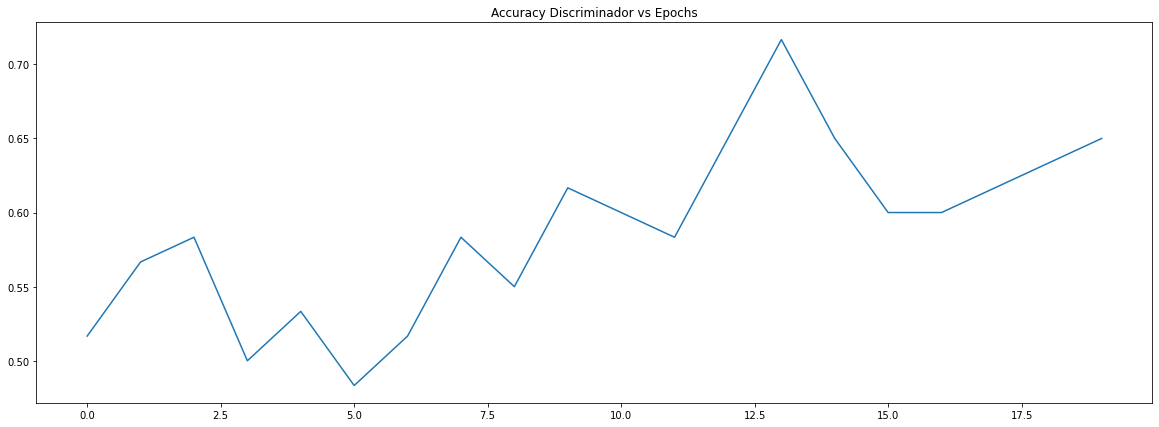

In [ ]:
epochs = np.arange(0, 20)
plt.title("Accuracy Discriminador vs Epochs")
plt.plot(epochs, accuracies_d)


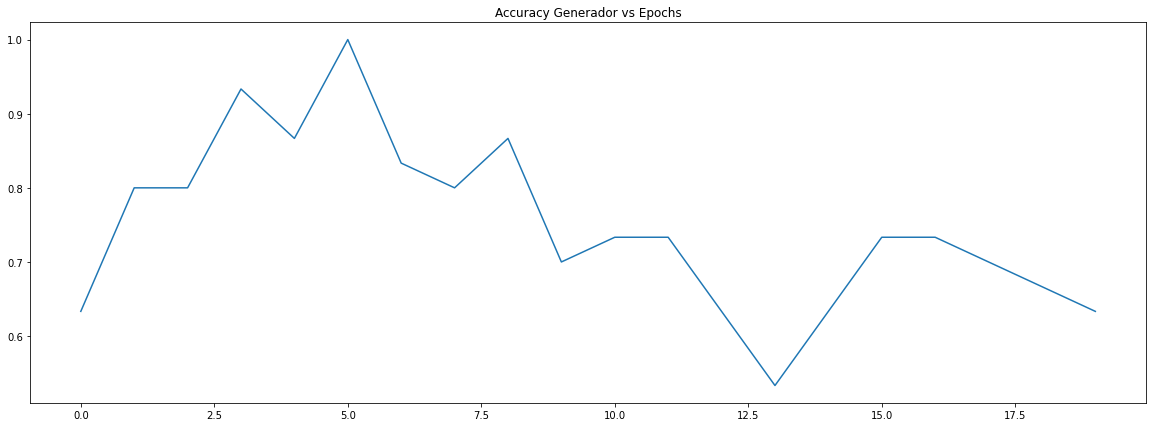

In [ ]:
epochs = np.arange(0, 20)
plt.title("Accuracy Generador vs Epochs")
plt.plot(epochs, 1 - accuracies_g)
